In [ ]:
import gspread
import pandas as pd
import re
from gspread_dataframe import get_as_dataframe
from collections import defaultdict
import time
import matplotlib.pyplot as plt

In [11]:
CREDENTIALS_JSON = '../rm4mt-463314-3ce1280ee29c.json'
sheet_urls = [
    "https://docs.google.com/spreadsheets/d/1yhLFAwm-sFAG2cDxDBQ6C0smcM_f5uQxYuy_clvgueM/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/19sowSDpBO42OSXFeBM92UBp1H2MZkQQWzEAPMpZz9q4/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/16nVSzWScuuYThX2ZgQAyZ0V5ip5d1GFPKCABjG6IHf8/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/1k_zR5v7em_iz1J3K6p4qRYvFrzbFDOjI8lLWtPK3YCM/edit?usp=sharing",
]
sheet_urls_wait = [
    "https://docs.google.com/spreadsheets/d/1LHsMMvKhTEgagmZKQl7ax1H4BJyDBImYMbeE8sNPjJw/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/1PRIfwNA4l2TG3oMFlgM8LIGuxvCH8prfgEvbGMDhqIY/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/11WAU3v3uKN1wV3G7crmGDyo3u4QX4aGlhWpQN7tn9As/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/1pSBxhdqGvu2I5z_8C6l6pePV-IkIl31MM83Py_ILRqU/edit?usp=sharing",
]

In [12]:
gc = gspread.service_account(filename=CREDENTIALS_JSON)
all_data = {}
all_data_wait = {}

In [13]:
for sheet_url in sheet_urls:
    print(f"Reading Sheet: {sheet_url}")
    spreadsheet = gc.open_by_url(sheet_url)
    ws_data = {}
    for worksheet in spreadsheet.worksheets():
        # print(f"  Worksheet: {worksheet.title}")
        df = get_as_dataframe(worksheet, evaluate_formulas=True)
        df = df.dropna(how='all').dropna(axis=1, how='all')
        ws_data[worksheet.title] = df
        time.sleep(2)
    all_data[sheet_url] = ws_data

for sheet_url in sheet_urls_wait:
    print(f"Reading Sheet: {sheet_url}")
    spreadsheet = gc.open_by_url(sheet_url)
    ws_data = {}
    for worksheet in spreadsheet.worksheets():
        # print(f"  Worksheet: {worksheet.title}")
        df = get_as_dataframe(worksheet, evaluate_formulas=True)
        df = df.dropna(how='all').dropna(axis=1, how='all')
        ws_data[worksheet.title] = df
        time.sleep(2)
    all_data_wait[sheet_url] = ws_data

Reading Sheet: https://docs.google.com/spreadsheets/d/1yhLFAwm-sFAG2cDxDBQ6C0smcM_f5uQxYuy_clvgueM/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/19sowSDpBO42OSXFeBM92UBp1H2MZkQQWzEAPMpZz9q4/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/16nVSzWScuuYThX2ZgQAyZ0V5ip5d1GFPKCABjG6IHf8/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/1k_zR5v7em_iz1J3K6p4qRYvFrzbFDOjI8lLWtPK3YCM/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/1LHsMMvKhTEgagmZKQl7ax1H4BJyDBImYMbeE8sNPjJw/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/1PRIfwNA4l2TG3oMFlgM8LIGuxvCH8prfgEvbGMDhqIY/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/11WAU3v3uKN1wV3G7crmGDyo3u4QX4aGlhWpQN7tn9As/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/1pSBxhdqGvu2I5z_8C6l6pePV-IkIl31MM83Py_ILRqU/edit?usp=sharing


In [14]:
def split_by_metric(all_data):
    dfs_by_metric = defaultdict(list)  # metric: list of rows

    for sheet_url, ws_dict in all_data.items():
        for ws_name, df in ws_dict.items():
            match = re.match(r'(.+?)_((comet_score|comet_kiwi_score|grb|grf|gea_100|gea_5|thinking_length))$', ws_name)
            if not match:
                continue
            task = match.group(1)
            metric = match.group(2)
            # Check must have model & lang_pair
            if not {'model', 'lang_pair'}.issubset(df.columns):
                continue
            # Budget Column
            budget_cols = [col for col in df.columns if isinstance(col, (int, float)) or (isinstance(col, str) and col.isdigit())]
            budget_cols = sorted(budget_cols, key=lambda x: int(x))
            for _, row in df.iterrows():
                model = row['model']
                lang_pair = row['lang_pair']
                for budget in budget_cols:
                    val = row[budget]
                    if pd.isna(val):
                        continue
                    dfs_by_metric[metric].append({
                        'model': model,
                        'task': task,
                        'metric': metric,
                        'lang_pair': lang_pair,
                        'budget': int(budget),
                        'score': float(val)
                    })

    # To DataFrame
    for metric in dfs_by_metric:
        dfs_by_metric[metric] = pd.DataFrame(dfs_by_metric[metric])

    return dfs_by_metric

dfs_by_metric = split_by_metric(all_data)
dfs_by_metric_wait = split_by_metric(all_data_wait )

In [15]:
print("Available Metrics:")
print(list(dfs_by_metric.keys()))

Available Metrics:
['comet_score', 'comet_kiwi_score', 'grb', 'grf', 'gea_100', 'gea_5', 'thinking_length']


In [16]:
dfs_by_metric['comet_score']

model                  task       metric lang_pair  \
0                     Qwen3-0.6B  WMT23-Biomedical-Doc  comet_score       Avg   
1                     Qwen3-0.6B  WMT23-Biomedical-Doc  comet_score       Avg   
2                     Qwen3-0.6B  WMT23-Biomedical-Doc  comet_score       Avg   
3                     Qwen3-0.6B  WMT23-Biomedical-Doc  comet_score       Avg   
4                     Qwen3-0.6B  WMT23-Biomedical-Doc  comet_score       Avg   
...                          ...                   ...          ...       ...   
3925  cogito-v1-preview-llama-8B                  CAMT  comet_score     en-zh   
3926  cogito-v1-preview-llama-8B                  CAMT  comet_score     en-zh   
3927  cogito-v1-preview-llama-8B                  CAMT  comet_score     en-zh   
3928  cogito-v1-preview-llama-8B                  CAMT  comet_score     en-zh   
3929  cogito-v1-preview-llama-8B                  CAMT  comet_score     en-zh   

      budget     score  
0          0  0.777628  
1        100  0.775402  
2        200  0.775771  
3        300  0.775590  
4        400  0.776870  
...      ...       ...  
3925     300  0.760983  
3926     400  0.761591  
3927     500  0.762016  
3928    1000  0.760786  
3929    2000  0.761981  

[3930 rows x 6 columns]

In [17]:
def get_model_size(model_name):
    """将模型名中的参数量字符串（如0.6B、13B）转成 float，便于排序"""
    m = re.search(r"(\d+(\.\d+)?)B", model_name)
    if m:
        return float(m.group(1))
    return float("inf")  # 若无B则排最后

In [28]:
def plot_metric_comparison(metric, budgets=[1000, 2000], exclude_models=None):
    """
    绘制指定metric的normal vs wait对比图，同时显示thinking length
    
    Parameters:
    -----------
    metric : str
        要分析的指标名称 (e.g., "comet_score", "comet_kiwi_score", "grb", "grf", "gea_100", "gea_5")
    budgets : list
        要分析的budget列表，默认为[1000, 2000]
    exclude_models : list
        要排除的模型列表，默认排除cogito-v1-preview-llama-8B和cogito-v1-preview-llama-3B
    """
    if exclude_models is None:
        exclude_models = ["cogito-v1-preview-llama-8B", "cogito-v1-preview-llama-3B"]
    
    thinking_metric = "thinking_length"
    merge_cols = ["model", "task", "lang_pair", "budget"]

    # 检查metric是否存在
    if metric not in dfs_by_metric:
        print(f"Error: Metric '{metric}' not found. Available metrics: {list(dfs_by_metric.keys())}")
        return

    # 取分数
    df_score = dfs_by_metric[metric]
    df_score_wait = dfs_by_metric_wait[metric]
    df_score = df_score[df_score["budget"].isin(budgets)].rename(
        columns={"score": "score_normal"}
    )
    df_score_wait = df_score_wait[df_score_wait["budget"].isin(budgets)].rename(
        columns={"score": "score_wait"}
    )

    # 取思考长度
    df_thinking = dfs_by_metric[thinking_metric]
    df_thinking_wait = dfs_by_metric_wait[thinking_metric]
    df_thinking = df_thinking[df_thinking["budget"].isin(budgets)].rename(
        columns={"score": "think_normal"}
    )
    df_thinking_wait = df_thinking_wait[df_thinking_wait["budget"].isin(budgets)].rename(
        columns={"score": "think_wait"}
    )

    # 合并
    df_merged = pd.merge(
        df_score, df_score_wait[merge_cols + ["score_wait"]], on=merge_cols, how="inner"
    )
    df_merged = pd.merge(
        df_merged, df_thinking[merge_cols + ["think_normal"]], on=merge_cols, how="left"
    )
    df_merged = pd.merge(
        df_merged, df_thinking_wait[merge_cols + ["think_wait"]], on=merge_cols, how="left"
    )

    # 过滤掉不需要的模型
    df_merged = df_merged[~df_merged["model"].isin(exclude_models)]

    tasks = df_merged["task"].unique()
    for task in tasks:
        task_df = df_merged[(df_merged["task"] == task) & (df_merged["lang_pair"] == "Avg")]
        if task_df.empty:
            continue

        fig, axes = plt.subplots(1, len(budgets), figsize=(15, 5), sharey=False)
        if len(budgets) == 1:
            axes = [axes]

        all_handles = []
        all_labels = []

        for idx, budget in enumerate(budgets):
            plot_df = task_df[task_df["budget"] == budget]
            if plot_df.empty:
                continue

            plot_df = plot_df.copy()
            plot_df['model_size'] = plot_df['model'].map(get_model_size)
            plot_df = plot_df.sort_values('model_size')

            ax1 = axes[idx]
            x = range(len(plot_df))
            models = plot_df["model"]

            width = 0.35
            bars1 = ax1.bar(
                [i - width / 2 for i in x],
                plot_df["score_normal"],
                width=width,
                label="Normal Score",
            )
            bars2 = ax1.bar(
                [i + width / 2 for i in x],
                plot_df["score_wait"],
                width=width,
                label="Wait Score",
            )
            ax1.set_ylabel(f"{metric}")
            # ax1.set_xlabel("Model")
            ax1.set_xticks(x)
            ax1.set_xticklabels(models, rotation=30)
            ax1.set_title(f"Budget: {budget}")

            # 右侧y轴：thinking_length
            ax2 = ax1.twinx()
            (line1,) = ax2.plot(
                x,
                plot_df["think_normal"],
                marker="o",
                linestyle="-",
                color="blue",
                label="Normal Thinking Length",
            )
            (line2,) = ax2.plot(
                x,
                plot_df["think_wait"],
                marker="o",
                linestyle="--",
                color="red",
                label="Wait Thinking Length",
            )
            ax2.set_ylabel("Thinking Length")

            # 收集legend handles和labels
            handles1, labels1 = ax1.get_legend_handles_labels()
            handles2, labels2 = ax2.get_legend_handles_labels()
            all_handles += handles1 + handles2
            all_labels += labels1 + labels2

        # 去重，保持顺序
        unique = dict(zip(all_labels, all_handles))
        fig.legend(
            list(unique.values()),
            list(unique.keys()),
            loc="upper right",
            bbox_to_anchor=(0.98, 0.99),
            fontsize="small",
            frameon=True,
            ncol=1,
        )

        plt.suptitle(f"{metric} | Task: {task} | Lang Pair: Avg")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

### Qwen-3

#### Comet

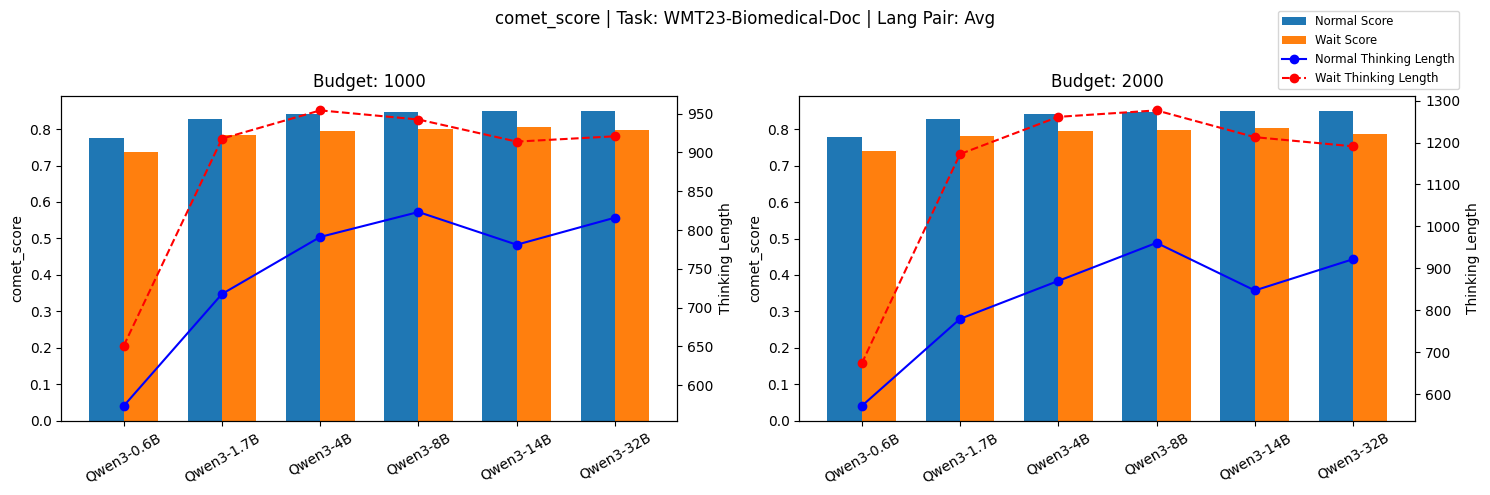

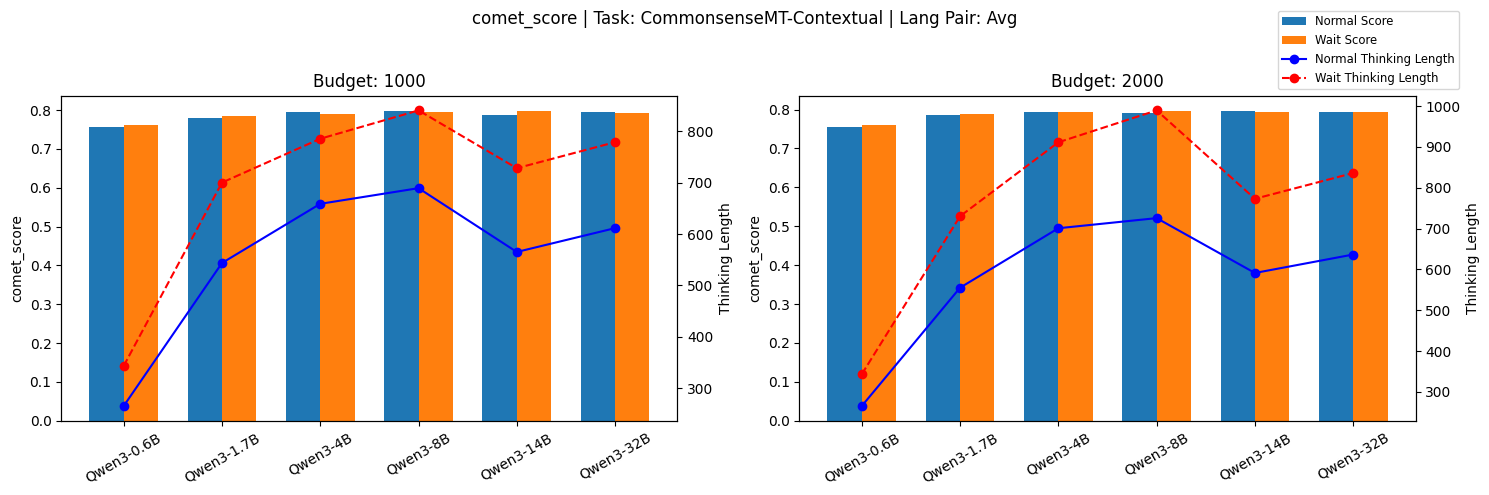

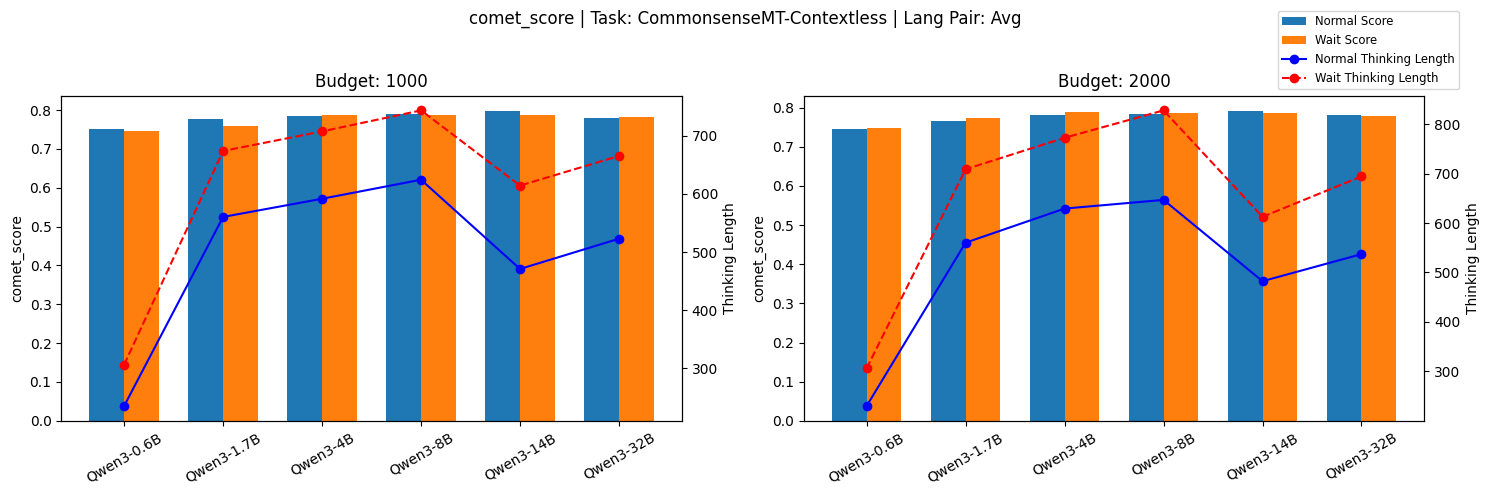

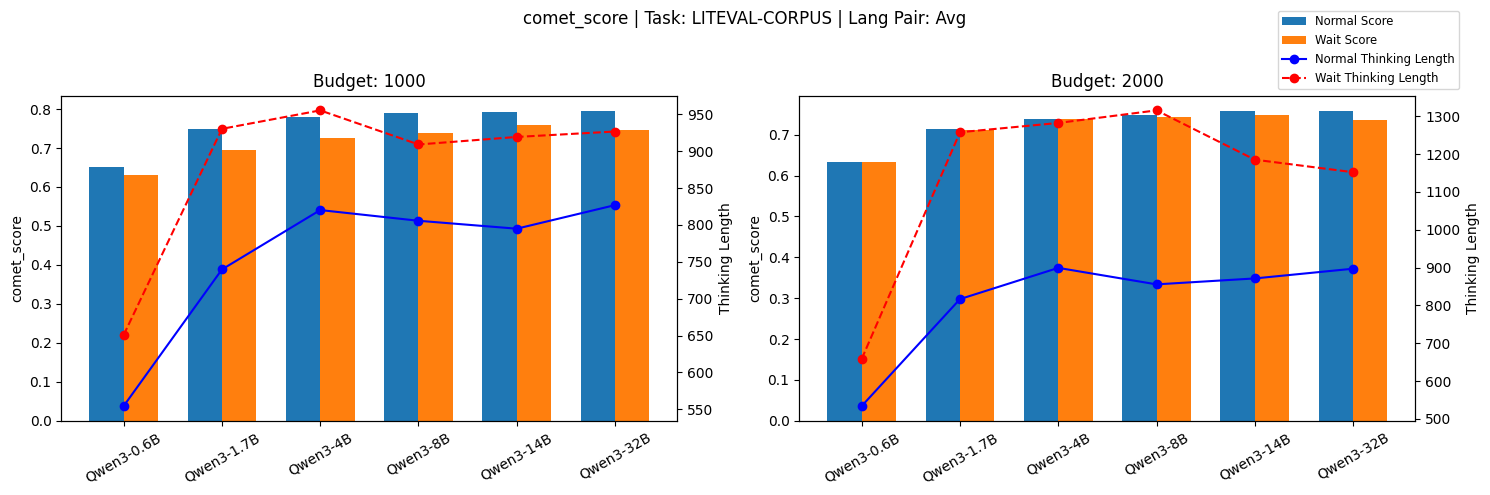

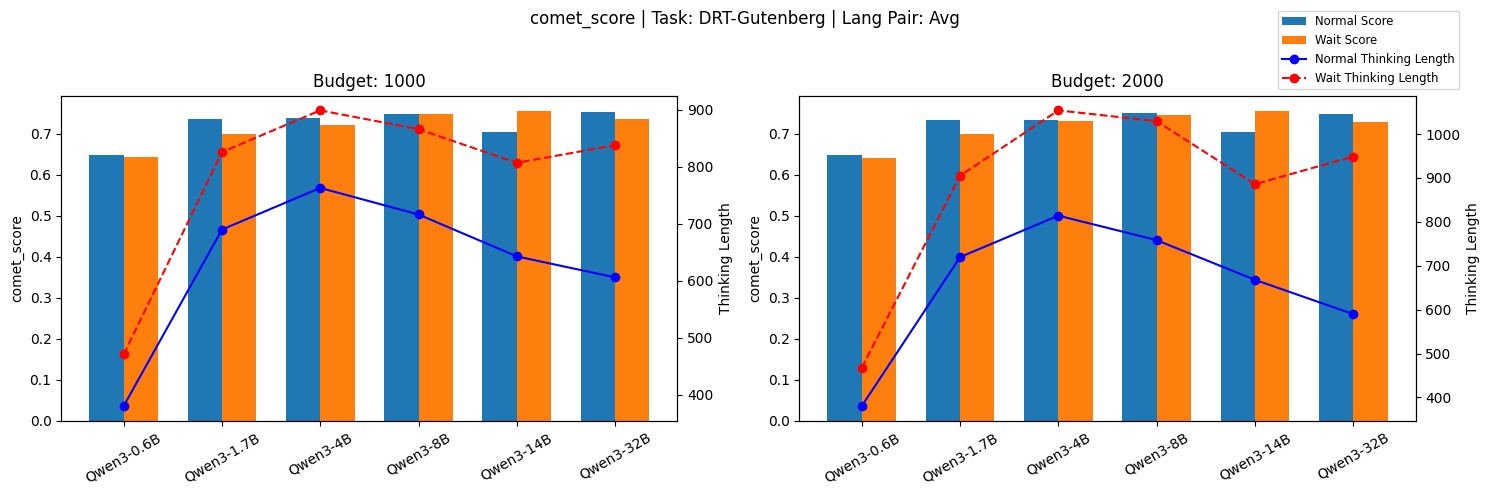

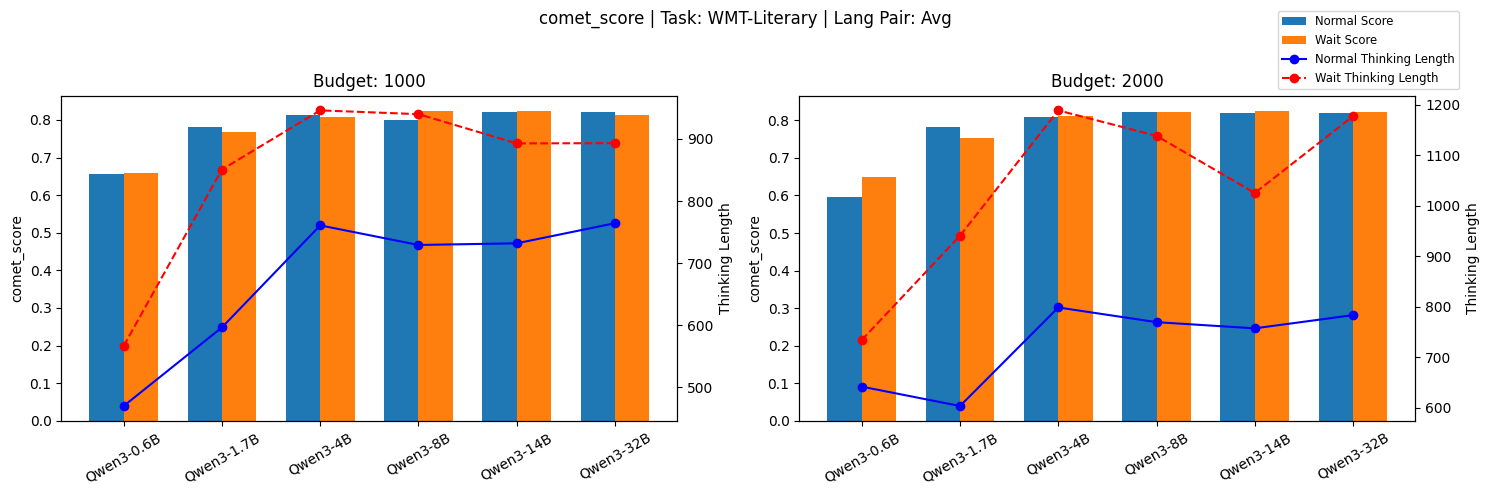

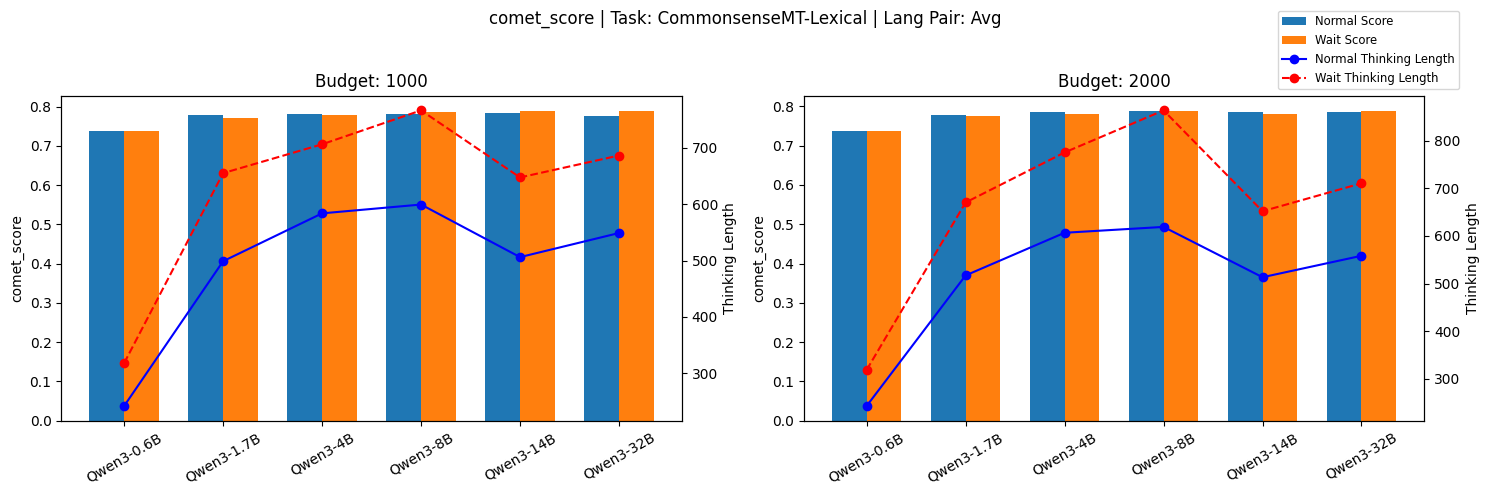

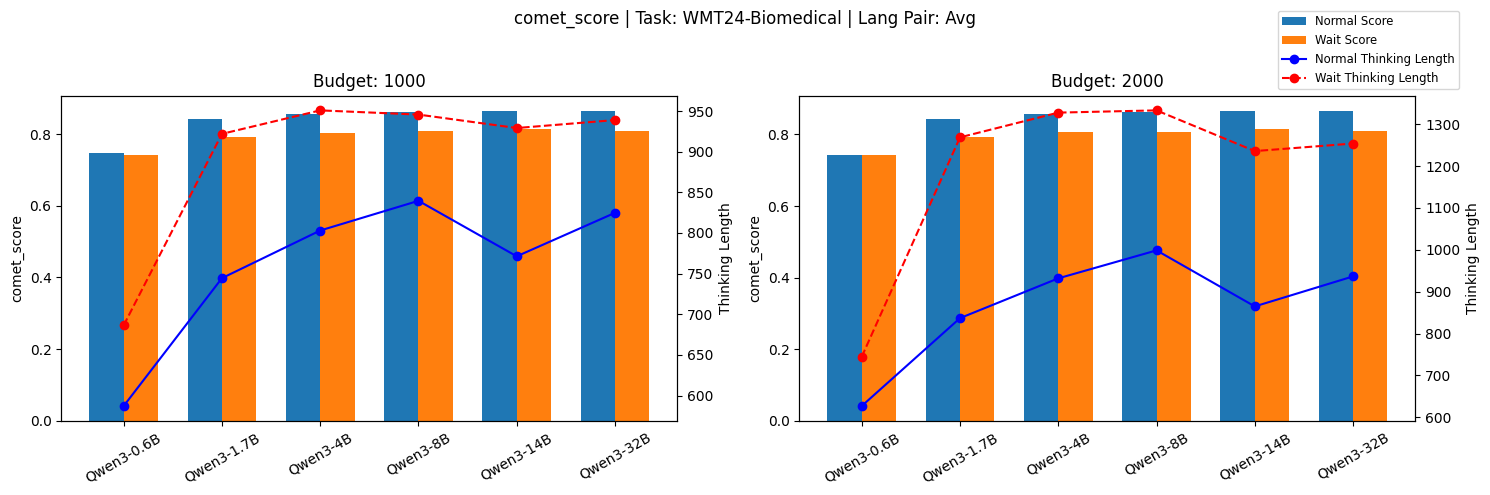

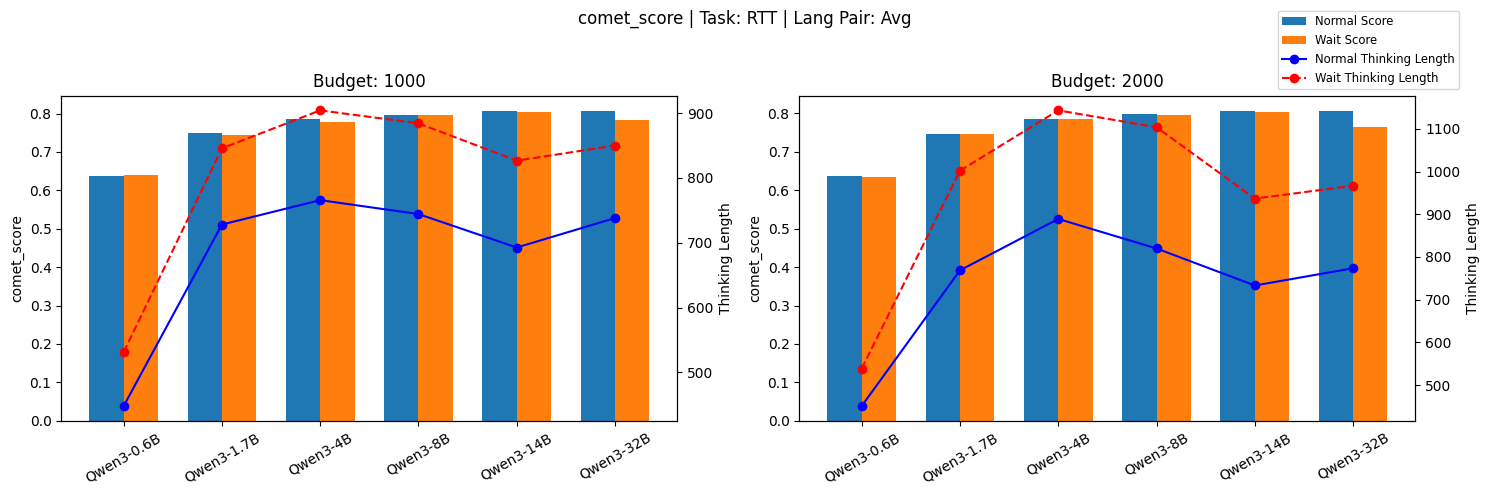

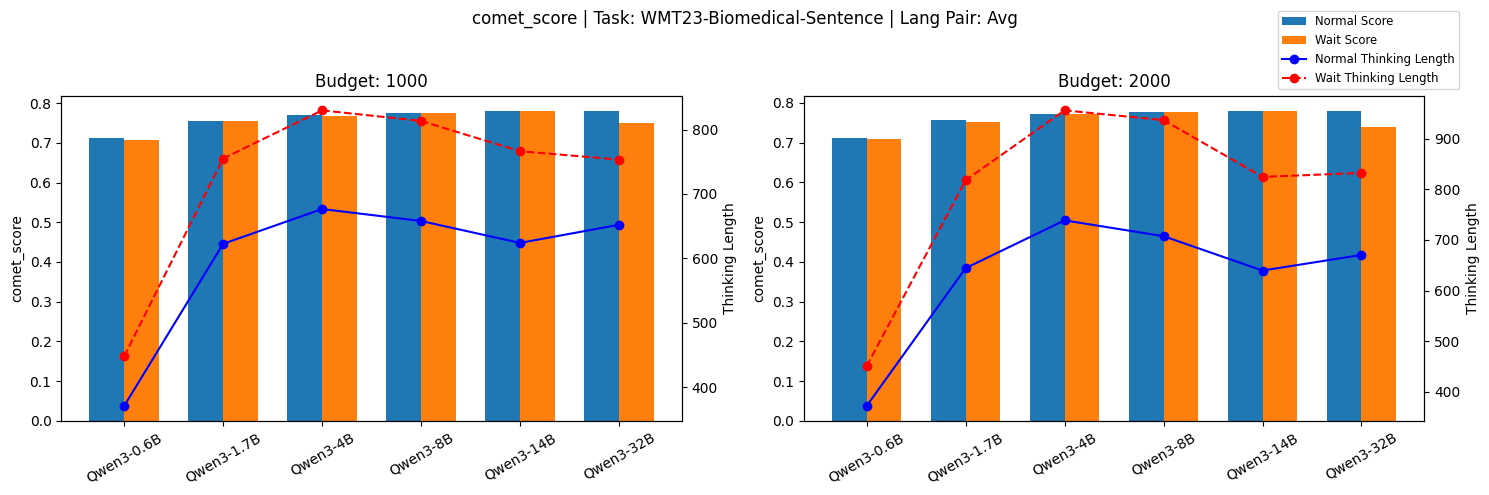

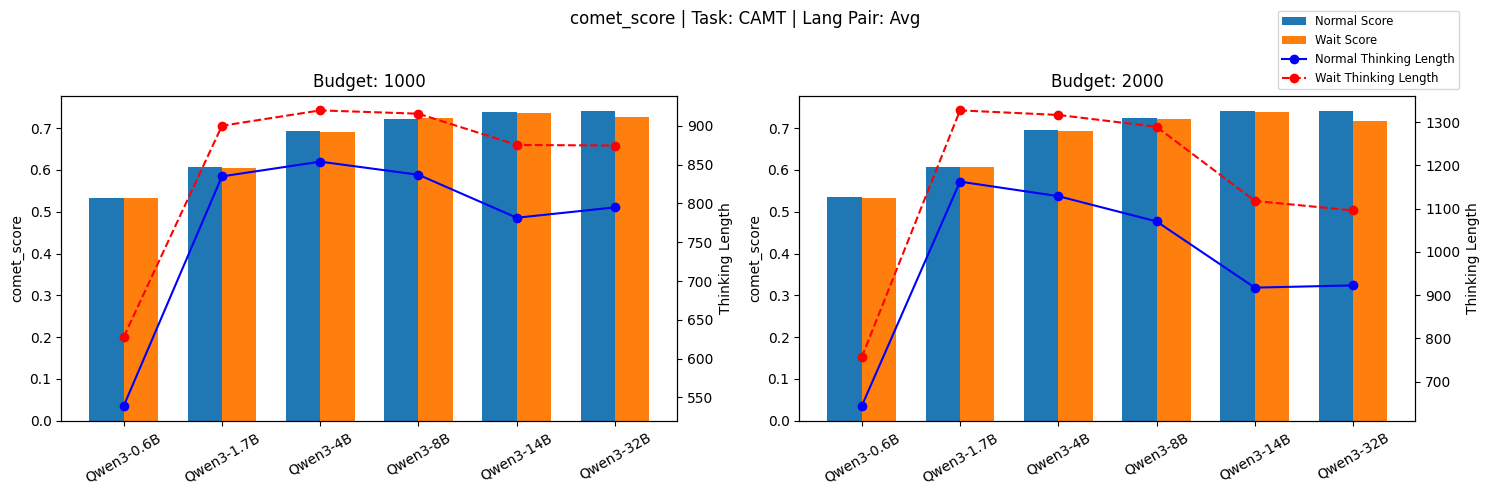

In [29]:
plot_metric_comparison("comet_score")

#### CometKiwi

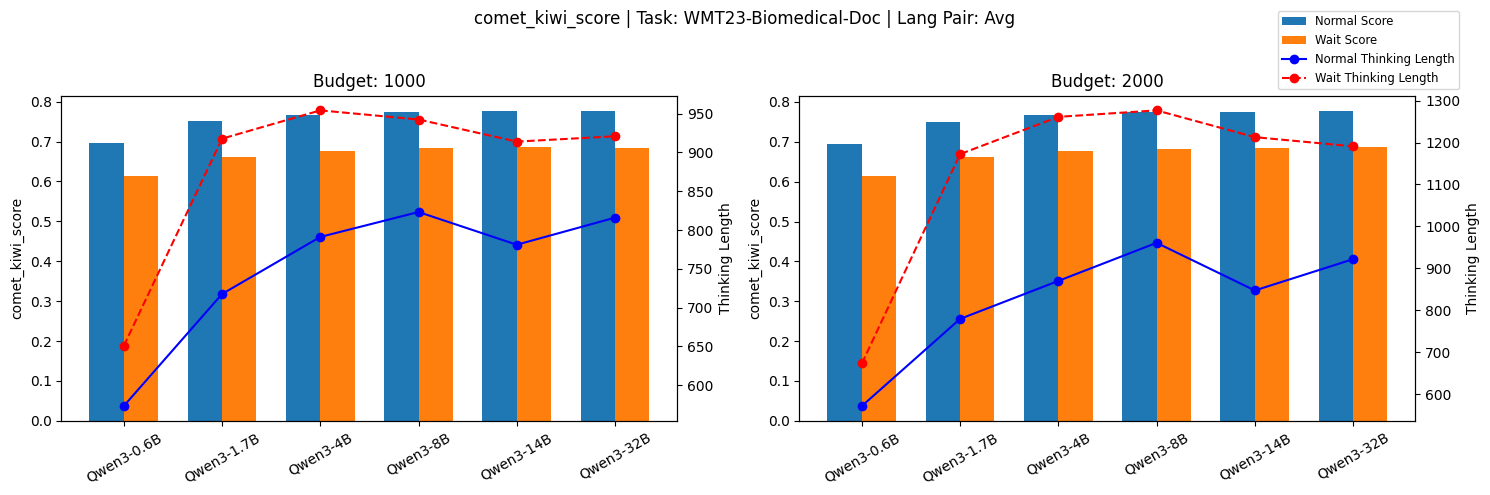

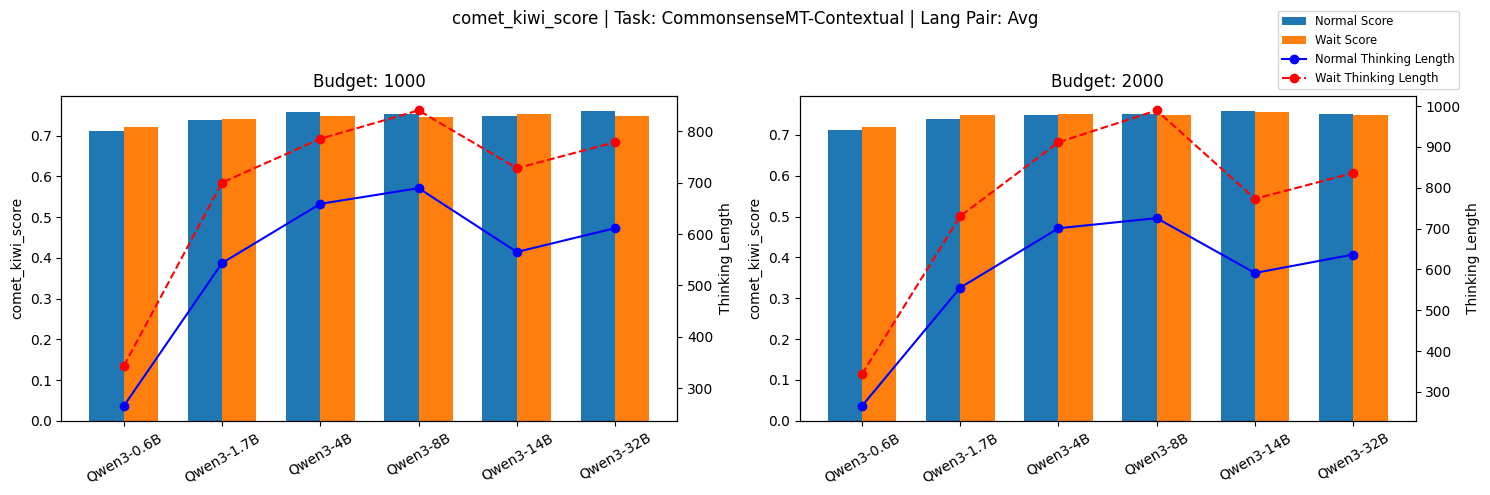

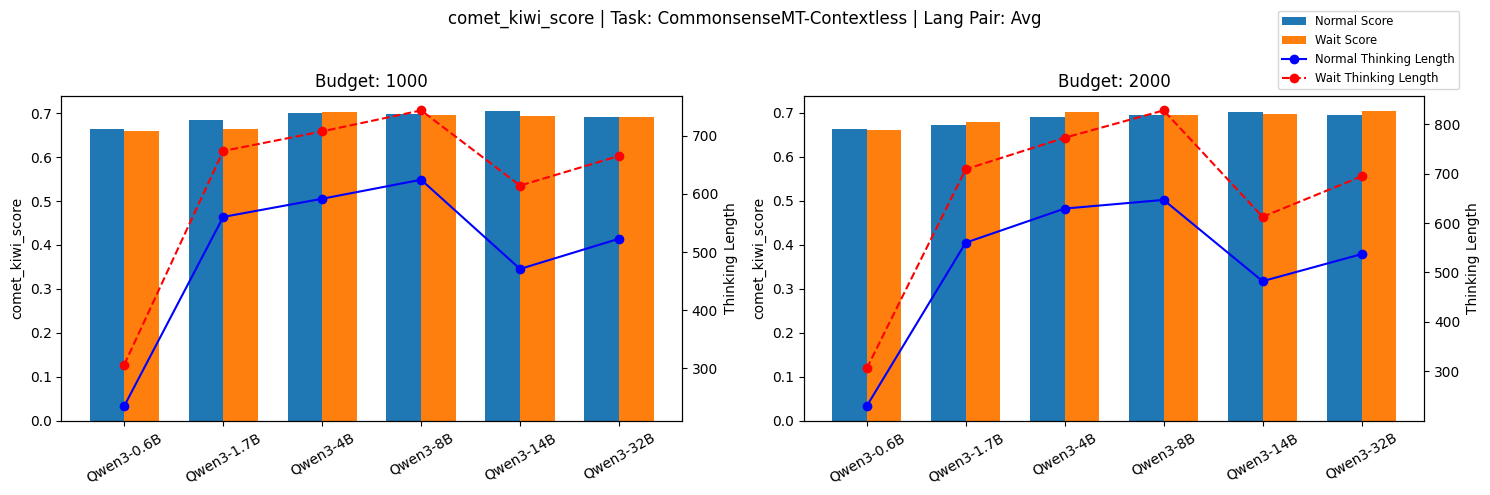

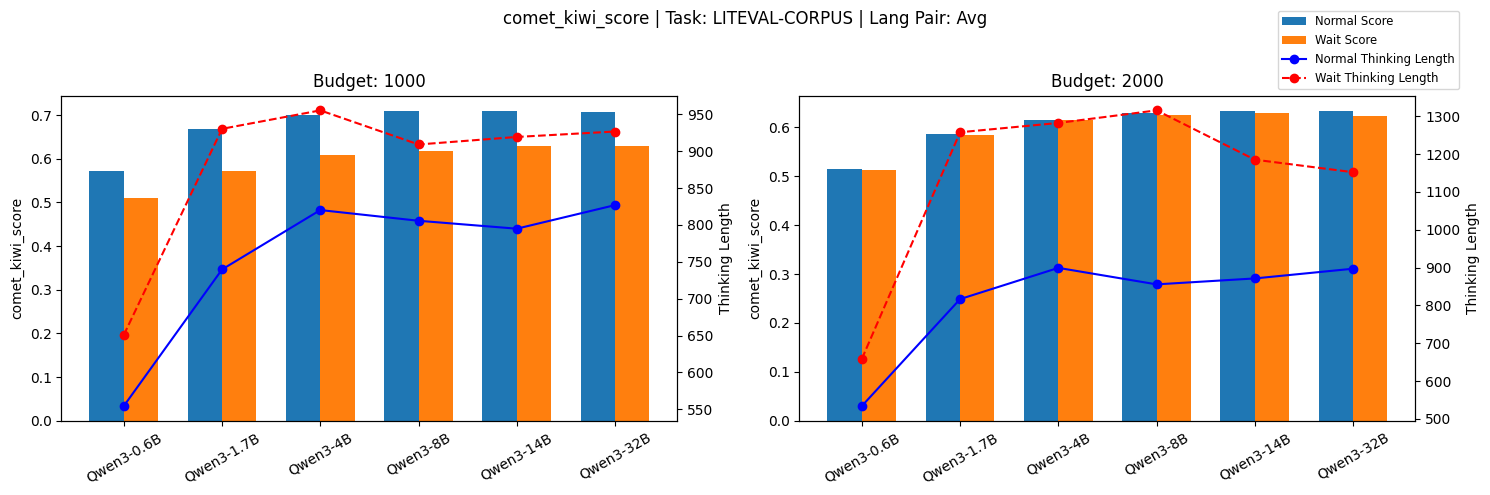

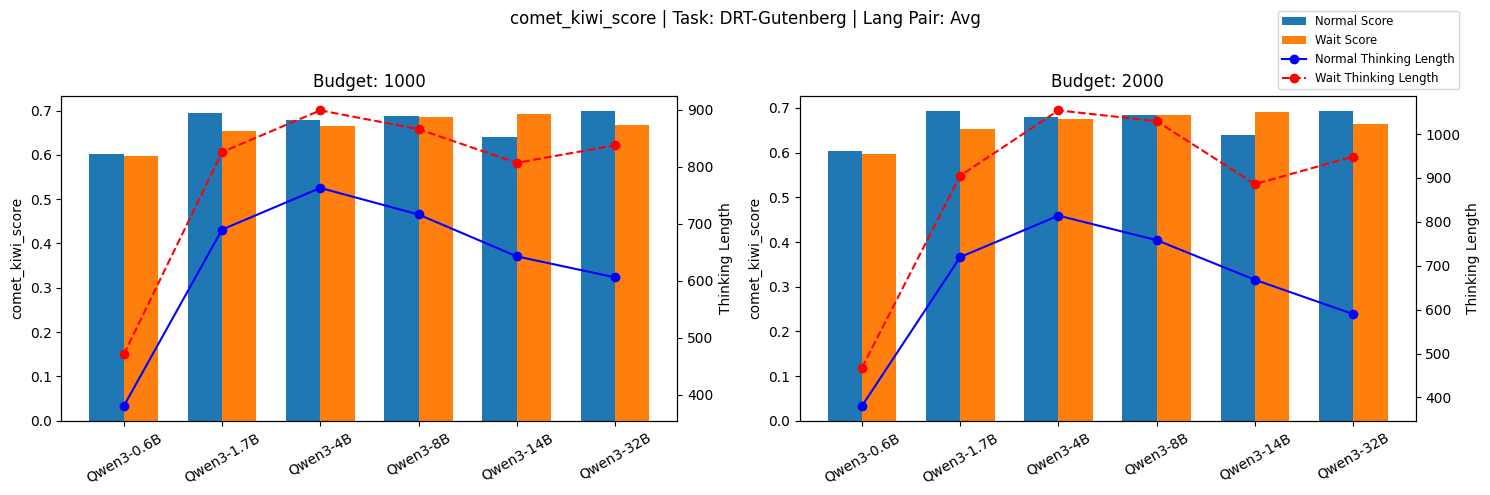

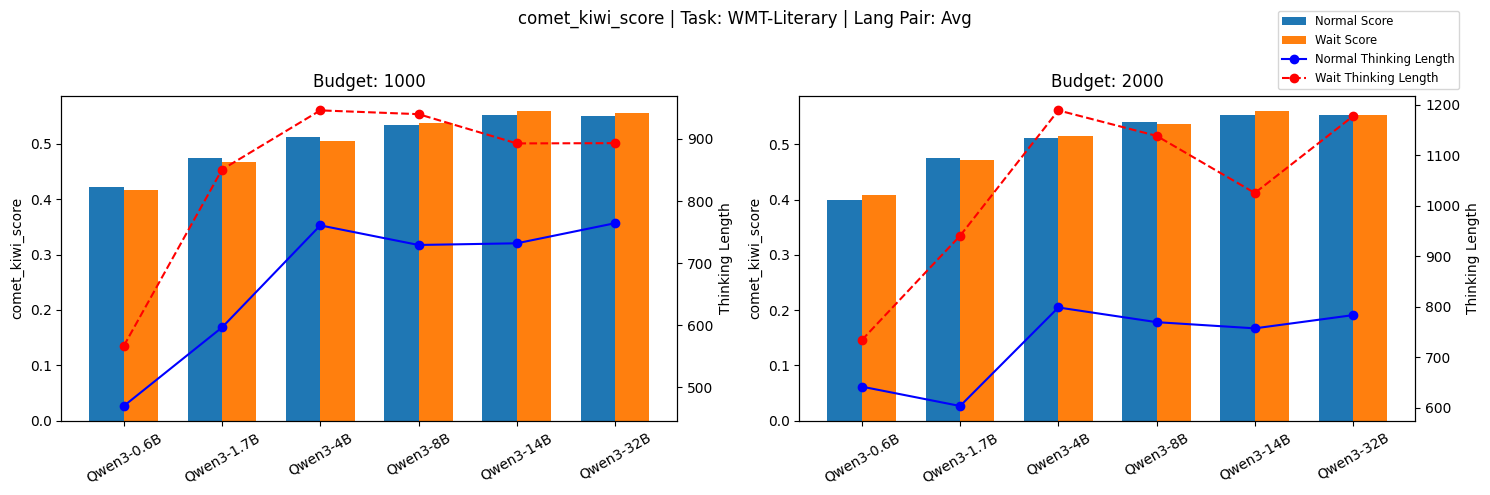

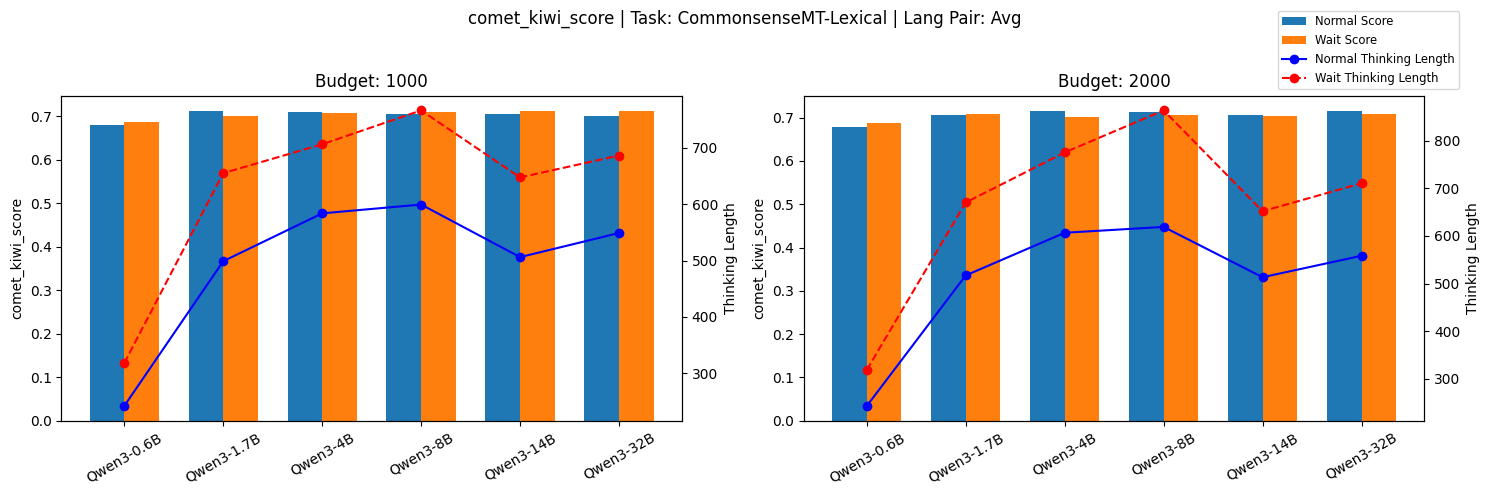

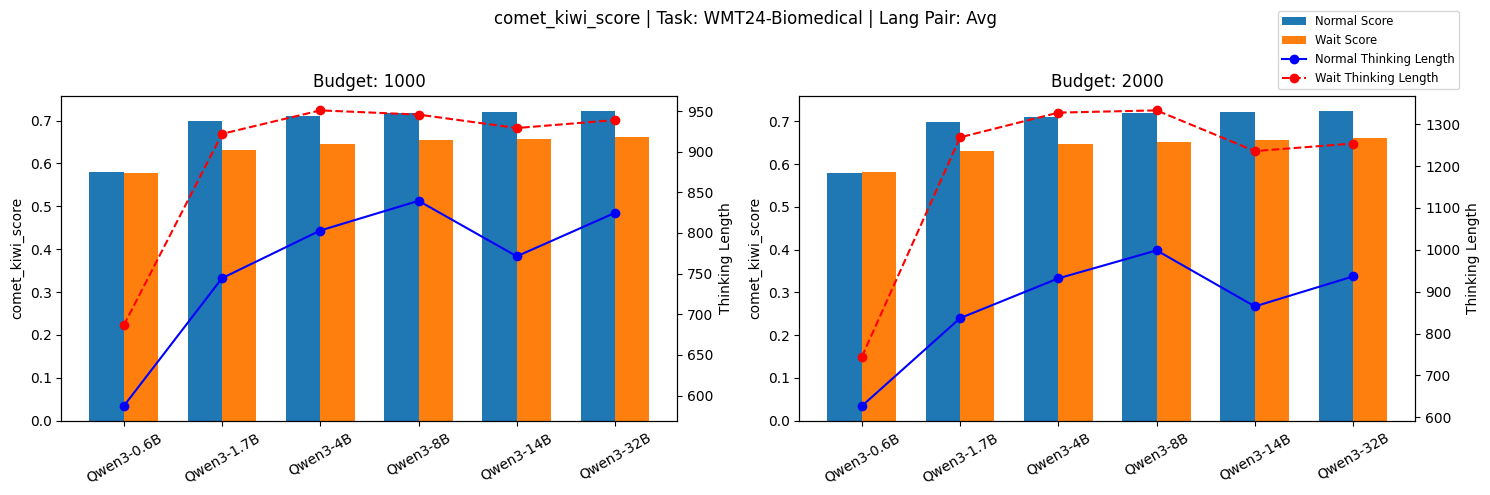

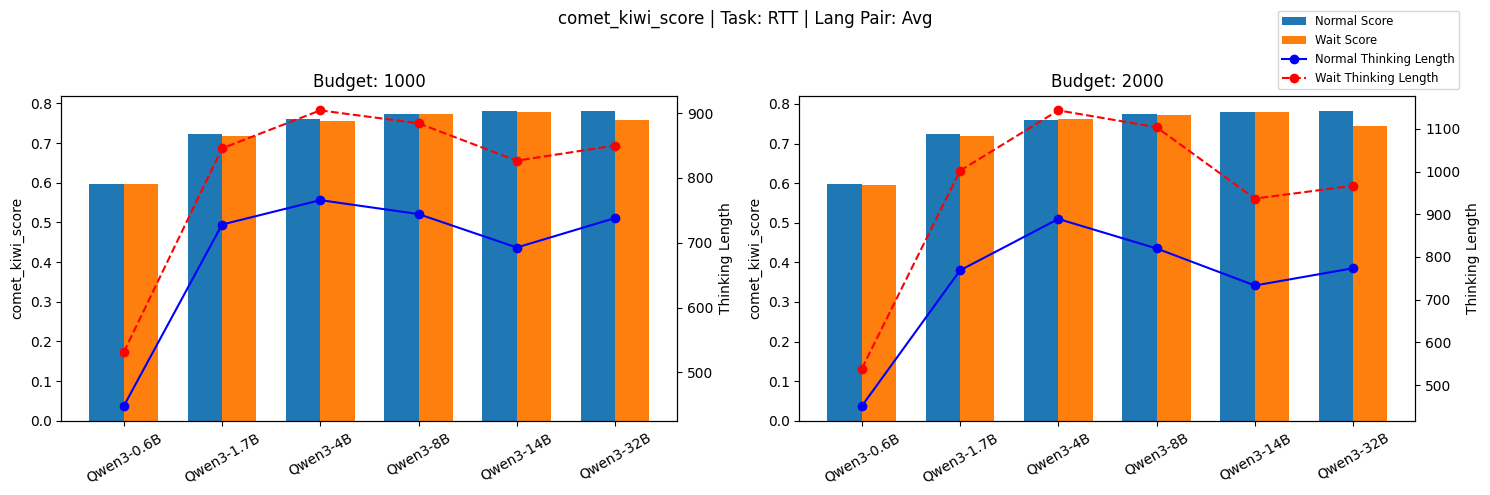

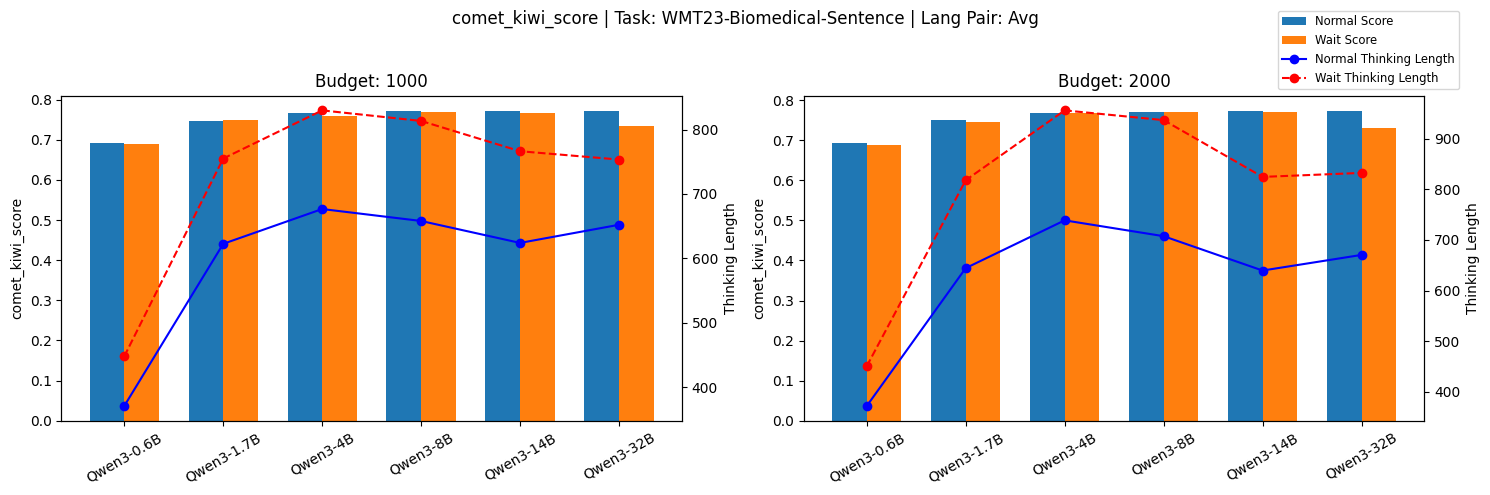

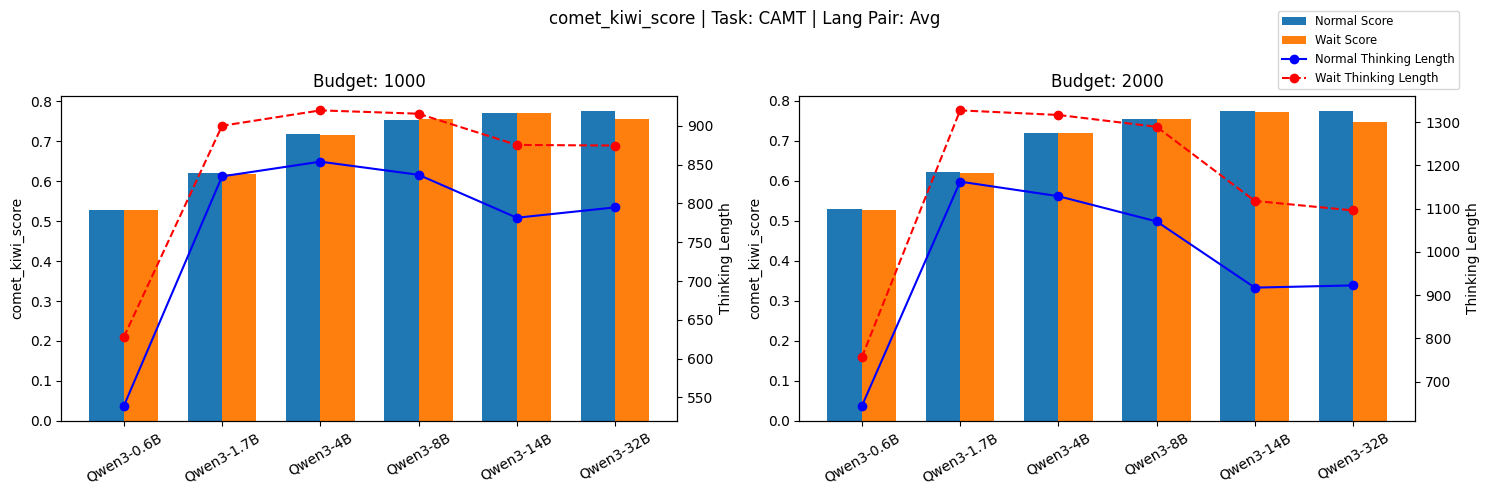

In [30]:
plot_metric_comparison("comet_kiwi_score")

#### GRB

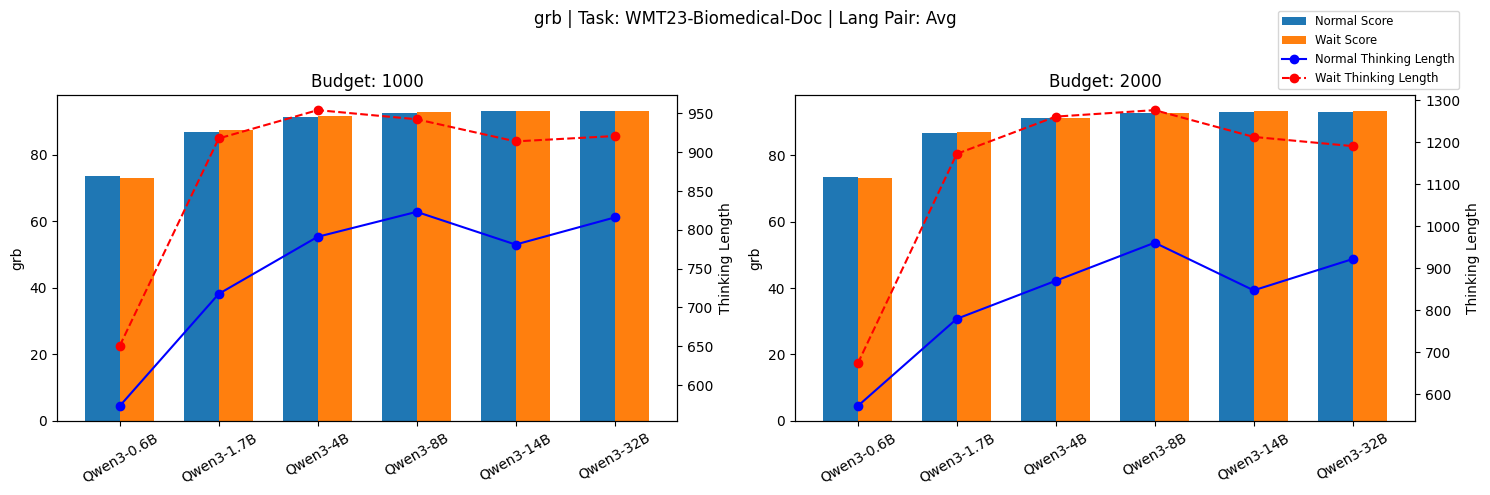

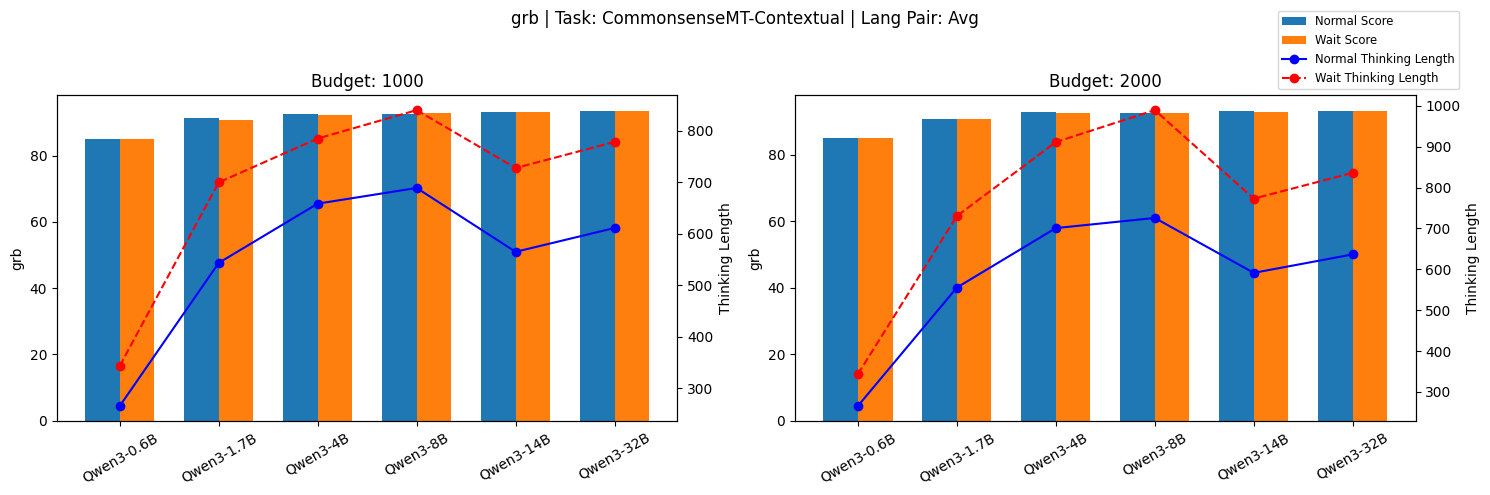

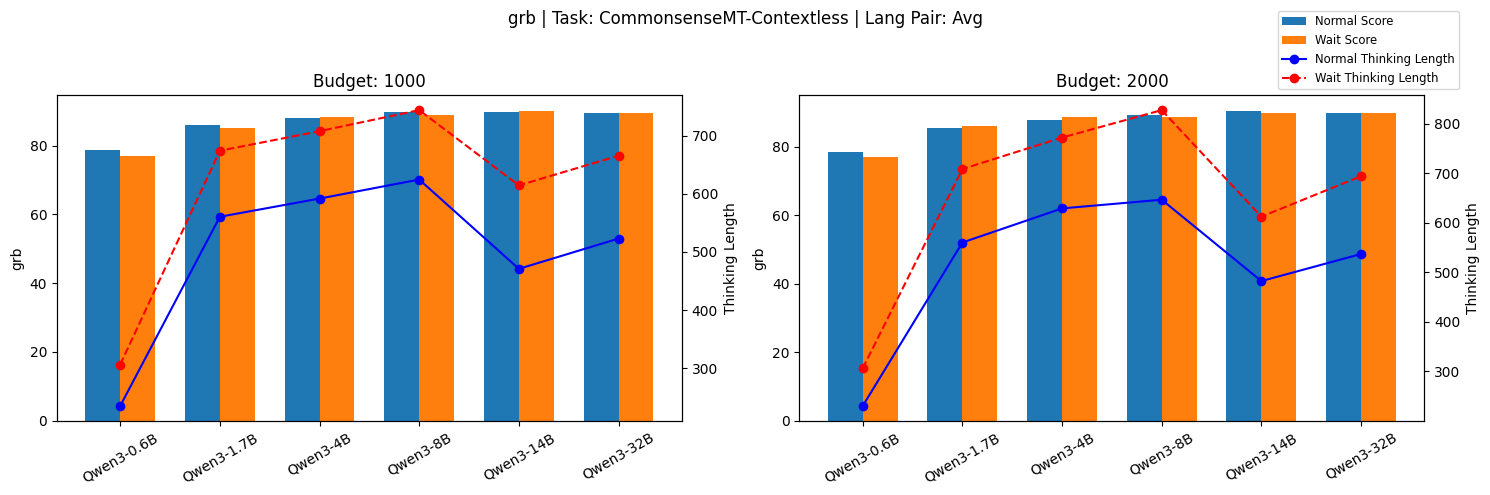

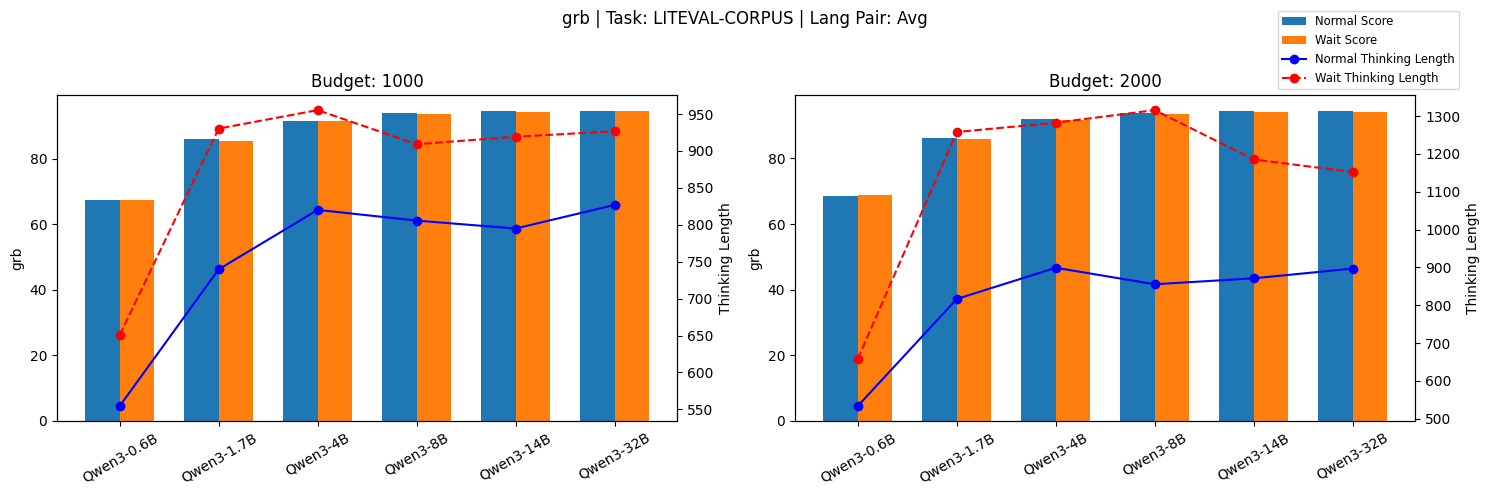

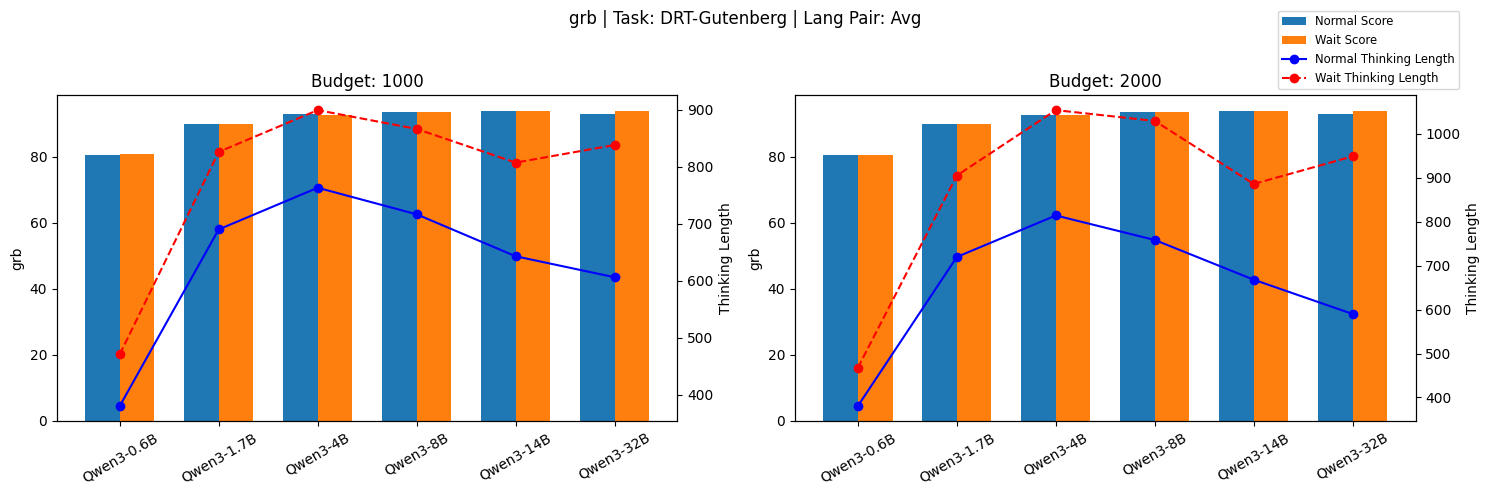

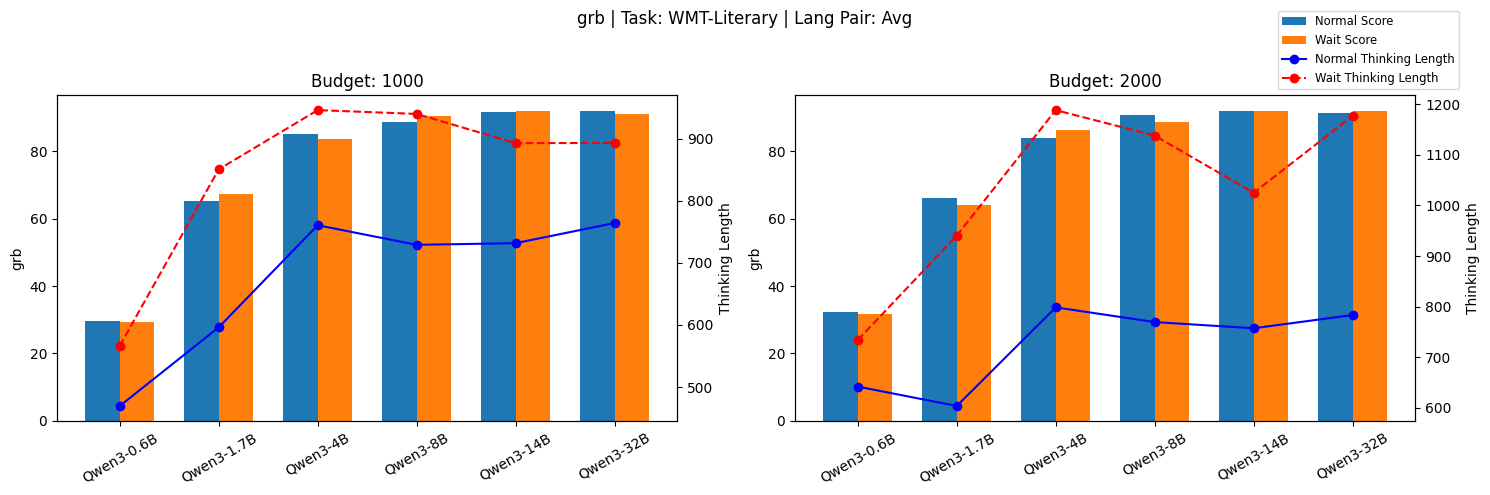

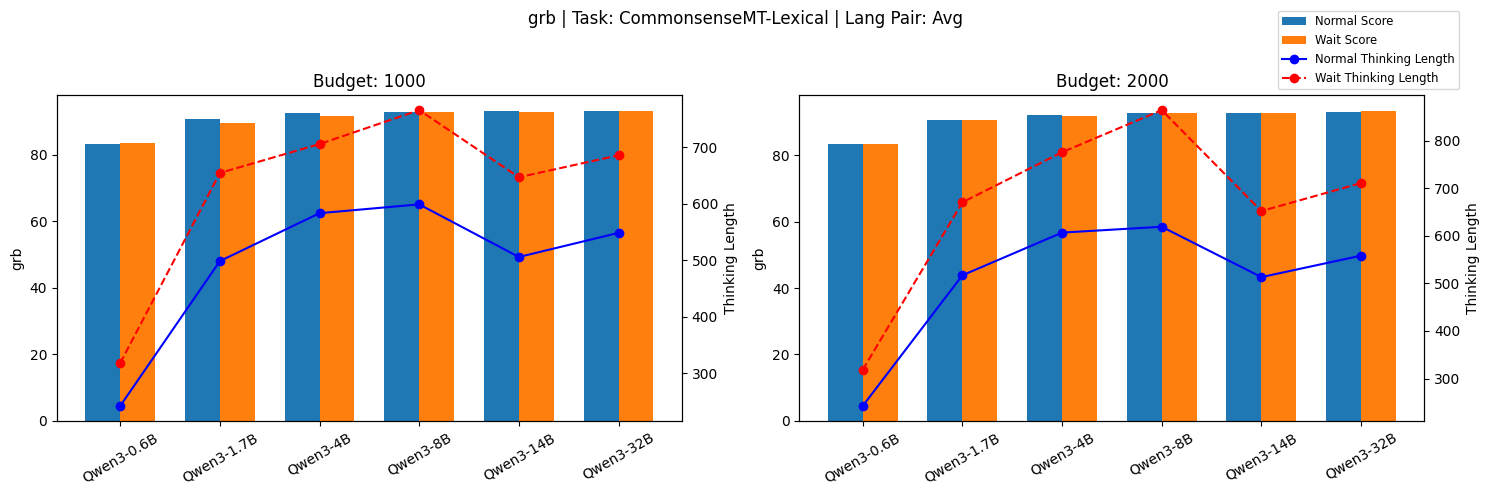

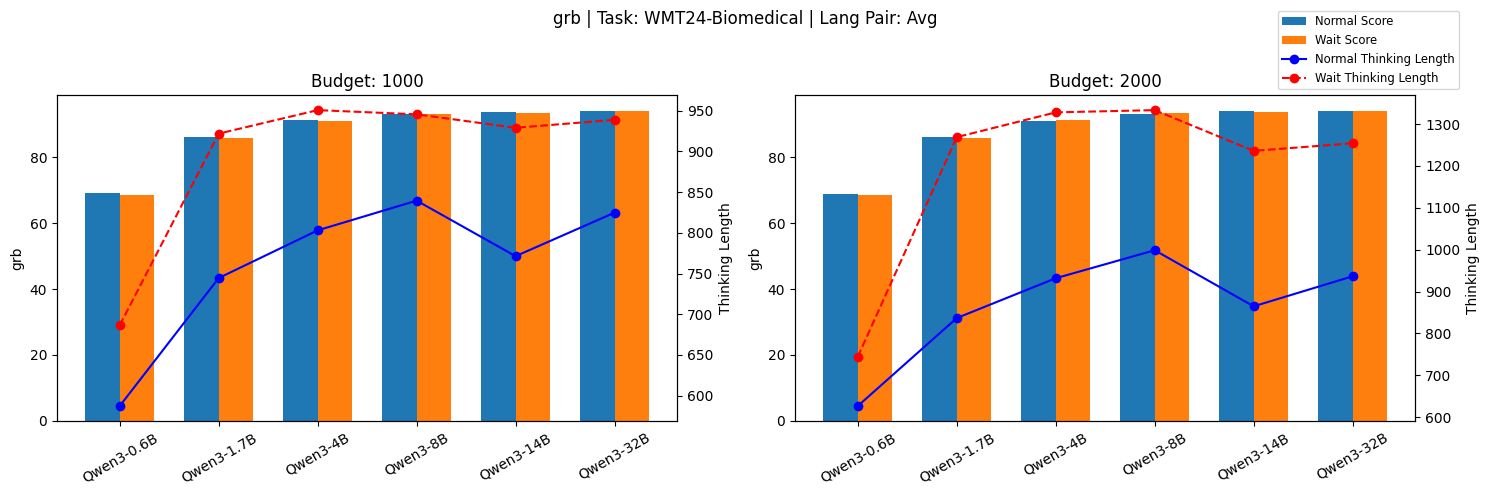

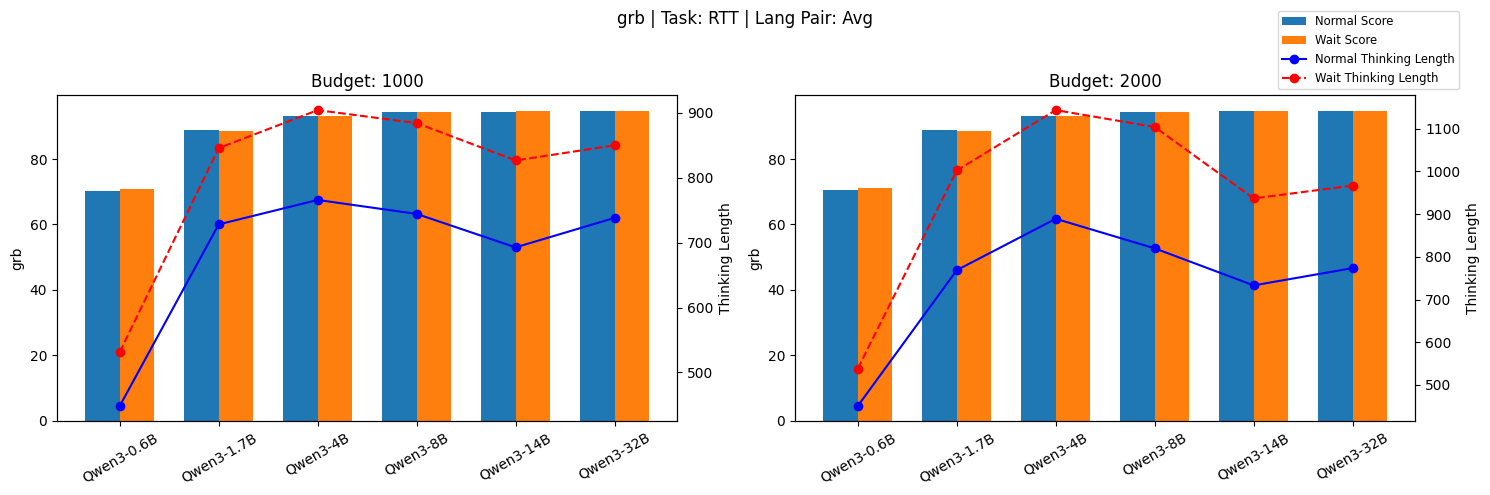

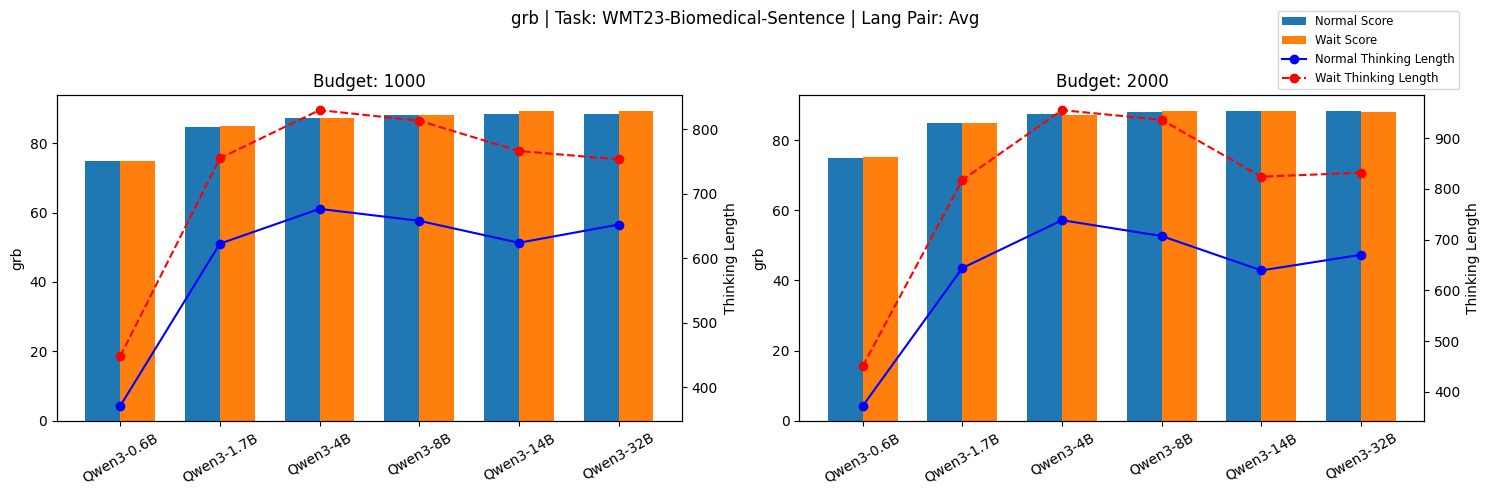

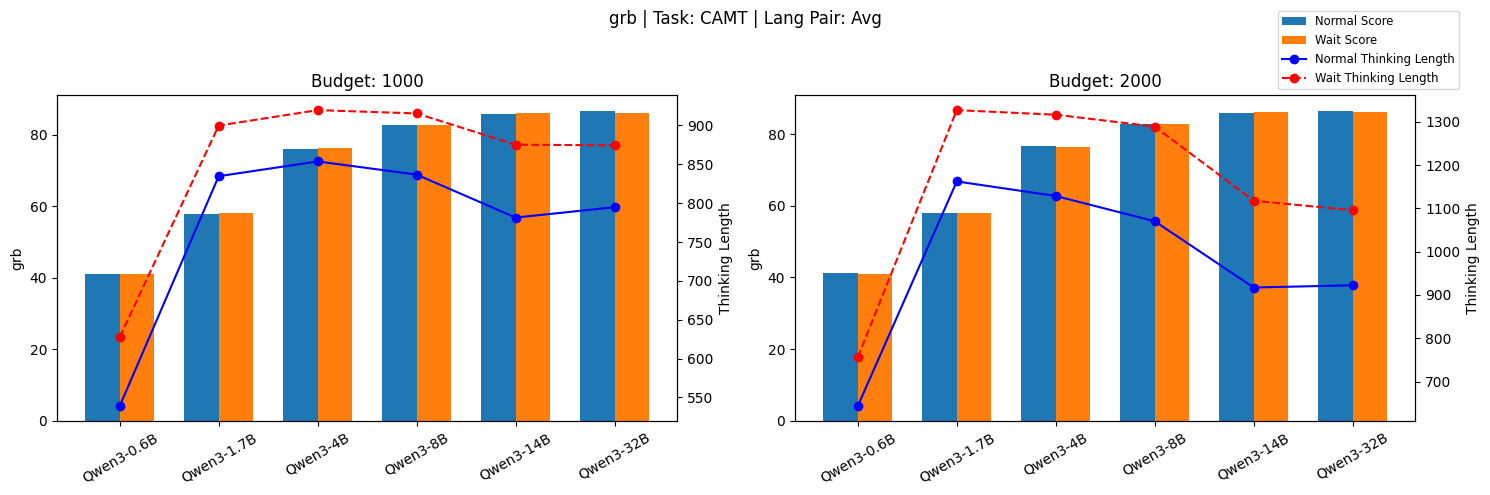

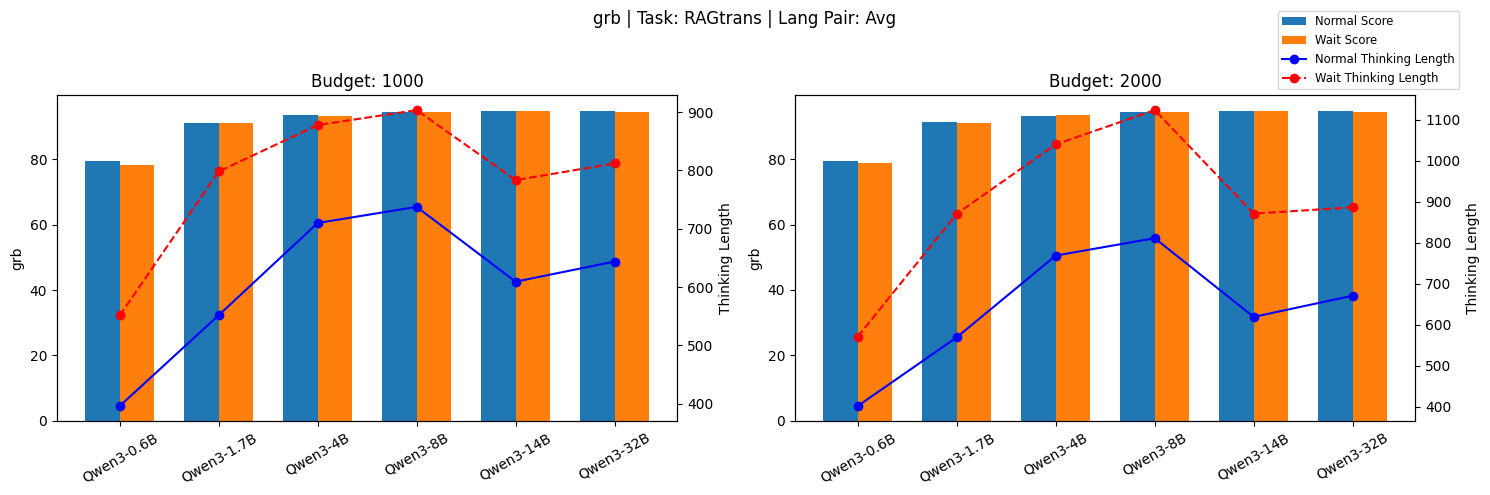

In [31]:
plot_metric_comparison("grb")

#### GRF

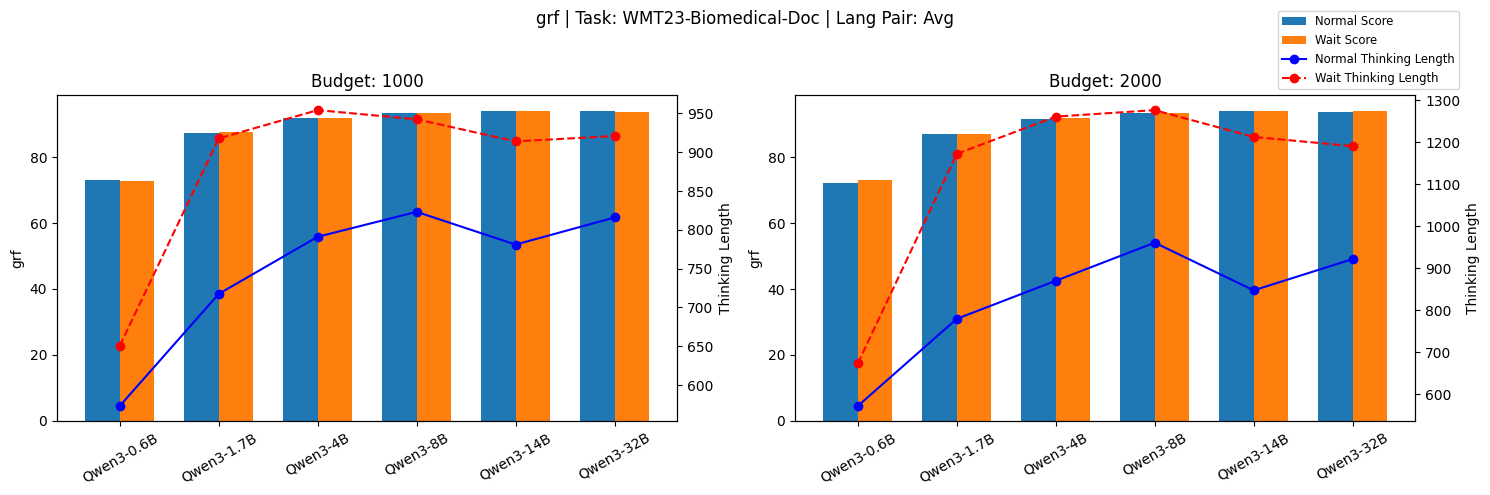

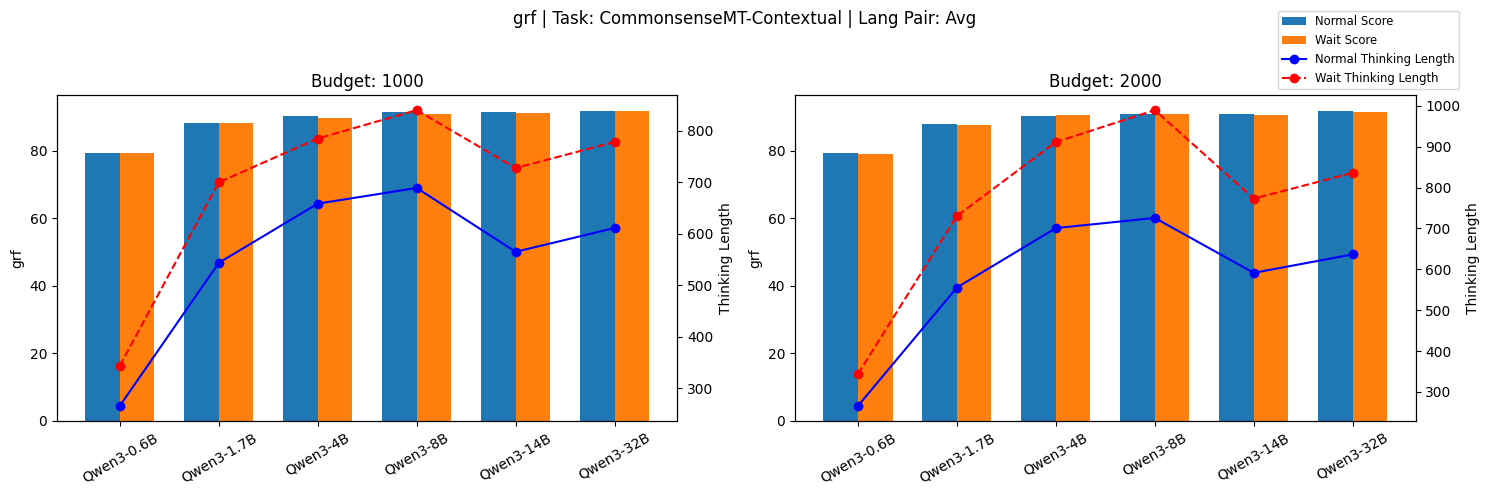

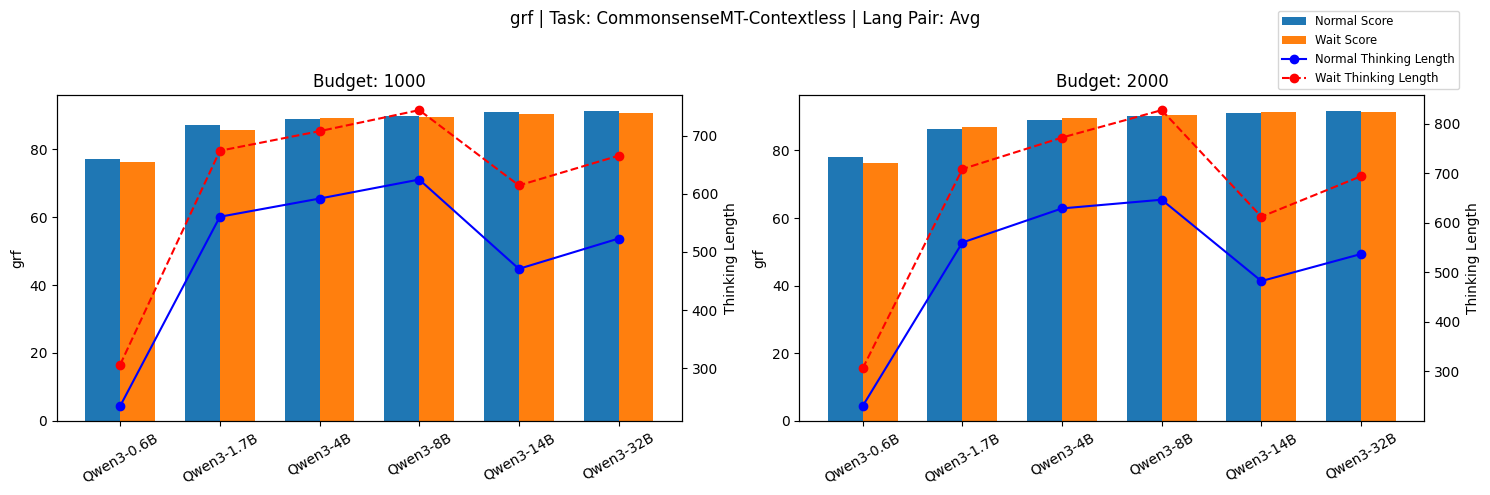

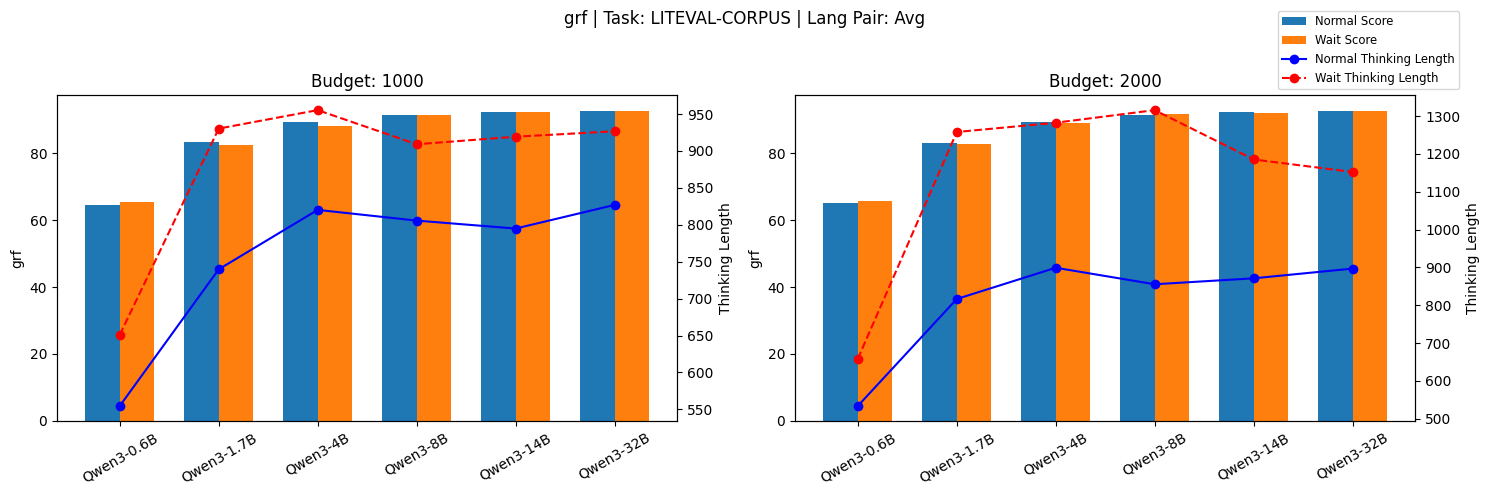

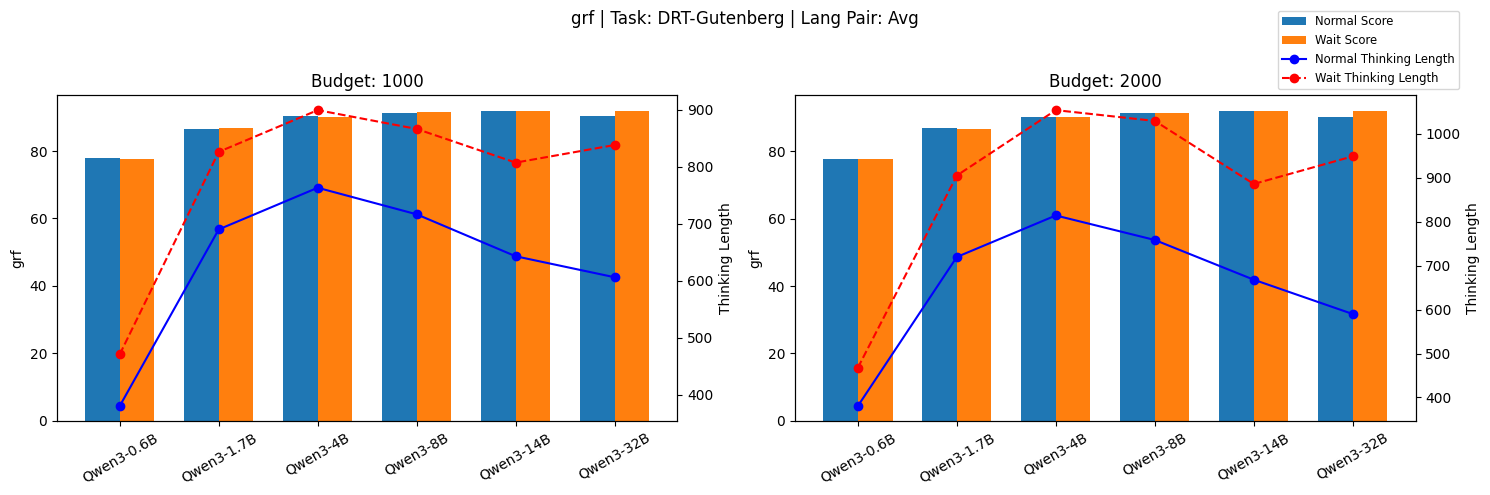

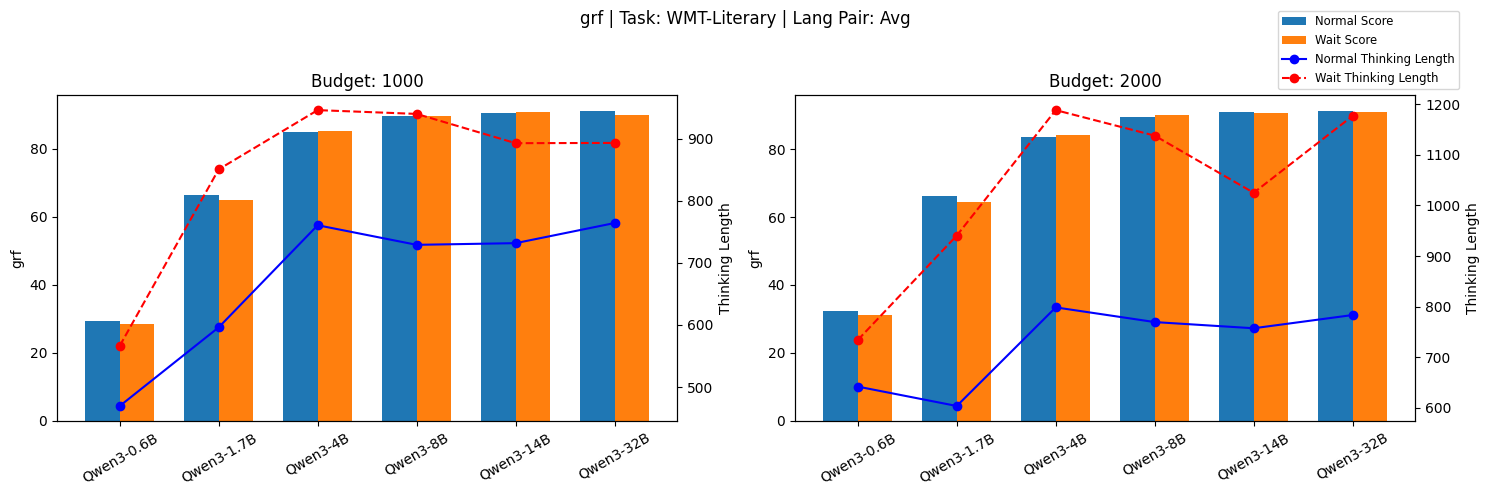

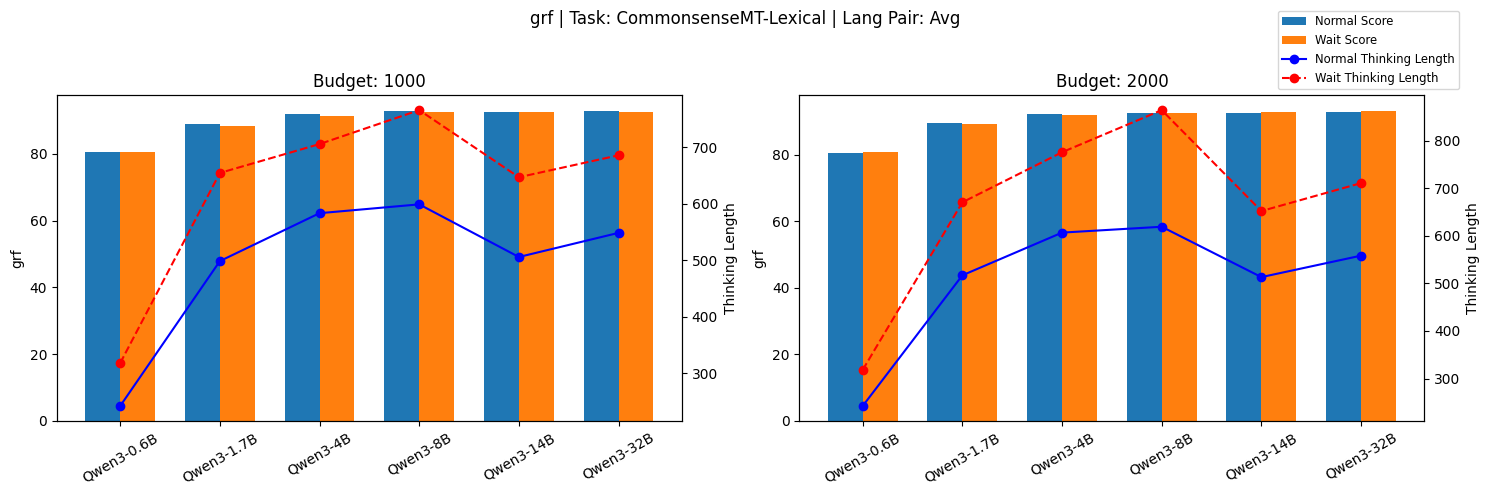

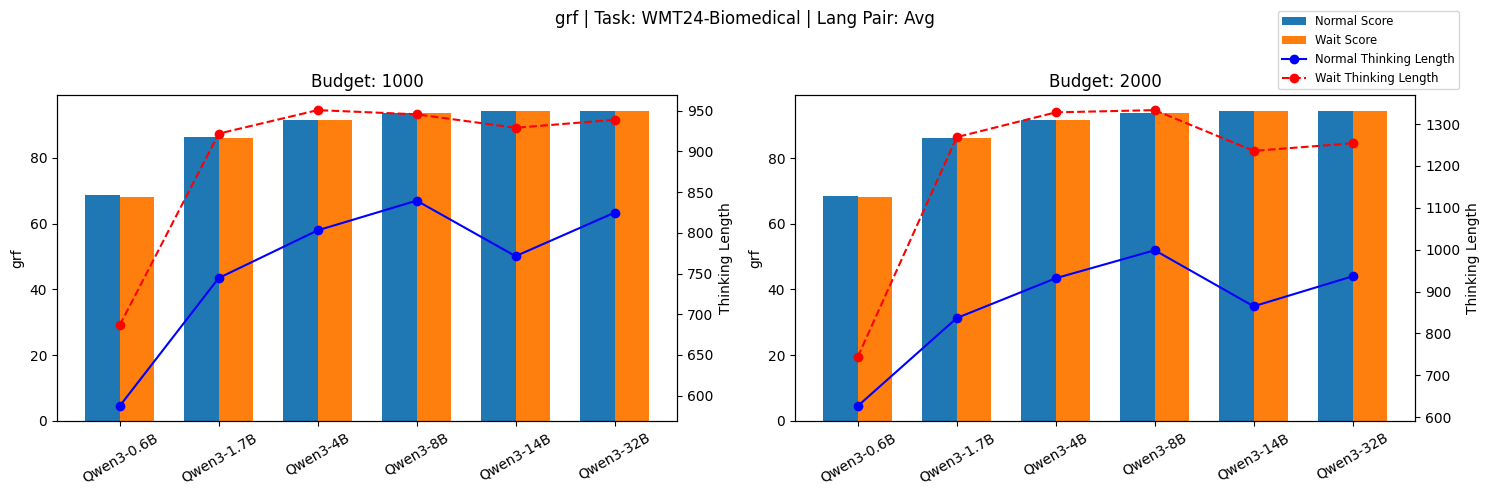

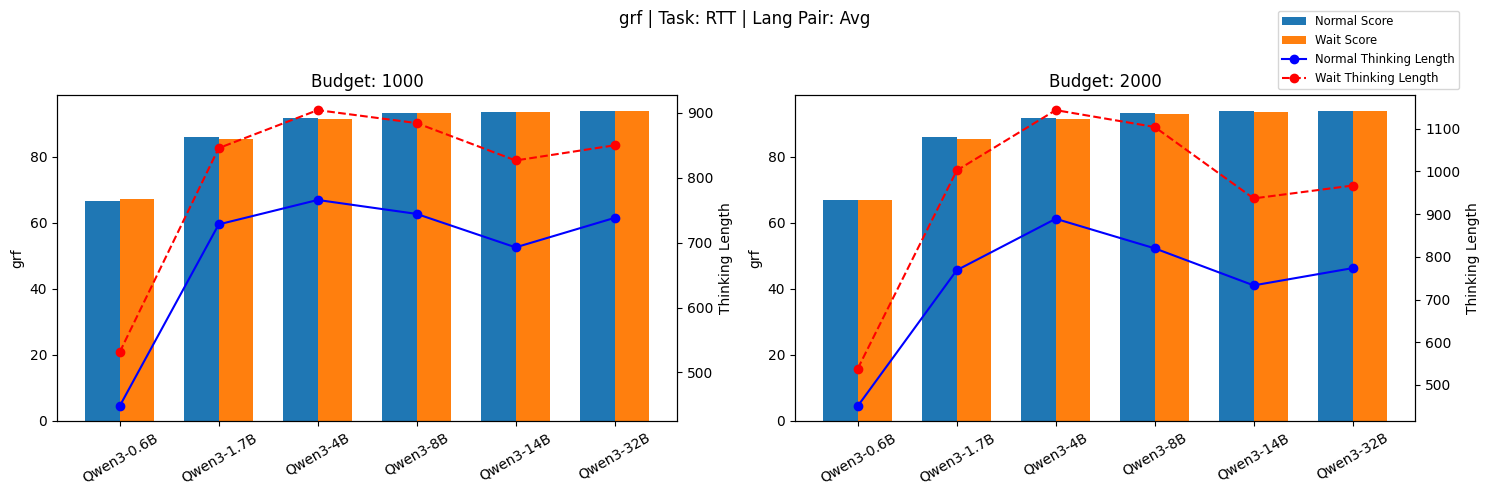

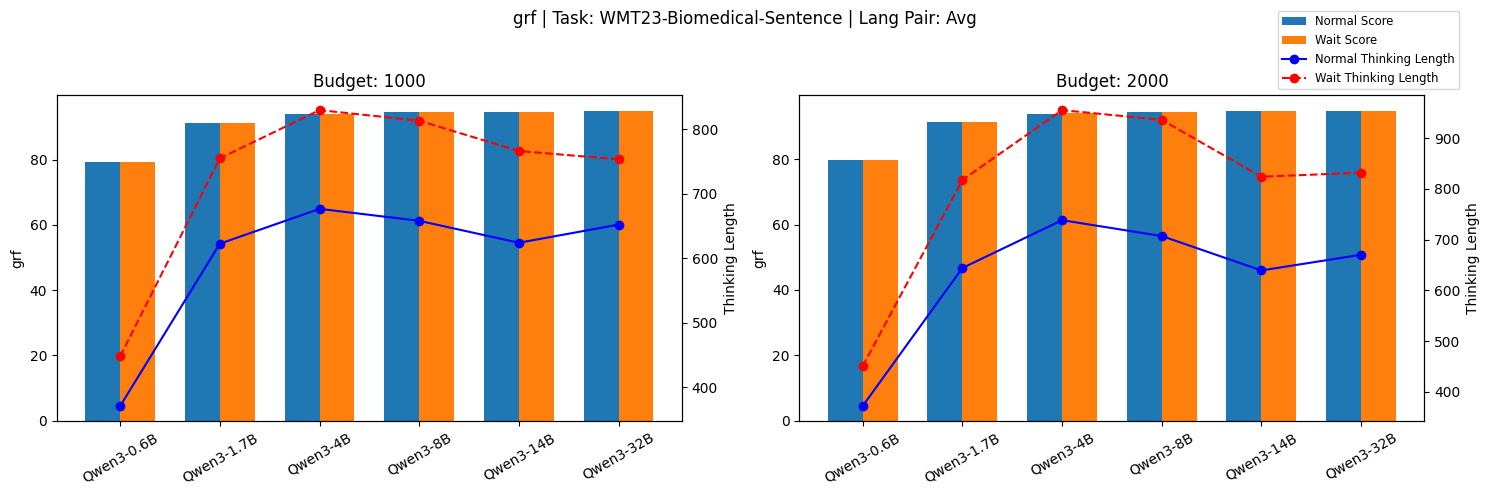

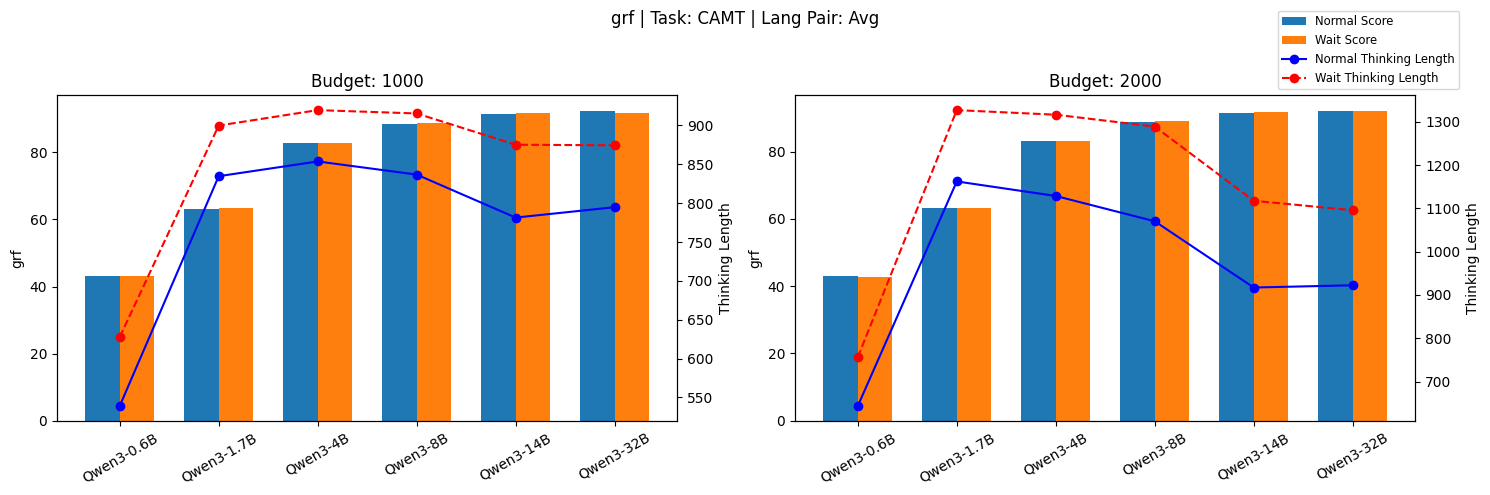

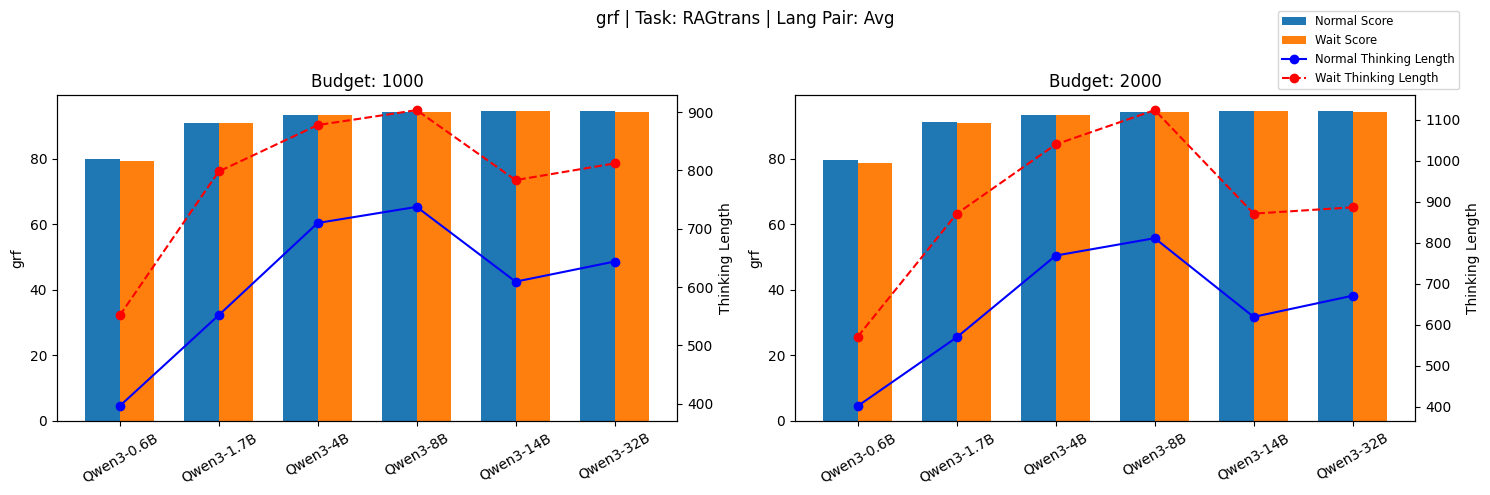

In [32]:
plot_metric_comparison("grf")

#### GEA-5

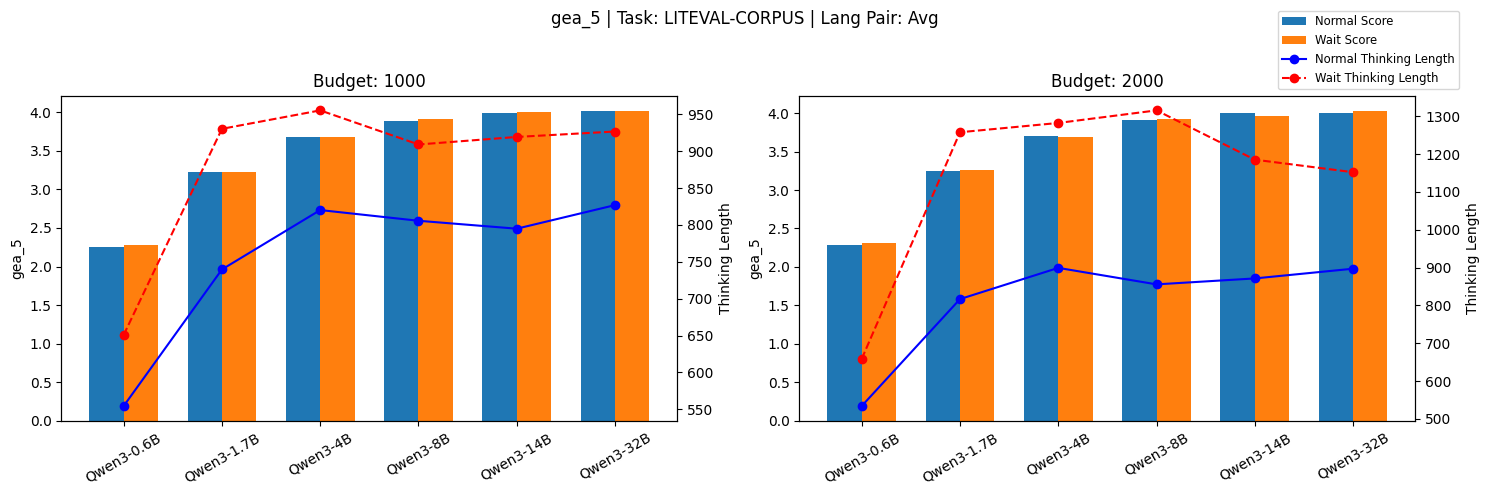

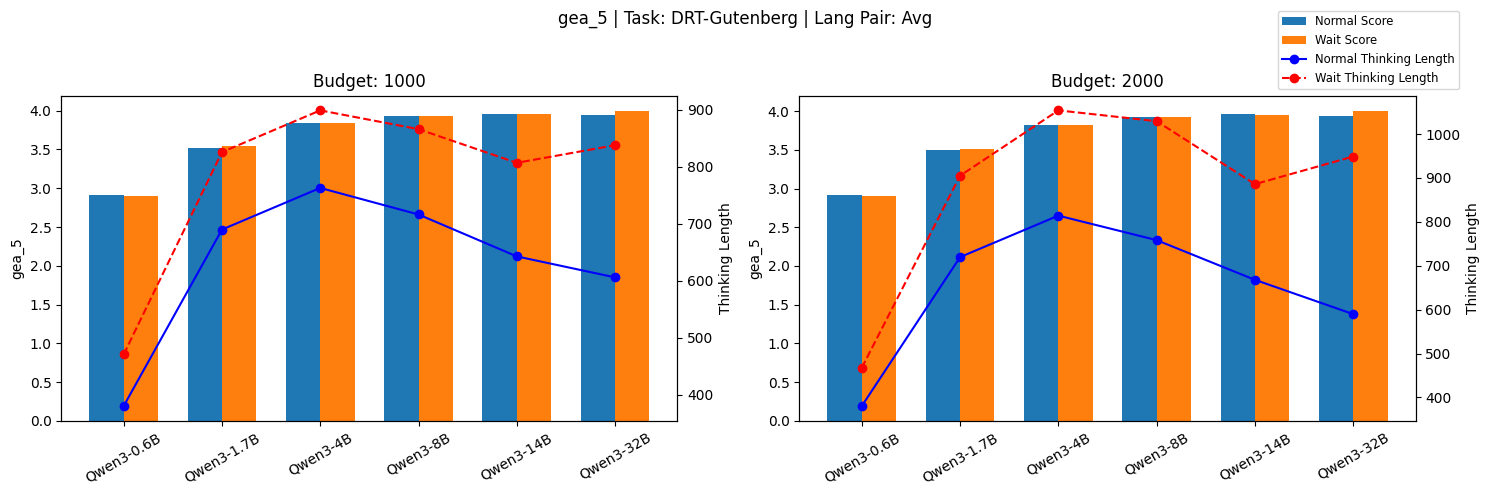

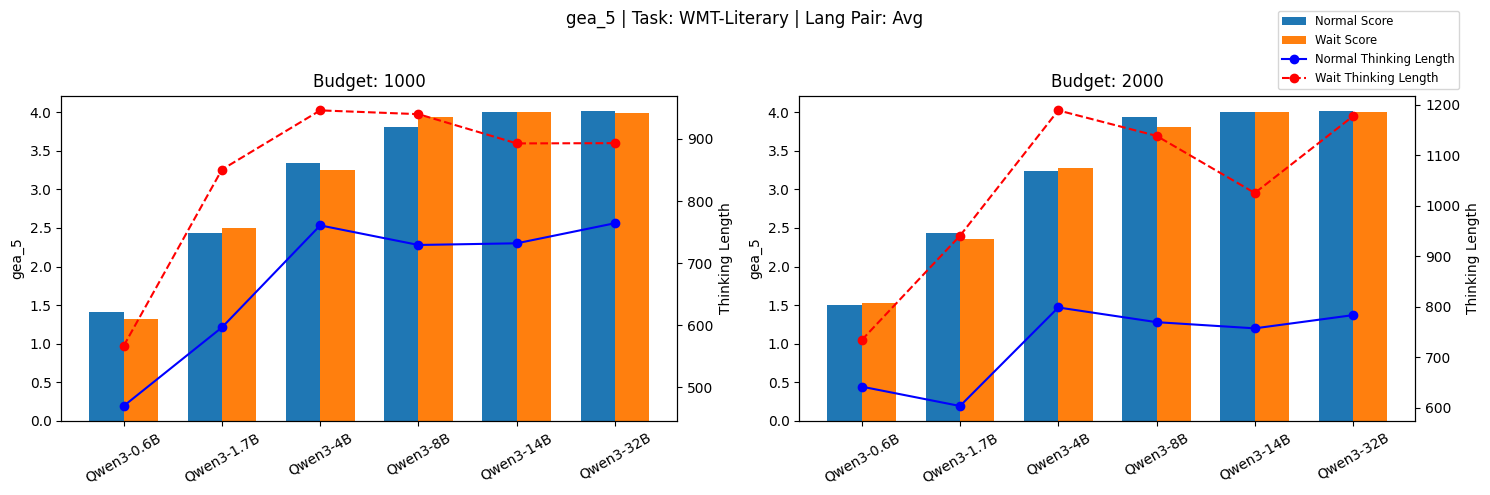

In [33]:
plot_metric_comparison("gea_5")

#### GEA-100

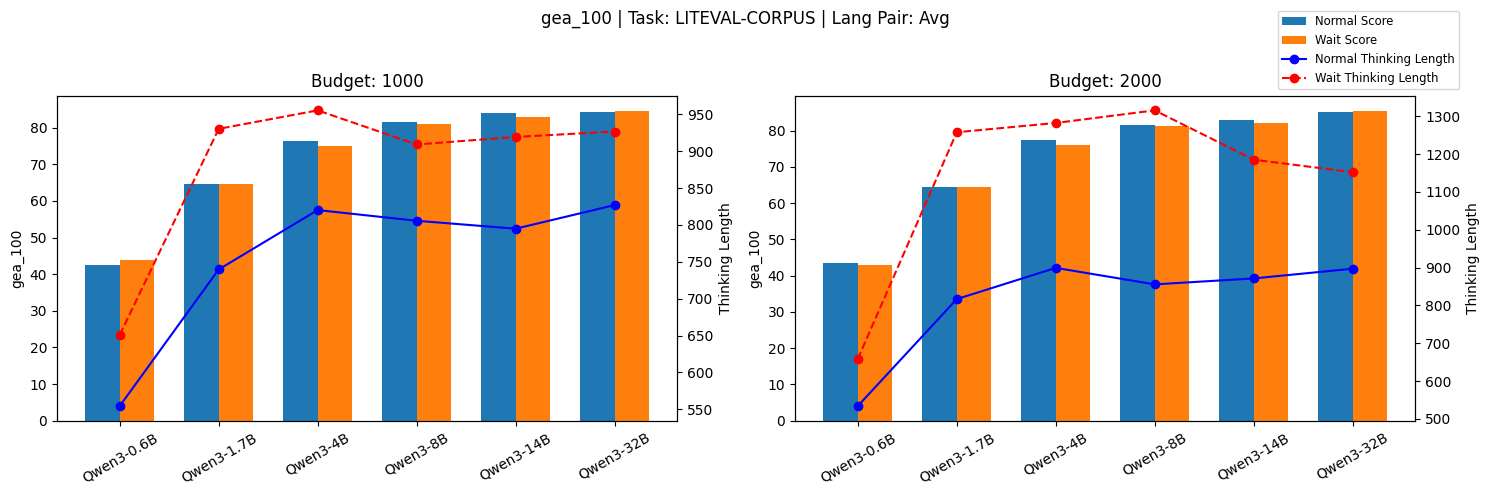

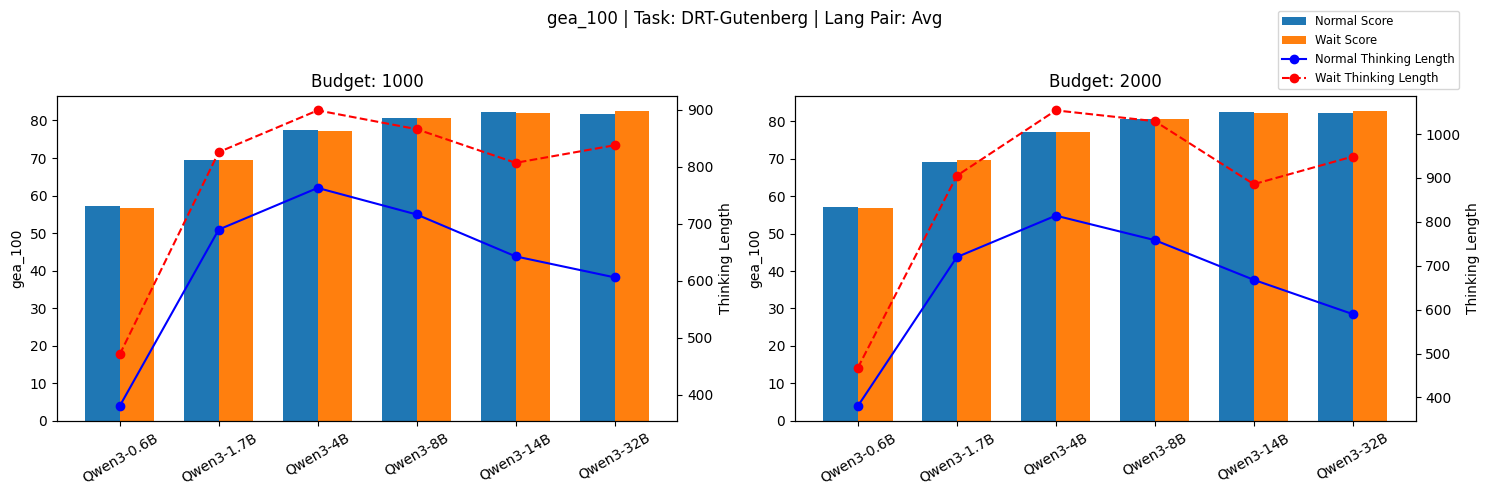

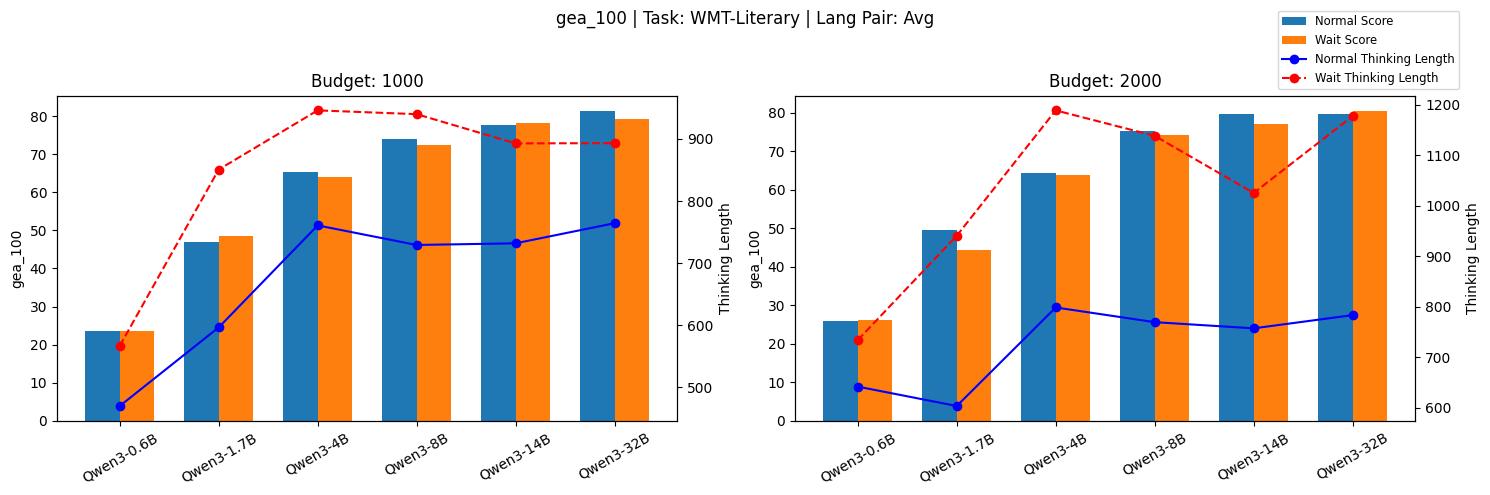

In [34]:
plot_metric_comparison("gea_100")

### Cogito-Llama

#### Comet

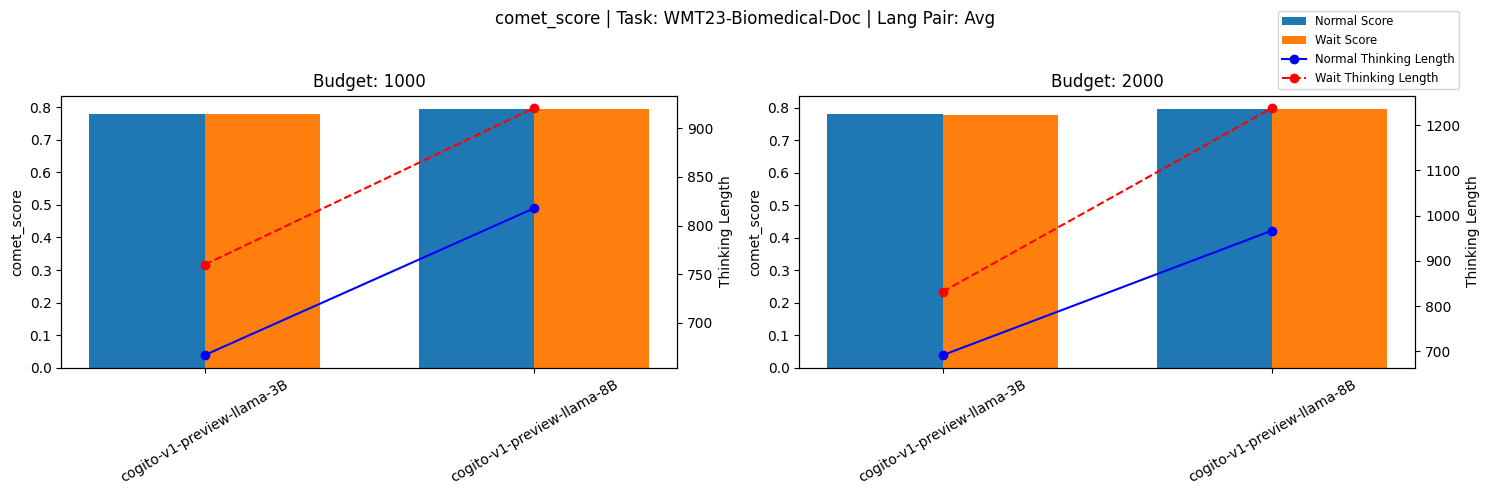

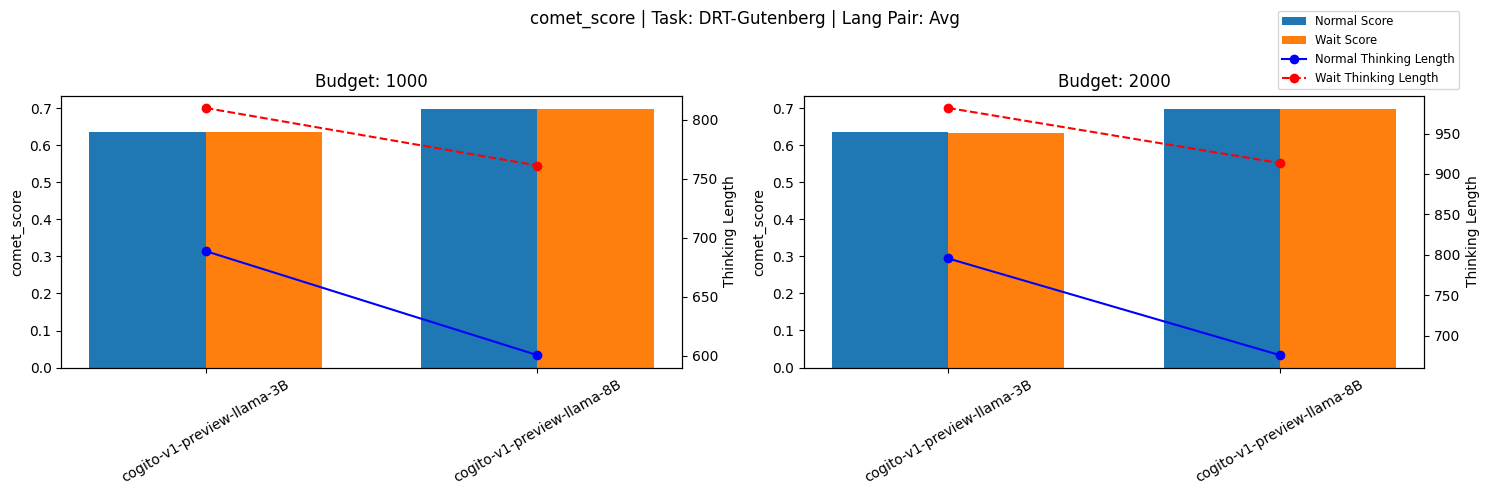

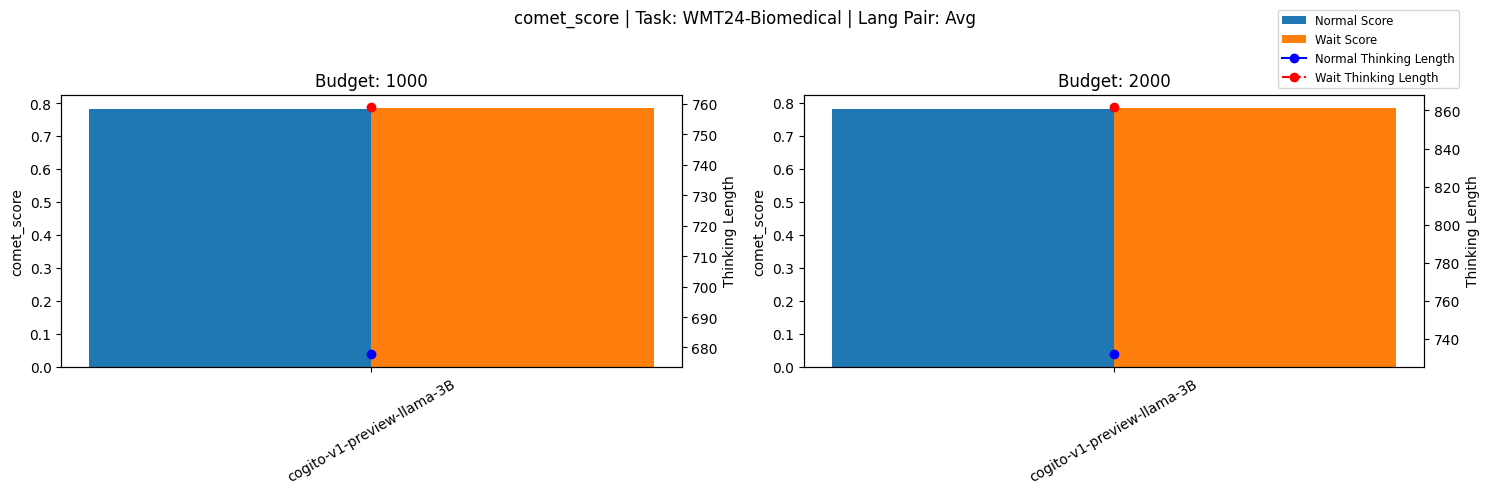

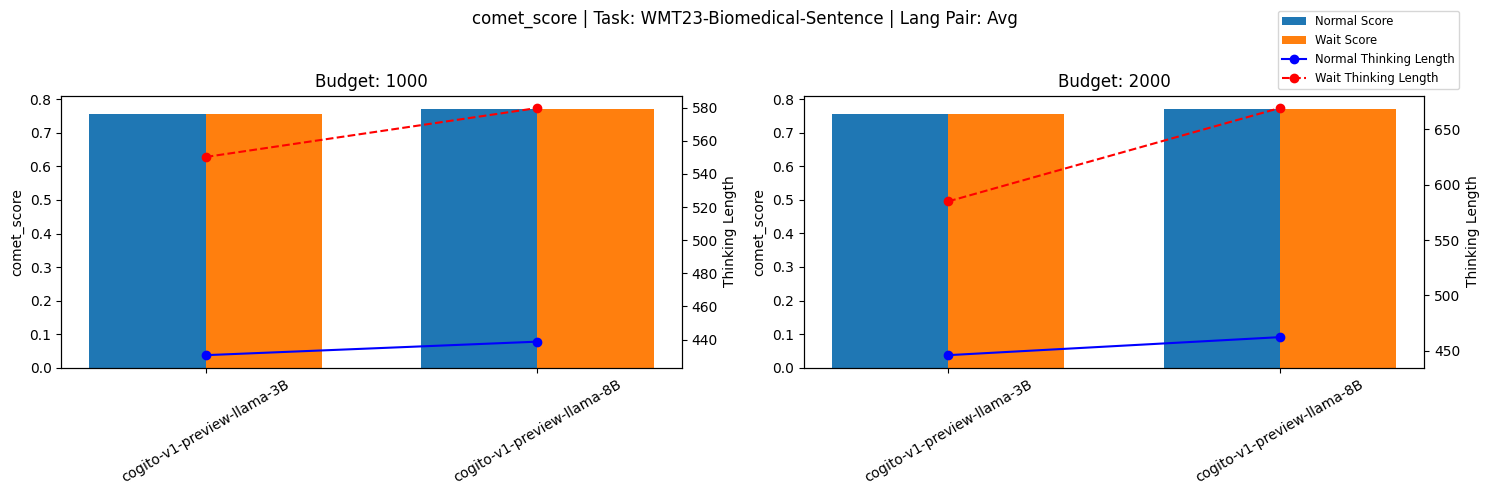

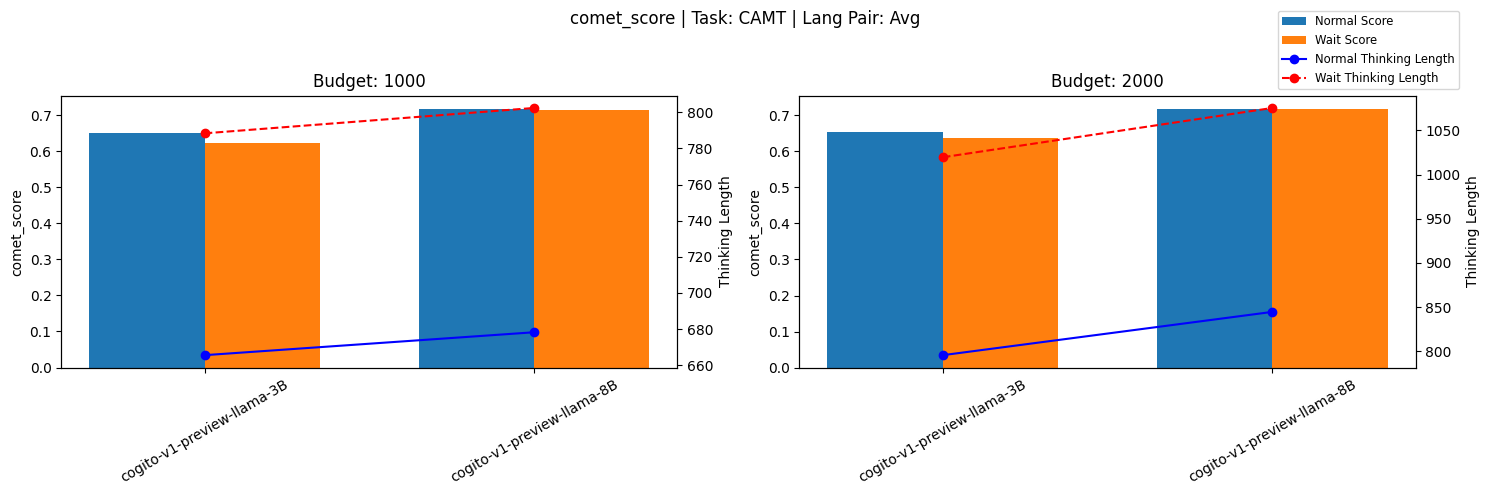

In [36]:
plot_metric_comparison(
    "comet_score", exclude_models=["Qwen3-0.6B", "Qwen3-1.7B", "Qwen3-4B", "Qwen3-8B", "Qwen3-14B", "Qwen3-32B"]
)

#### CometKiwi

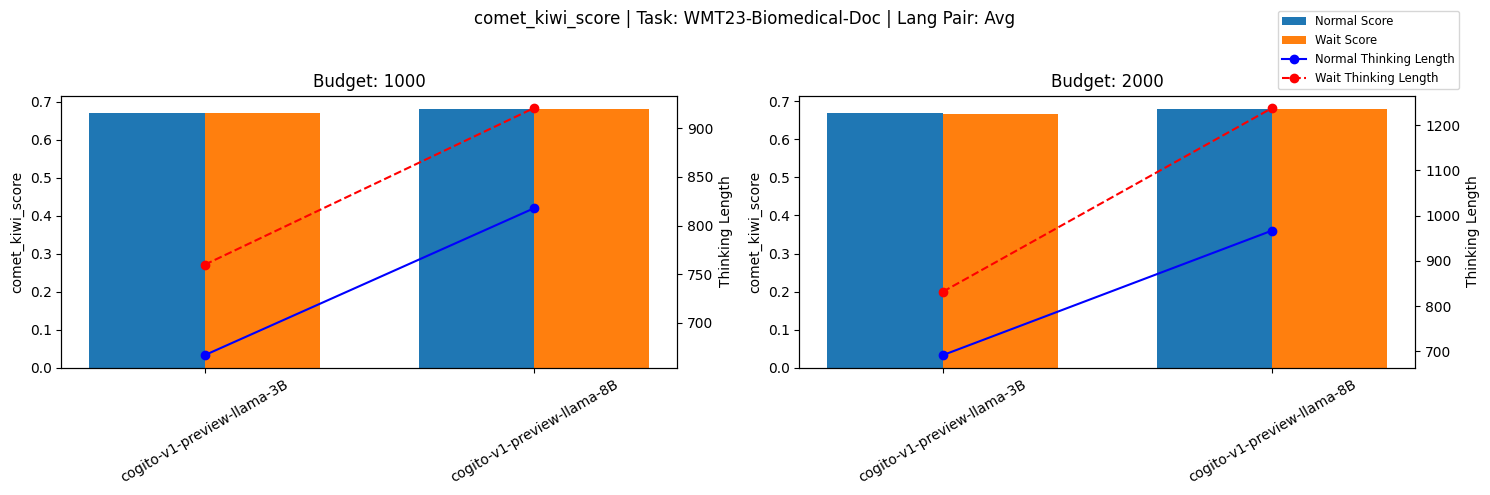

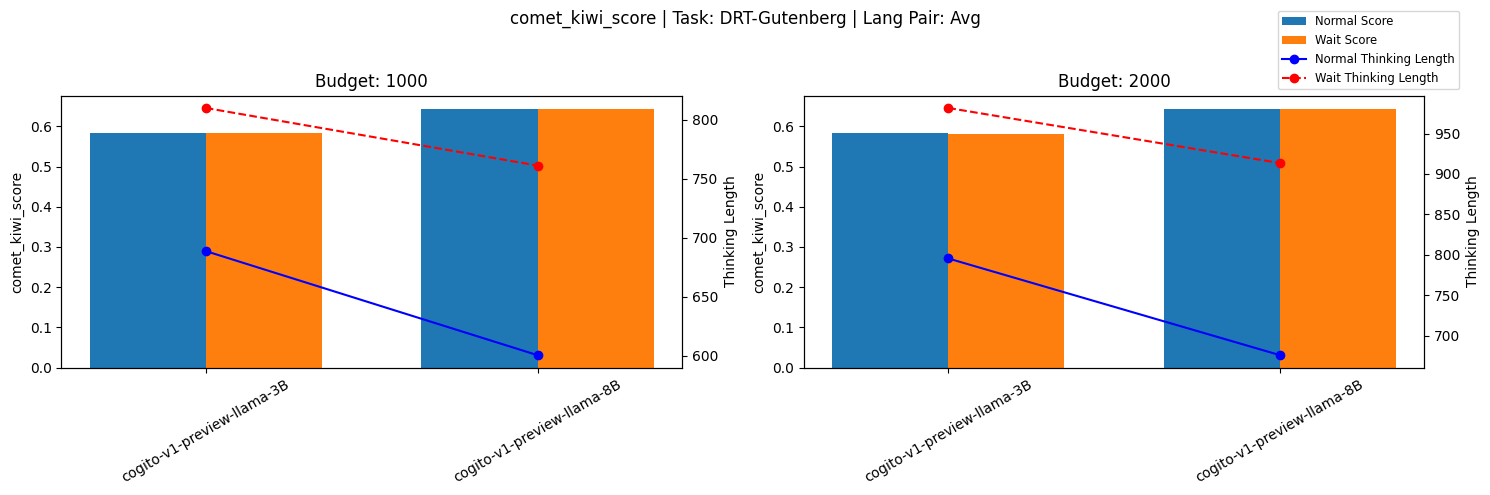

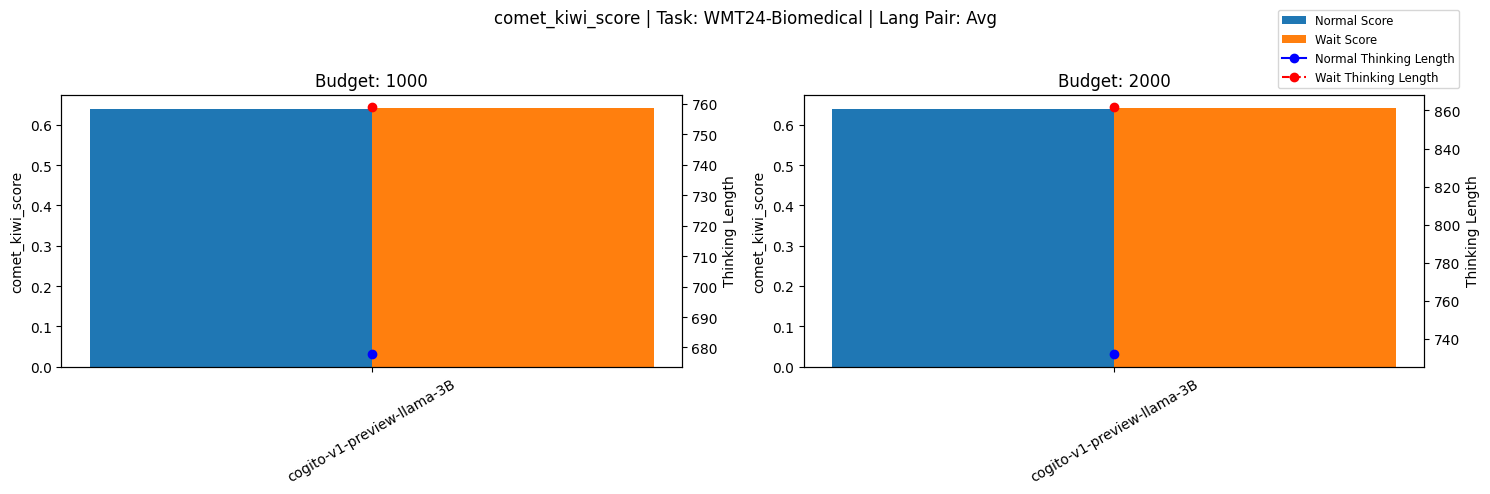

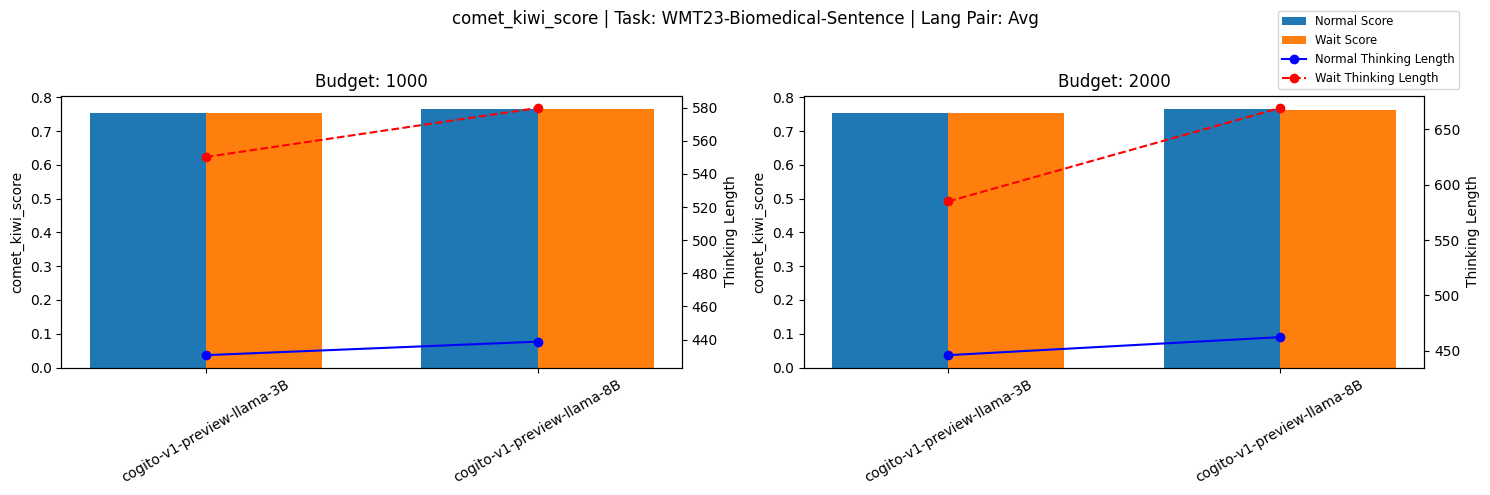

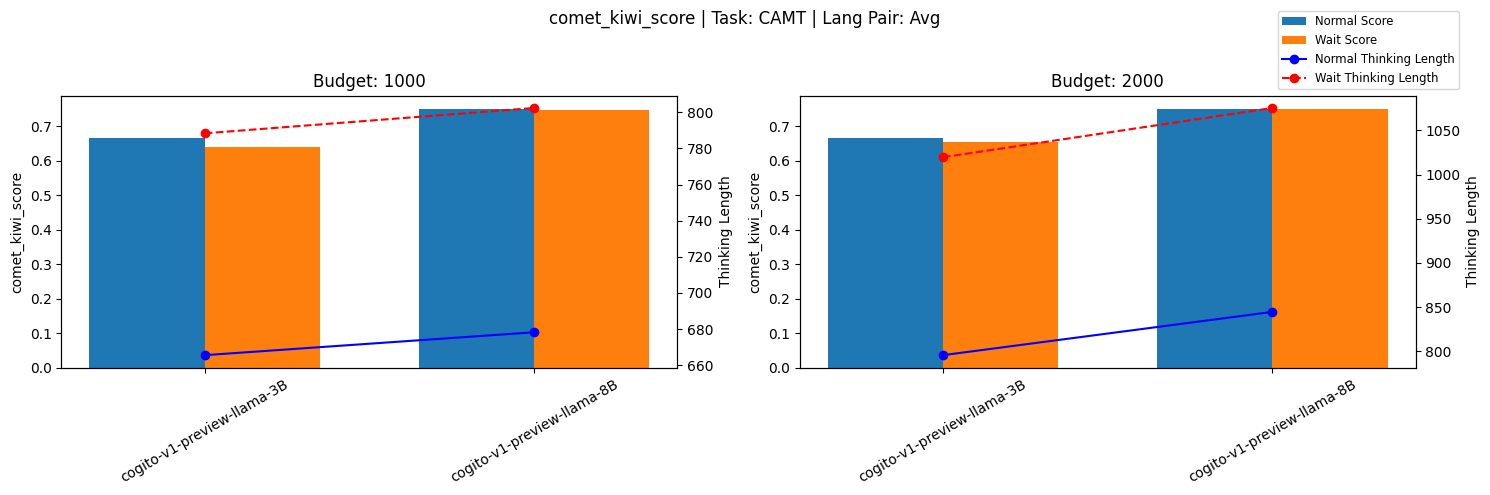

In [37]:
plot_metric_comparison(
    "comet_kiwi_score",
    exclude_models=[
        "Qwen3-0.6B",
        "Qwen3-1.7B",
        "Qwen3-4B",
        "Qwen3-8B",
        "Qwen3-14B",
        "Qwen3-32B",
    ],
)

#### GRB

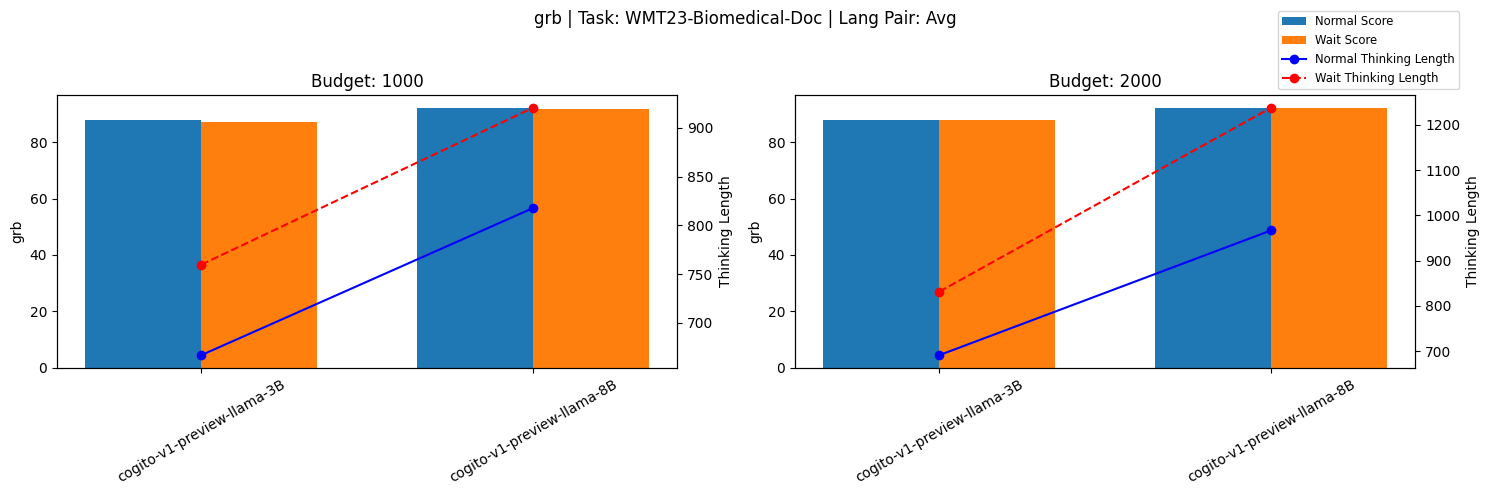

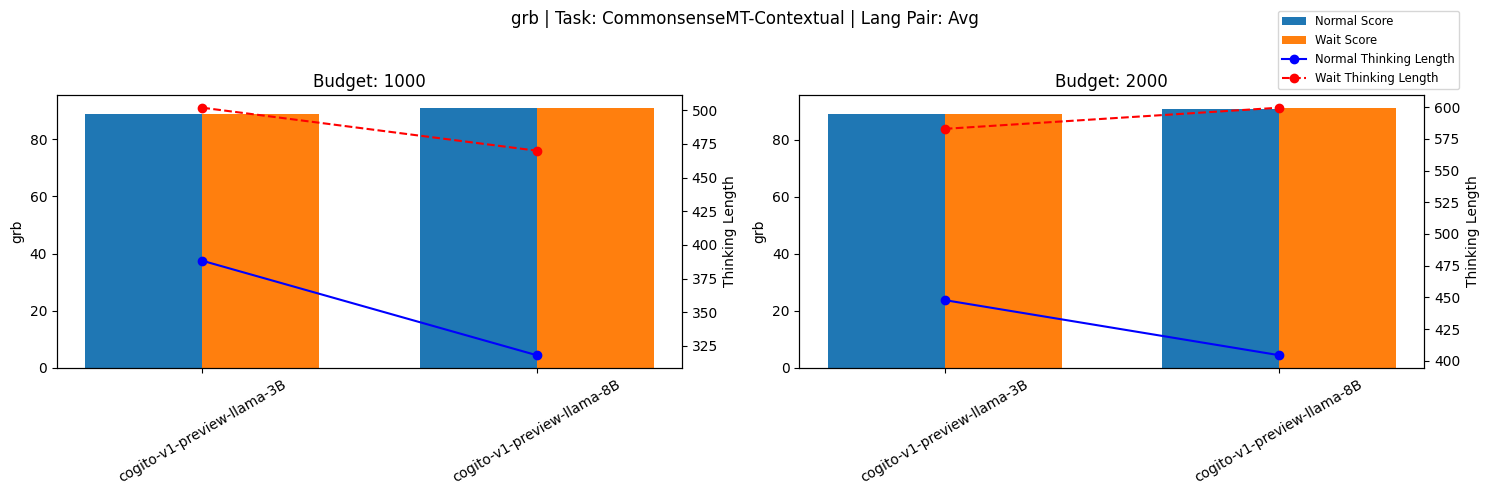

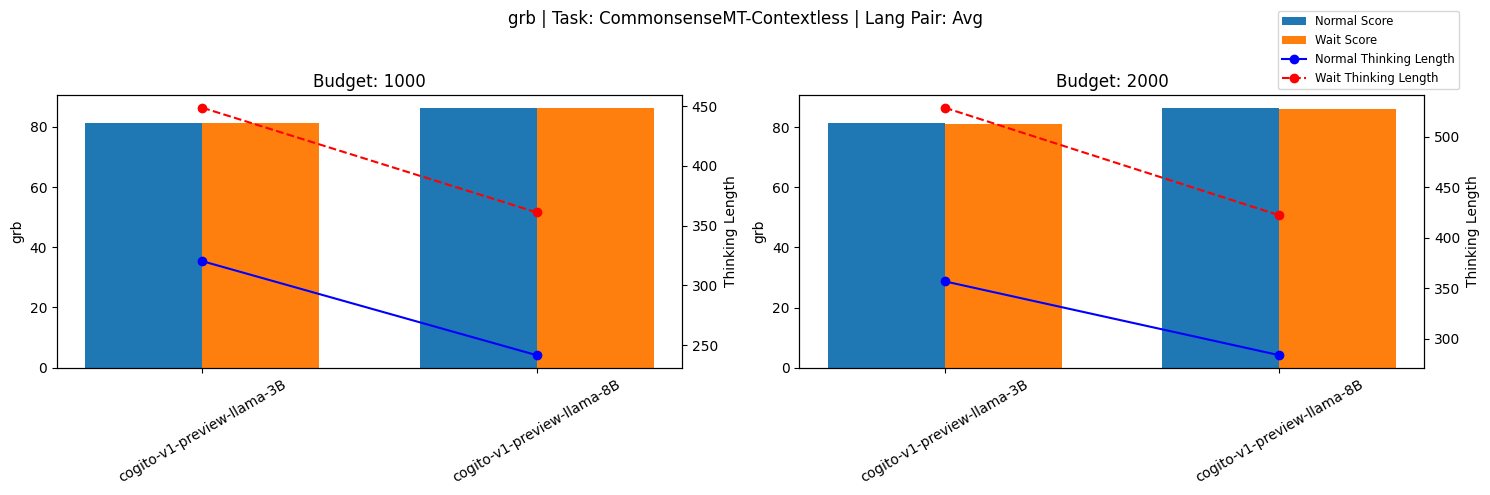

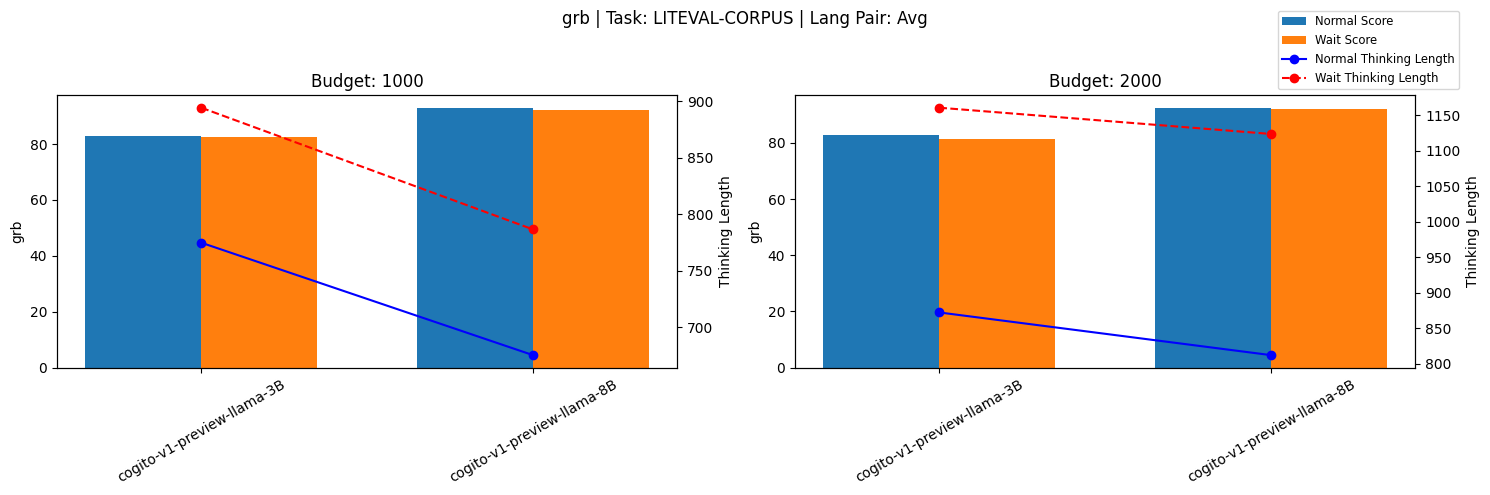

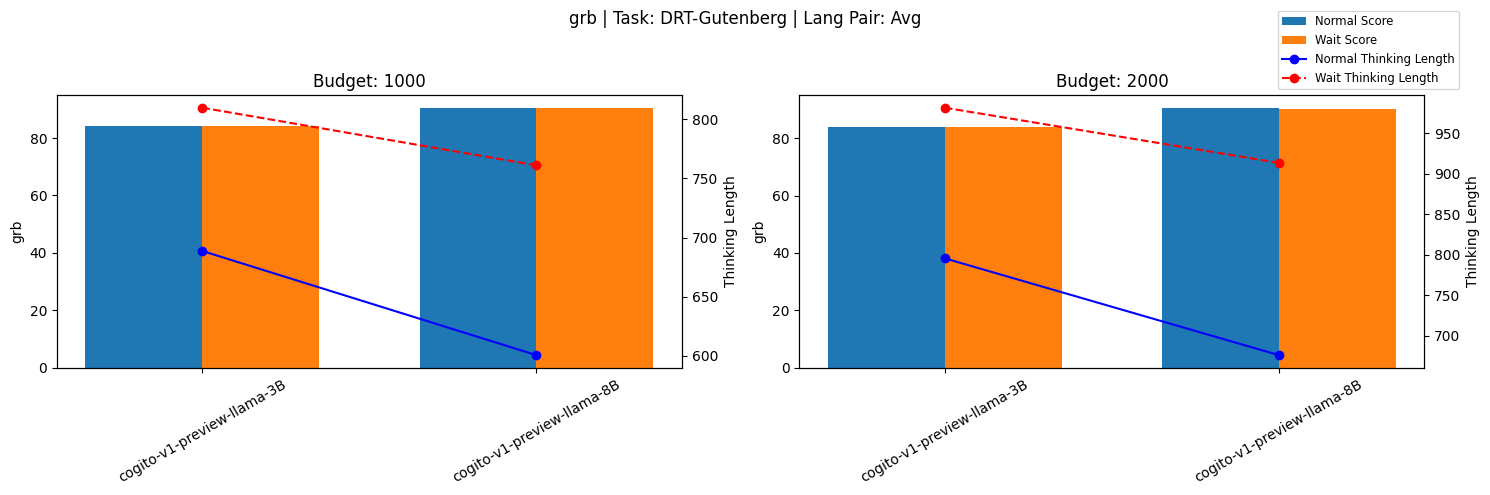

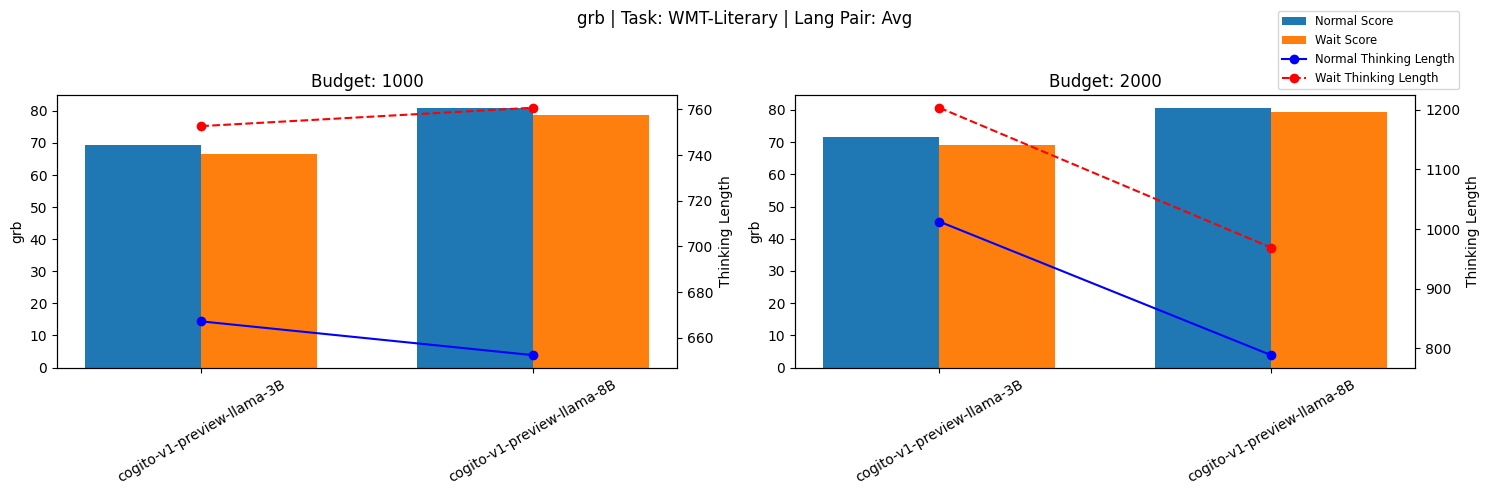

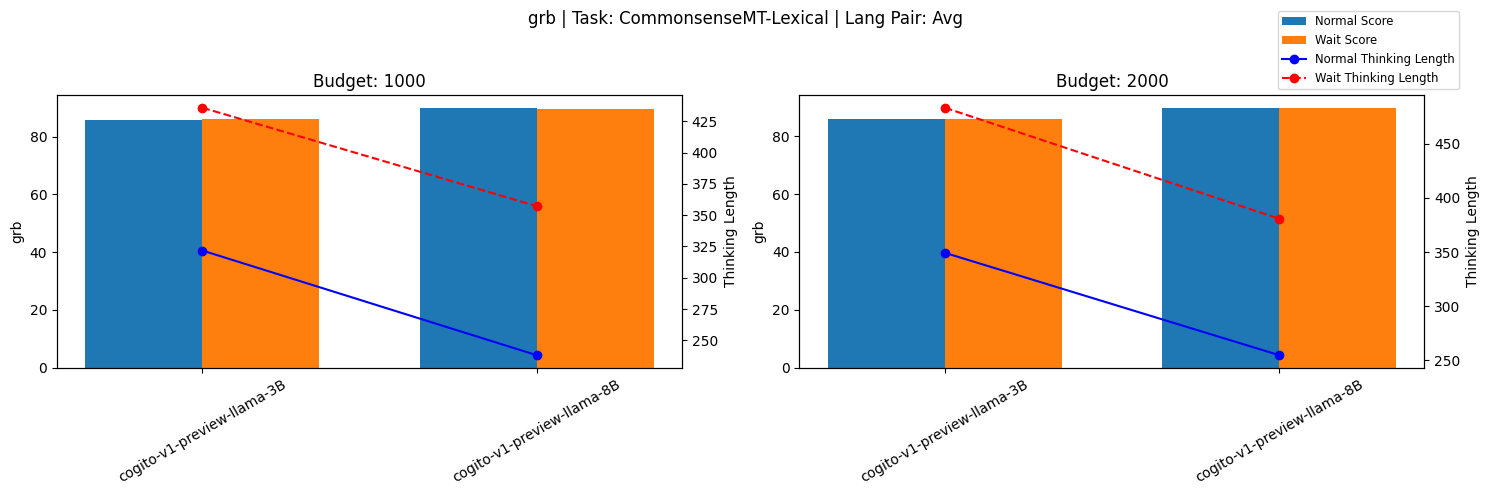

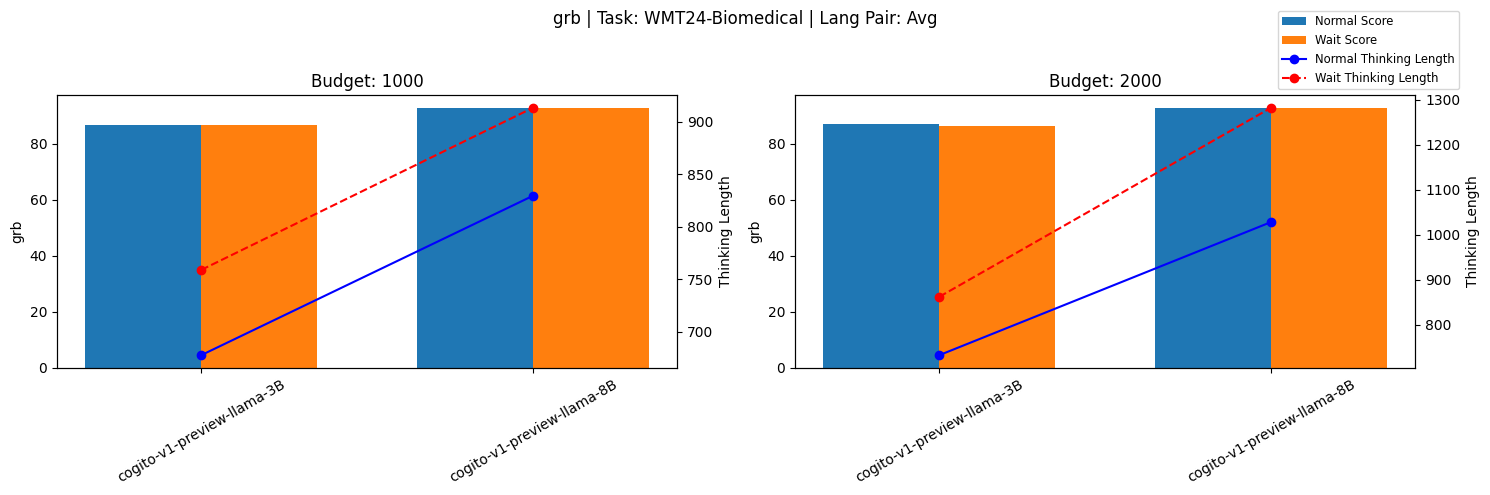

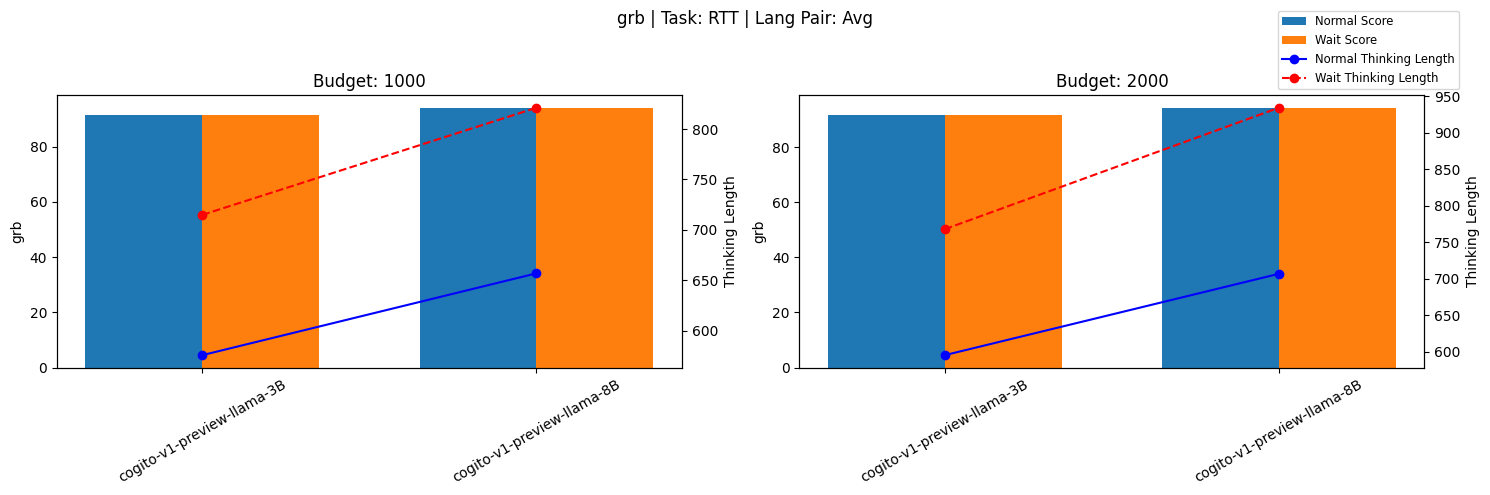

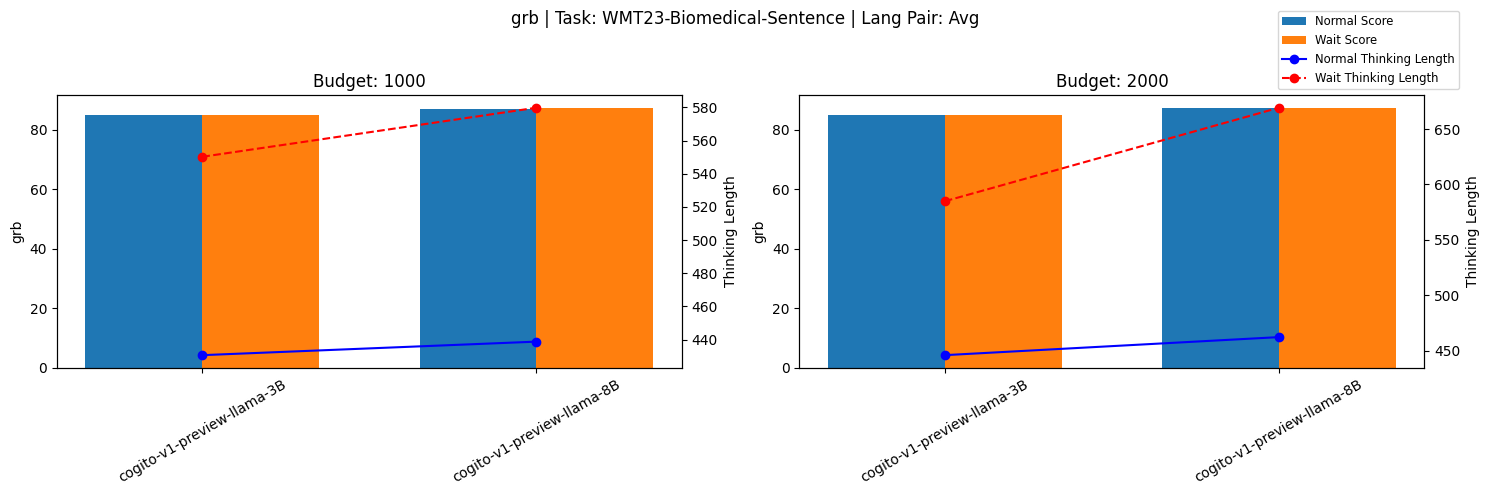

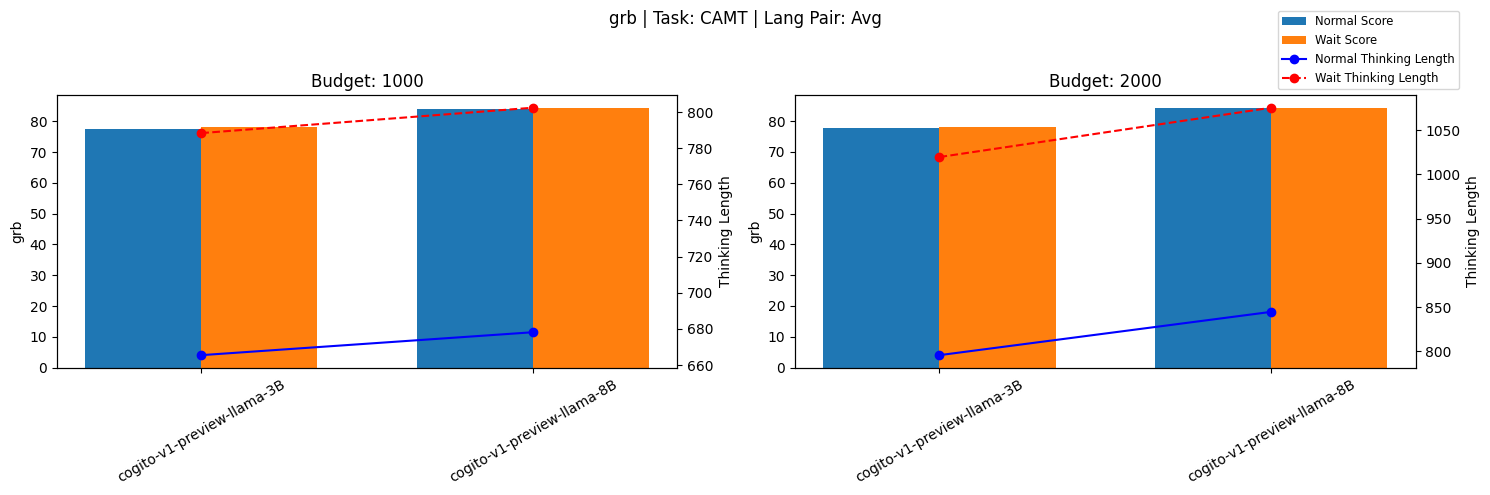

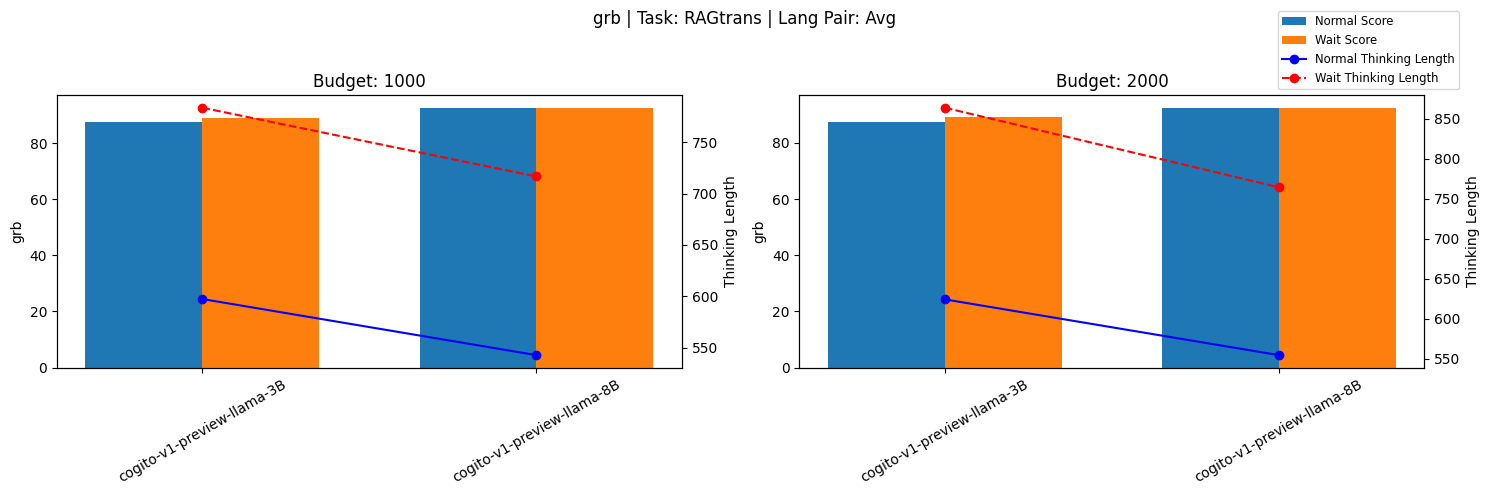

In [38]:
plot_metric_comparison(
    "grb",
    exclude_models=[
        "Qwen3-0.6B",
        "Qwen3-1.7B",
        "Qwen3-4B",
        "Qwen3-8B",
        "Qwen3-14B",
        "Qwen3-32B",
    ],
)

#### GRF

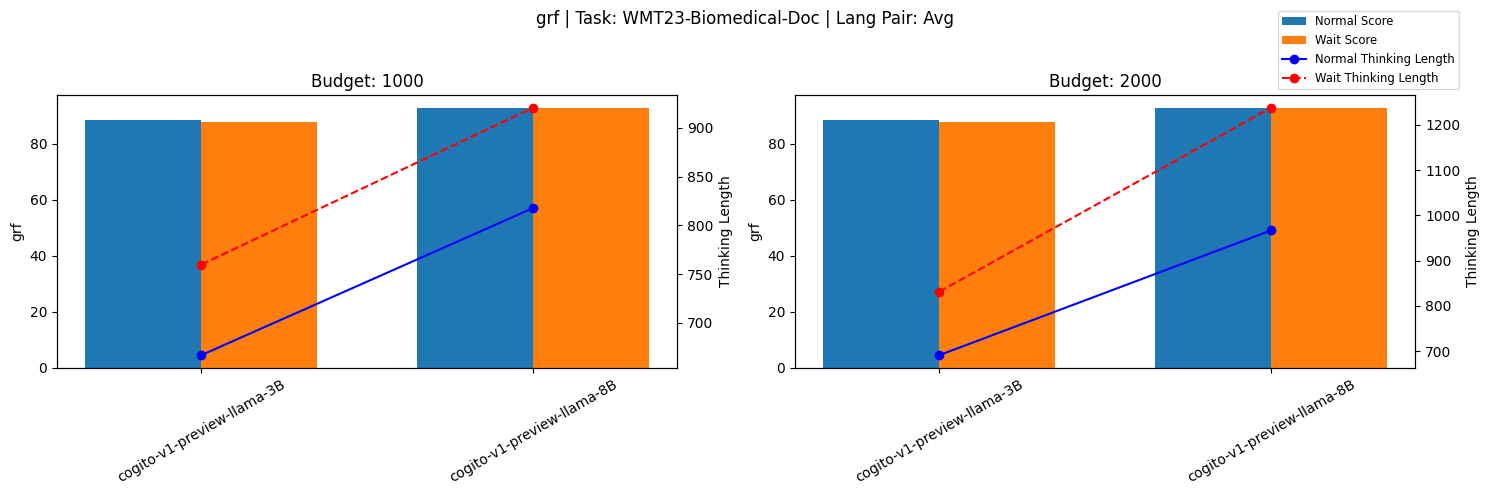

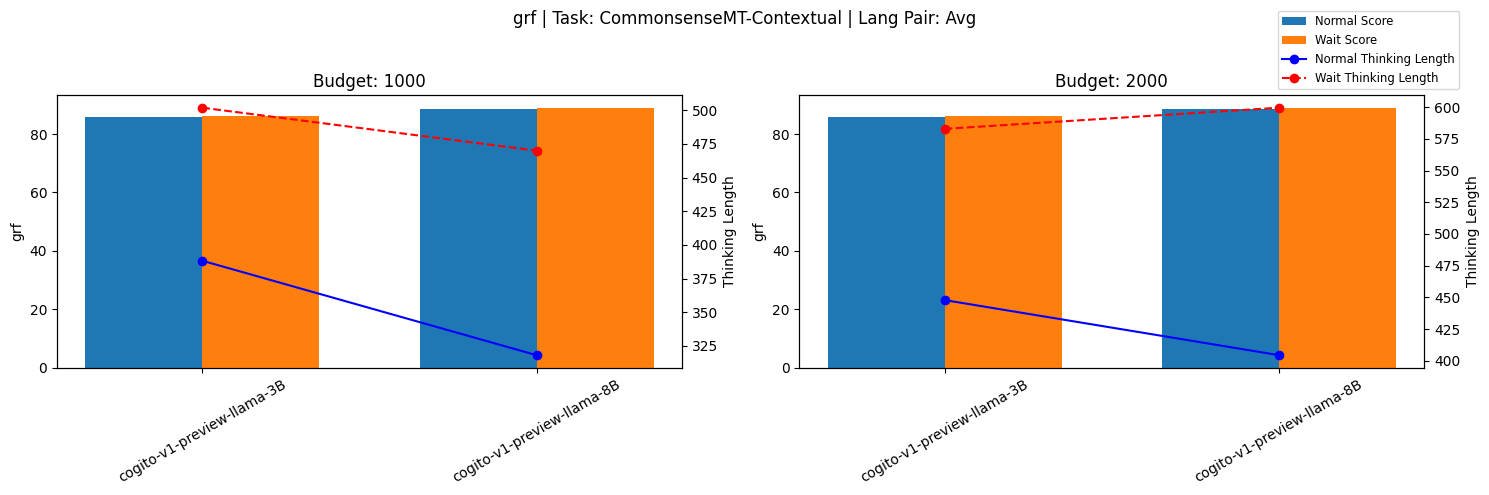

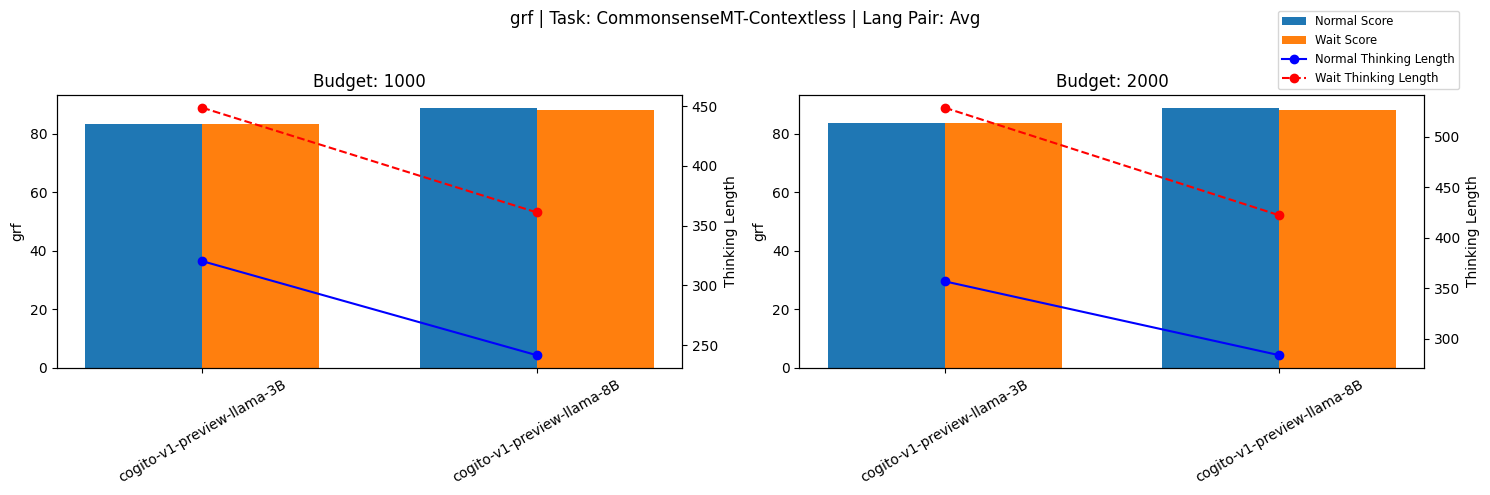

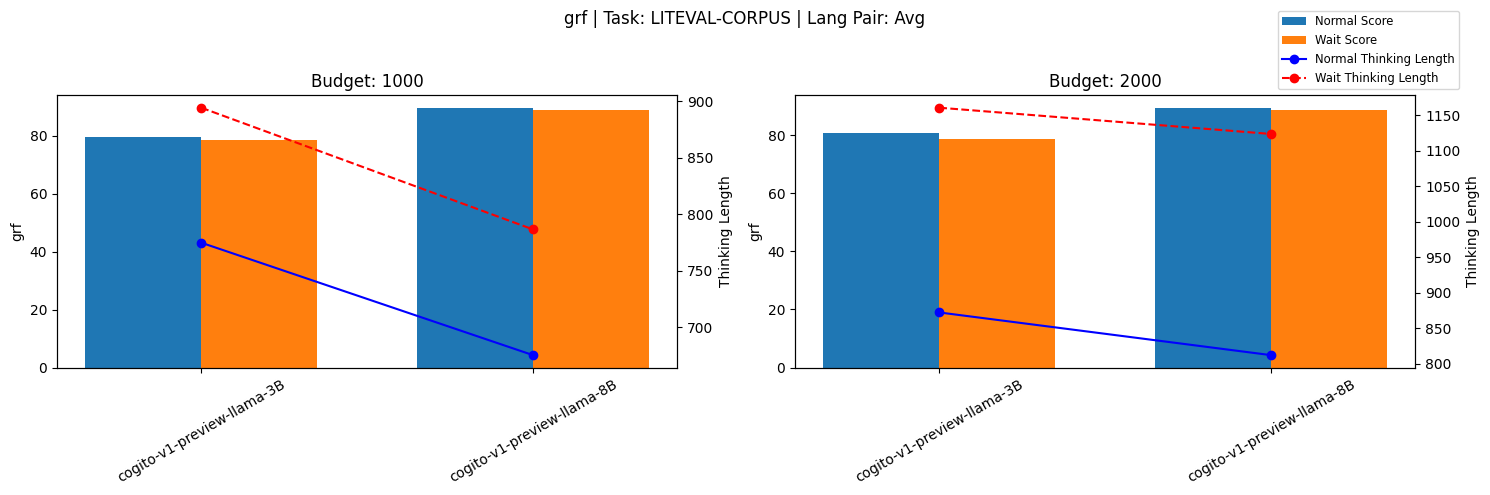

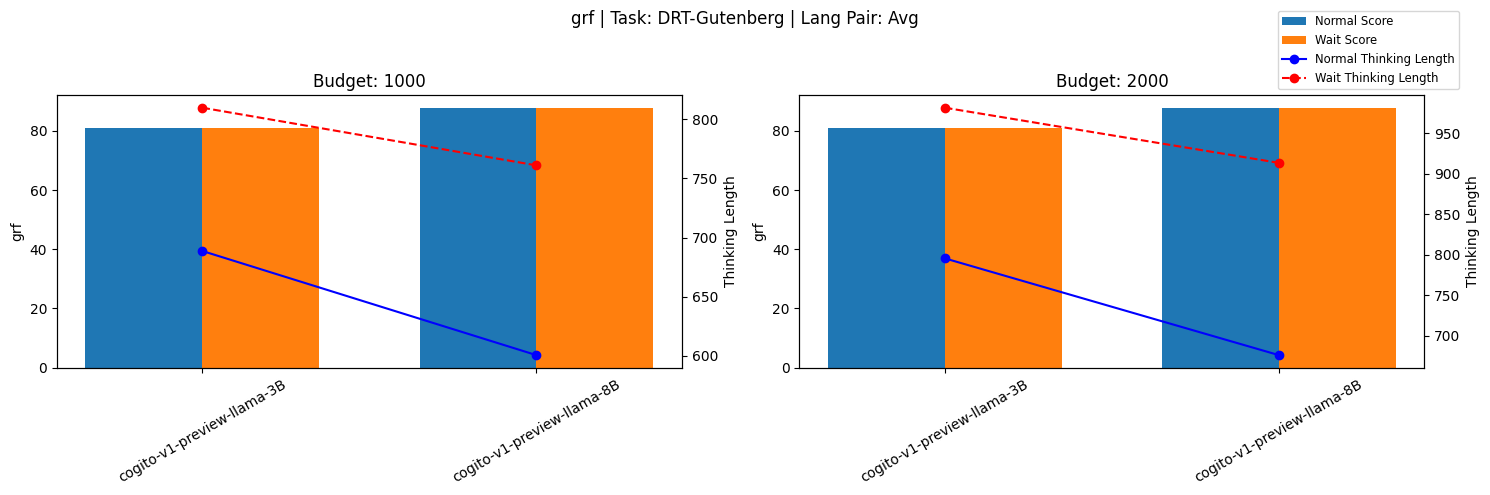

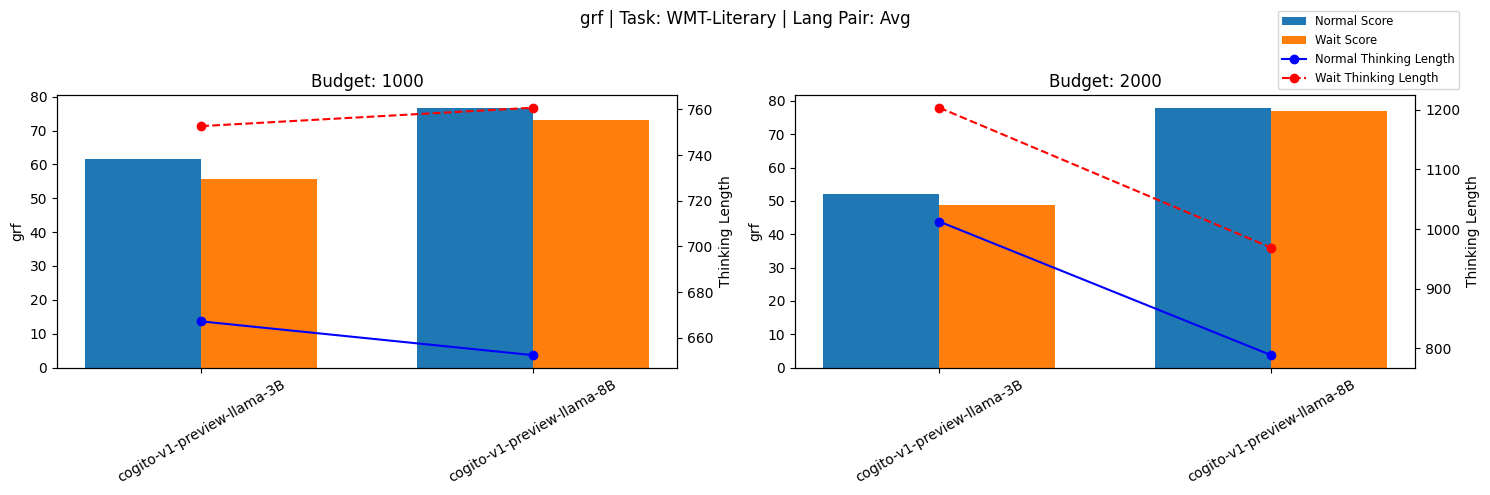

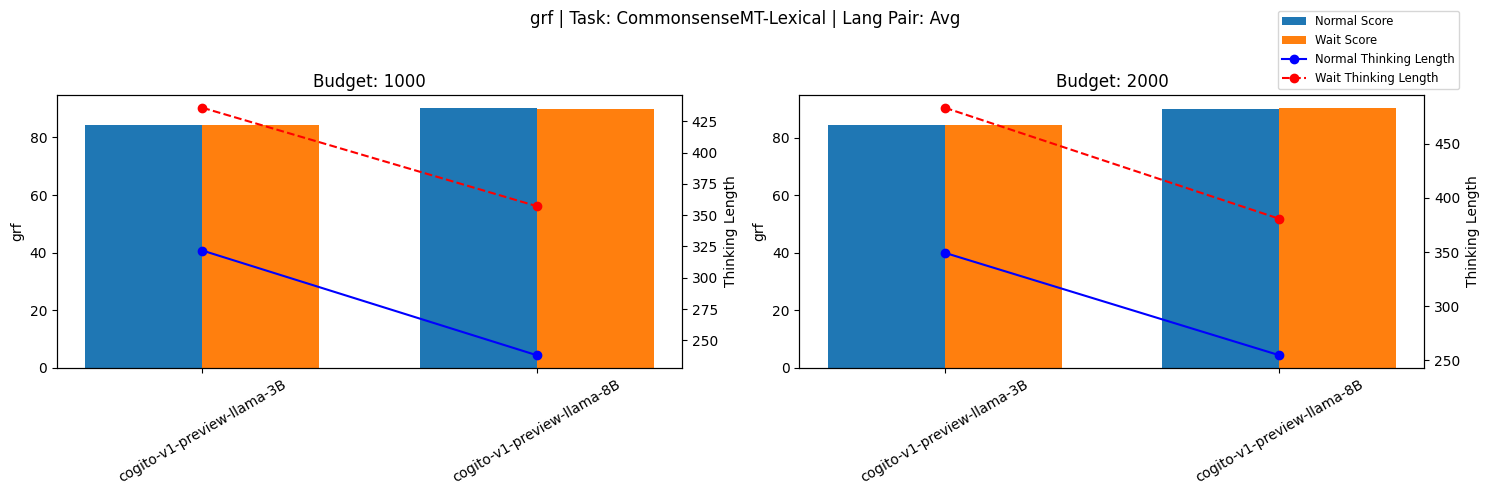

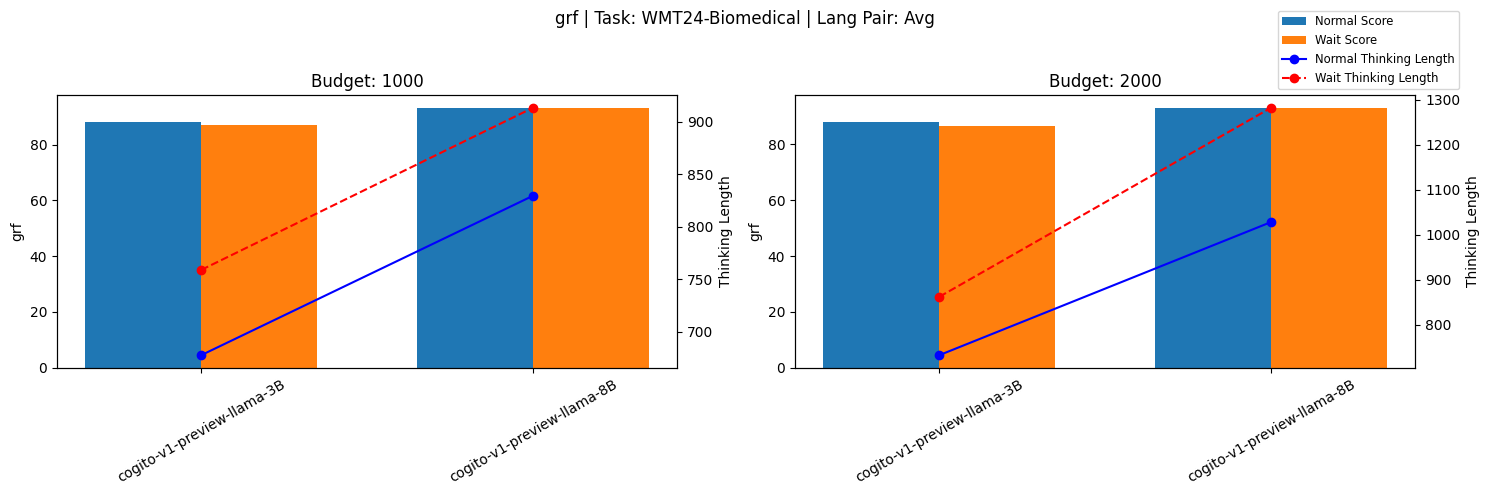

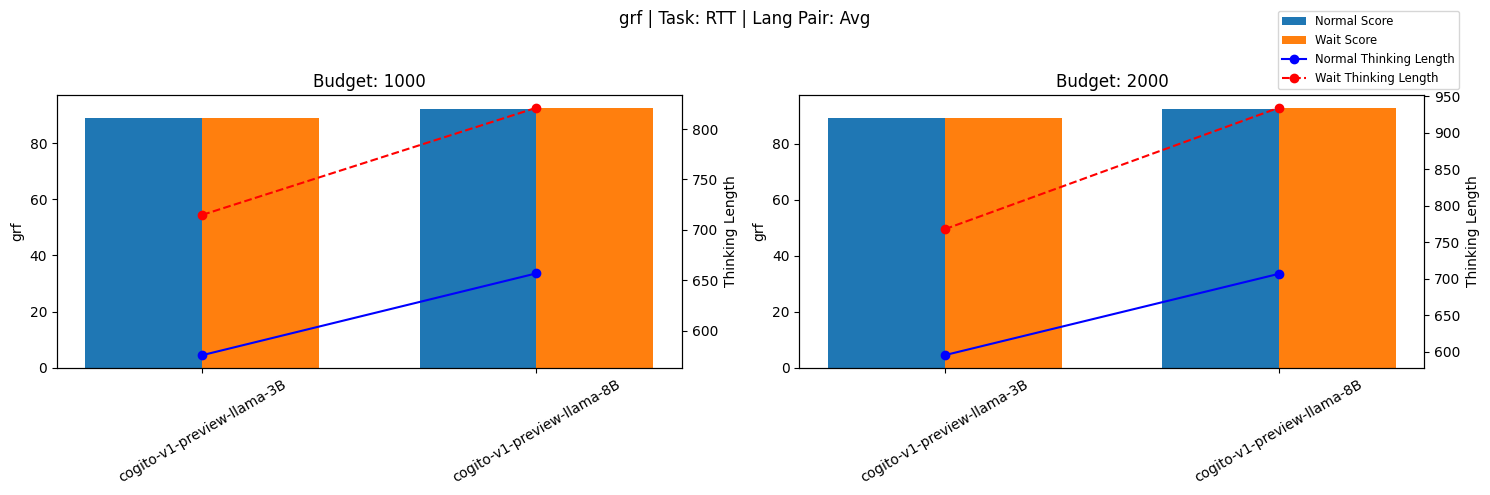

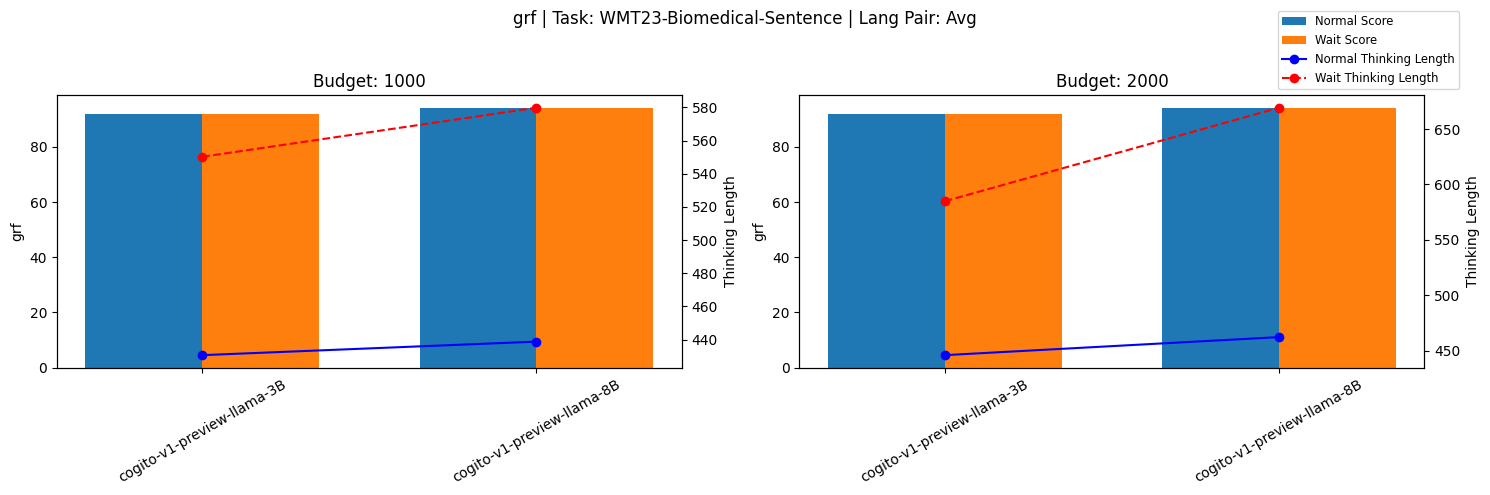

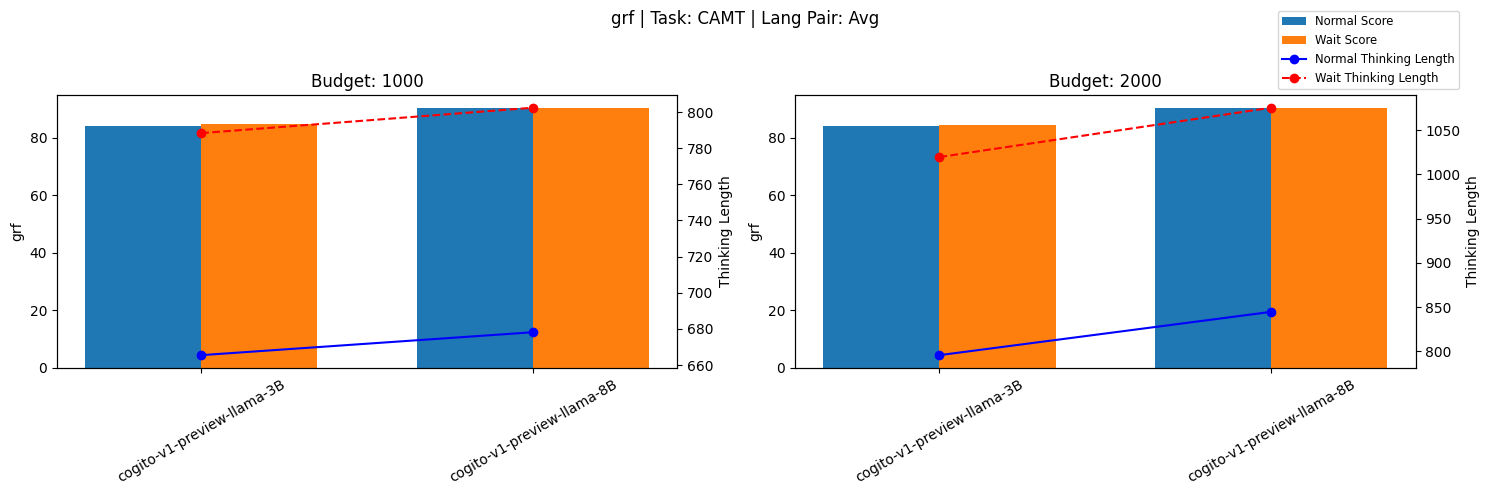

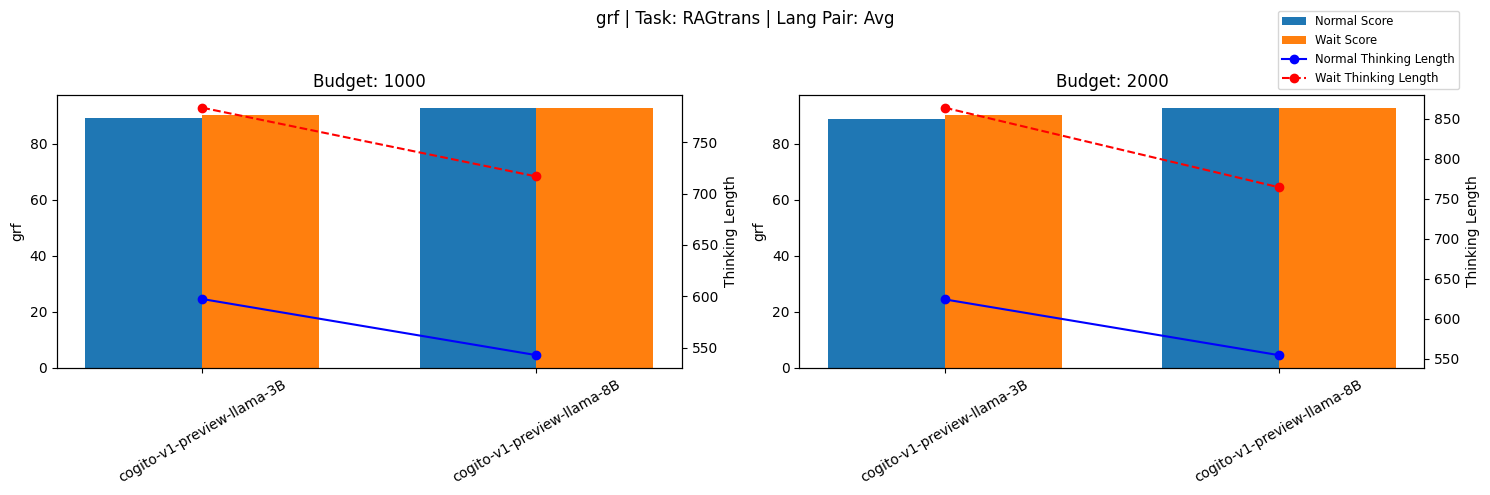

In [39]:
plot_metric_comparison(
    "grf",
    exclude_models=[
        "Qwen3-0.6B",
        "Qwen3-1.7B",
        "Qwen3-4B",
        "Qwen3-8B",
        "Qwen3-14B",
        "Qwen3-32B",
    ],
)

#### GEA-5

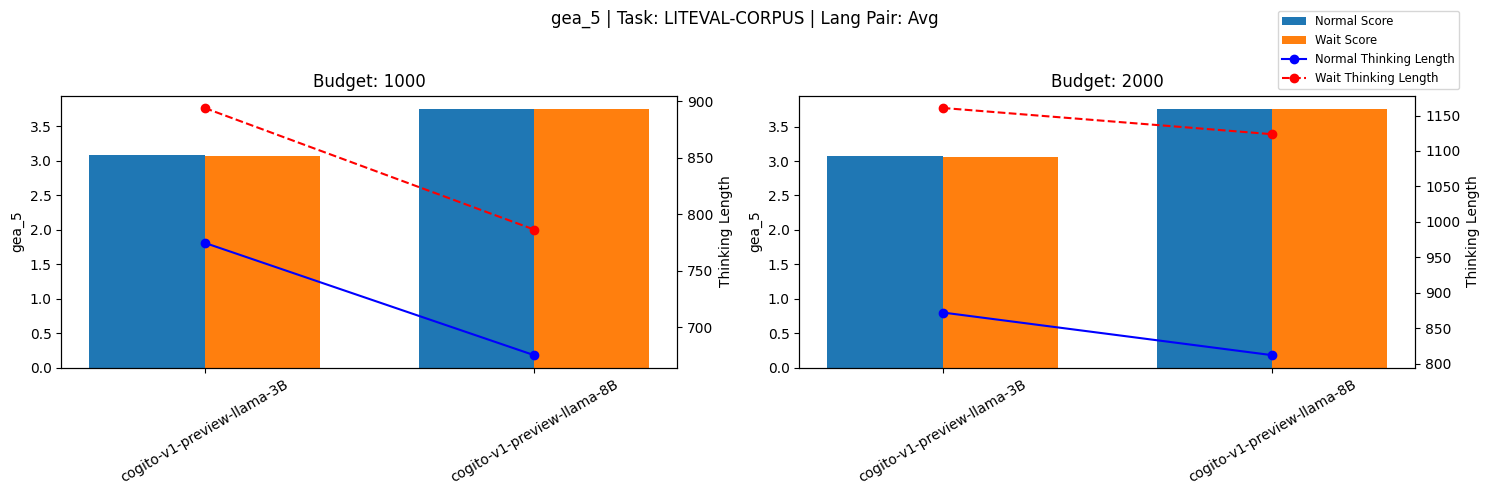

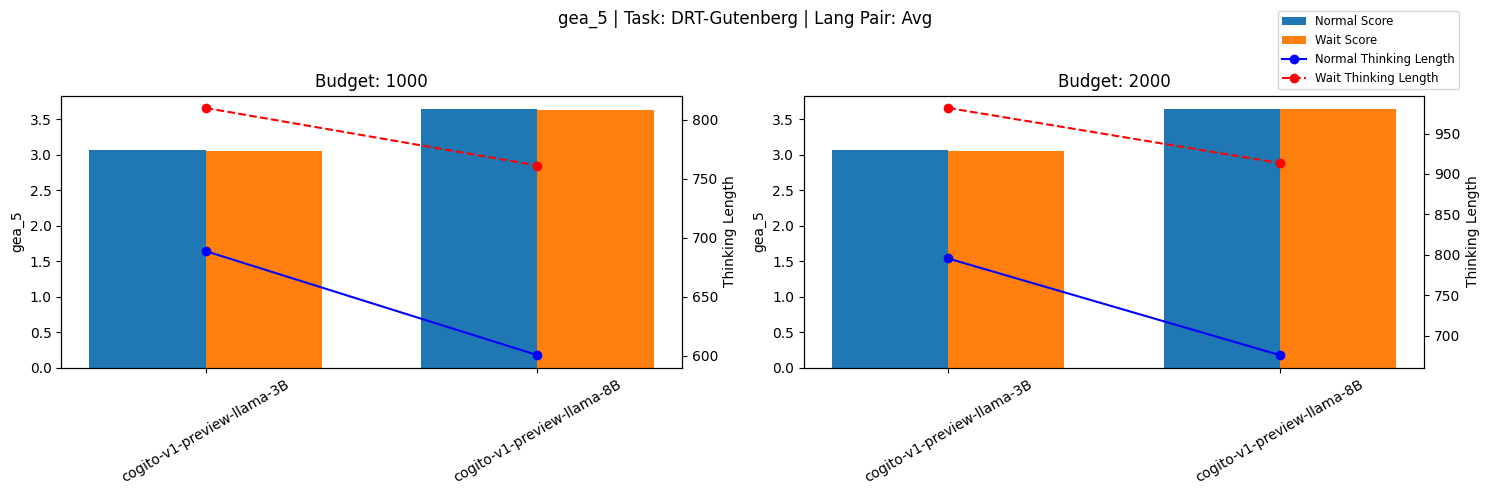

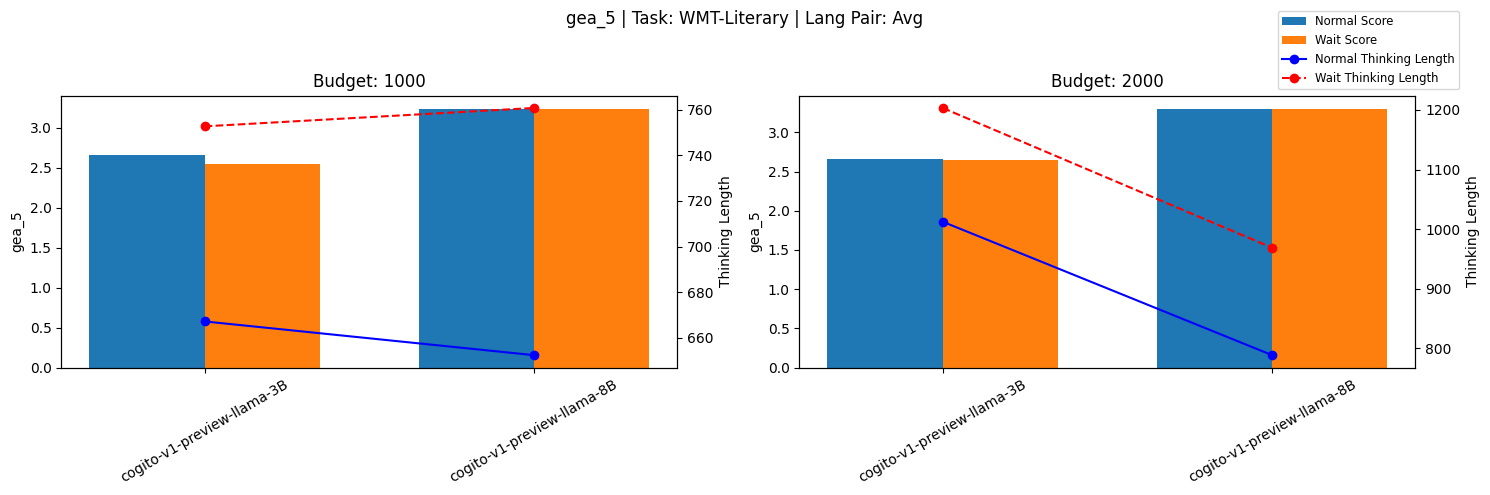

In [40]:
plot_metric_comparison(
    "gea_5",
    exclude_models=[
        "Qwen3-0.6B",
        "Qwen3-1.7B",
        "Qwen3-4B",
        "Qwen3-8B",
        "Qwen3-14B",
        "Qwen3-32B",
    ],
)

#### GEA-100

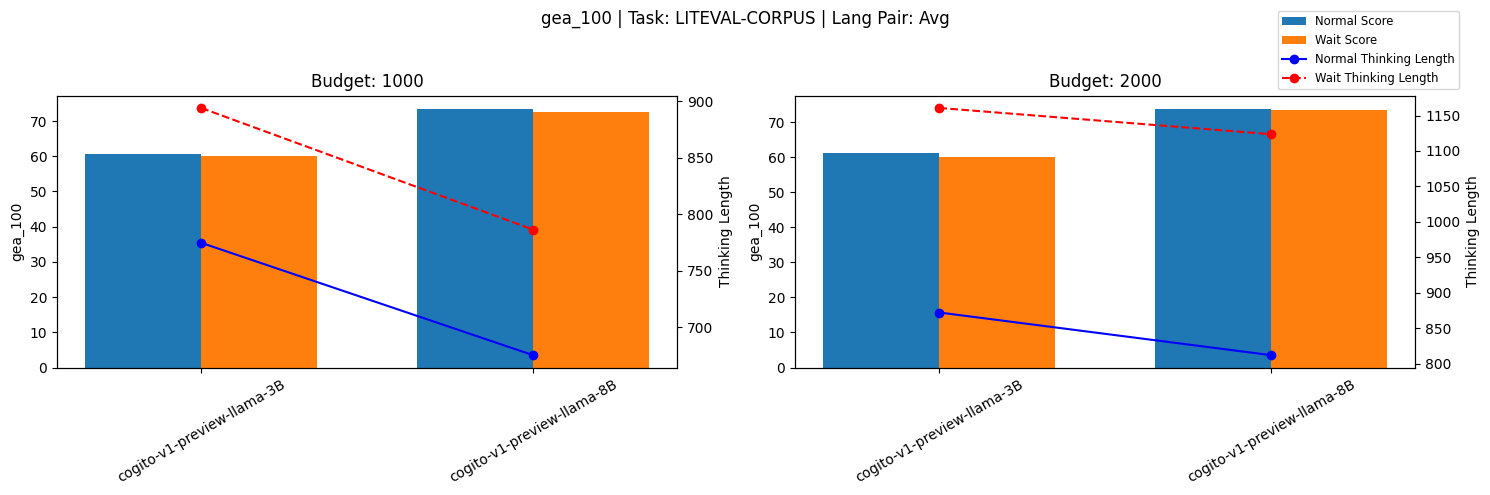

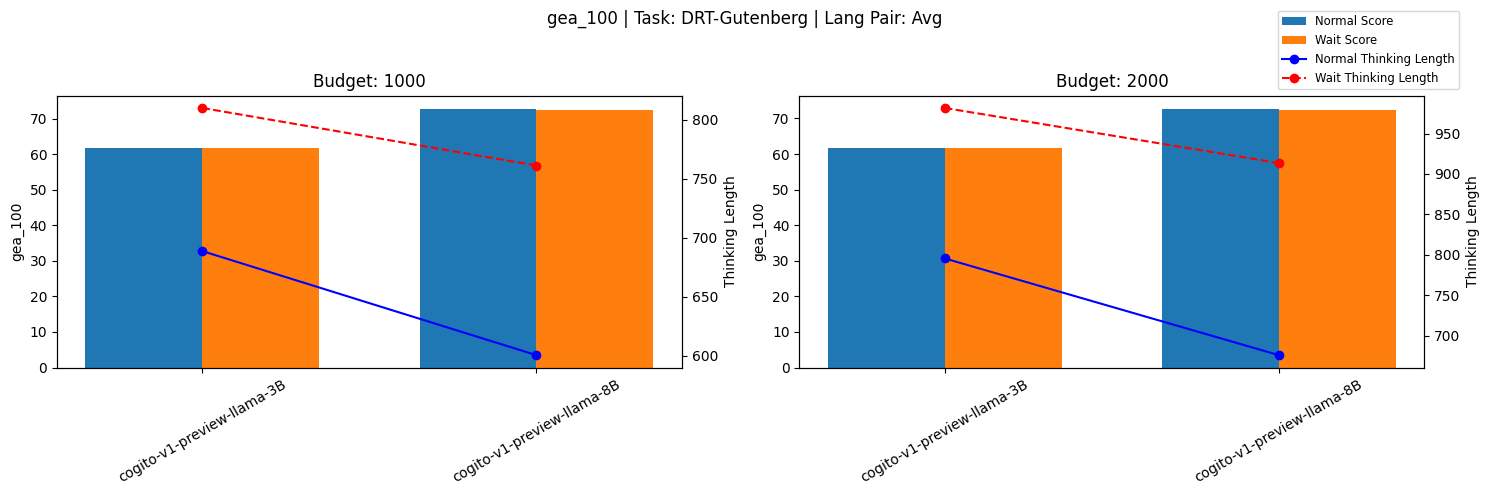

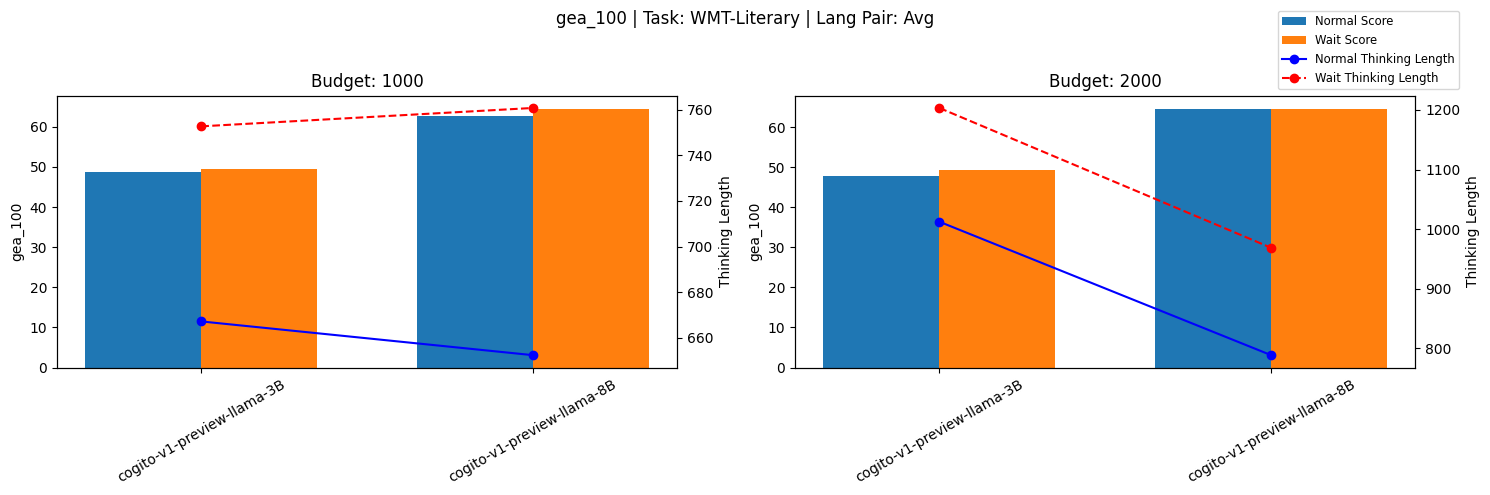

In [41]:
plot_metric_comparison(
    "gea_100",
    exclude_models=[
        "Qwen3-0.6B",
        "Qwen3-1.7B",
        "Qwen3-4B",
        "Qwen3-8B",
        "Qwen3-14B",
        "Qwen3-32B",
    ],
)